![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
!pip install lightgbm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación librerías
%matplotlib inline
import pandas as pd
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

In [4]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [5]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [6]:
# Visualización datos de test
dataTesting.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


In [7]:
dataTraining['Make'] = dataTraining['Make'].astype('category')
dataTraining['Model'] = dataTraining['Model'].astype('category')
dataTraining['State'] = dataTraining['State'].astype('category')
dataTraining.dtypes

Price         int64
Year          int64
Mileage       int64
State      category
Make       category
Model      category
dtype: object

In [8]:
dataTraining.isnull().sum()

Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

In [9]:
dataTraining.shape

(400000, 6)

In [10]:
dataTraining['State'].unique()

[' FL', ' OH', ' TX', ' CO', ' ME', ..., ' DE', ' ID', ' RI', ' WY', ' DC']
Length: 51
Categories (51, object): [' AK', ' AL', ' AR', ' AZ', ..., ' WA', ' WI', ' WV', ' WY']

In [11]:
dataTraining['Make'].unique()

['Jeep', 'Chevrolet', 'BMW', 'Cadillac', 'Mercedes-Benz', ..., 'Pontiac', 'Jaguar', 'Bentley', 'Suzuki', 'Freightliner']
Length: 38
Categories (38, object): ['Acura', 'Audi', 'BMW', 'Bentley', ..., 'Tesla', 'Toyota', 'Volkswagen', 'Volvo']

In [12]:
dataTraining['Model'].unique()

['Wrangler', 'Tahoe4WD', 'X5AWD', 'SRXLuxury', '3', ..., 'PriusOne', 'Element2WD', 'Excursion137"', 'WRXPremium', 'RX-84dr']
Length: 525
Categories (525, object): ['1', '15002WD', '15004WD', '1500Laramie', ..., 'Yukon4dr', 'tC2dr', 'xB5dr', 'xD5dr']

In [13]:
# Eliminar duplicados
duplicados = dataTraining.duplicated()
print("Número total de duplicados en el DataFrame: ", duplicados.sum())

Número total de duplicados en el DataFrame:  169


In [14]:
dataTraining = dataTraining.drop_duplicates()

In [15]:
dataTraining.describe()

,Price,Year,Mileage
count,399831.000000,399831.000000,3.998310e+05
mean,21143.998537,2013.196591,5.509327e+04
std,10751.954687,3.292060,4.087644e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.586450e+04
50%,18449.000000,2014.000000,4.297000e+04
75%,26999.000000,2016.000000,7.745400e+04
max,79999.000000,2018.000000,2.457832e+06


Podemos observar que el valor máximo que toma la variable "Mileage" es de 2'457.832 millas, lo cual es un valor atípico. Para este caso, se tomará la convención de que un automóvil en promedio recorre 15.000 millas por año y por lo tanto se eliminarán los registros que presenten un kilometraje superior a 275.000 millas (que corresponden a los 22 años que hay entre 1997 y 2018 en nuestro dataset).

In [16]:
dataTraining = dataTraining.drop(dataTraining[dataTraining['Mileage'] > 275000].index)

In [17]:
dataTraining.describe()

,Price,Year,Mileage
count,399576.000000,399576.000000,399576.000000
mean,21149.448563,2013.201216,54896.695560
std,10751.584858,3.286116,39831.623165
min,5001.000000,1997.000000,5.000000
25%,13500.000000,2012.000000,25851.000000
50%,18455.000000,2014.000000,42946.000000
75%,26999.000000,2016.000000,77362.000000
max,79999.000000,2018.000000,274893.000000


In [18]:
dataTraining.shape

(399576, 6)

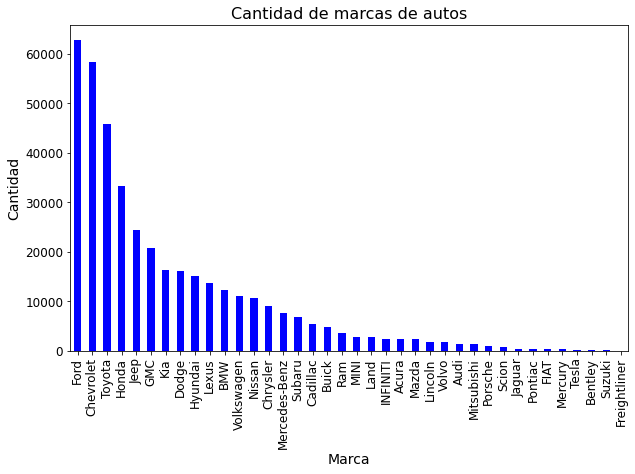

In [19]:
conteo_make = dataTraining['Make'].value_counts()
conteo_make.plot.bar(figsize=(10,6), fontsize=12, color='blue')
plt.title('Cantidad de marcas de autos', fontsize=16)
plt.xlabel('Marca', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)
plt.show()

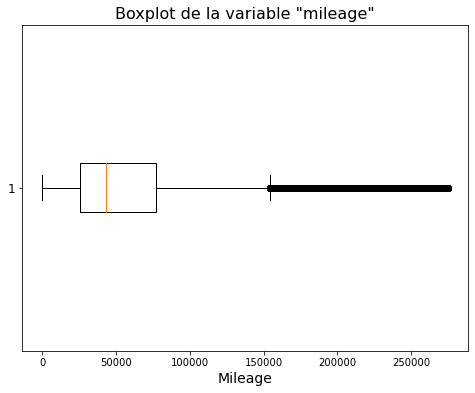

In [20]:
plt.figure(figsize=(8, 6))
plt.boxplot(dataTraining['Mileage'], vert=False)
plt.title('Boxplot de la variable "mileage"', fontsize=16)
plt.xlabel('Mileage', fontsize=14)
plt.yticks(fontsize=12)
plt.show()

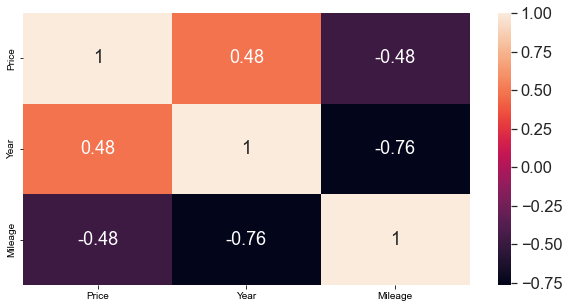

In [21]:
MatrixCorrelacion = dataTraining.corr()

fig, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale=1.5)  

sns.heatmap(MatrixCorrelacion, annot=True, ax=ax)
plt.show()

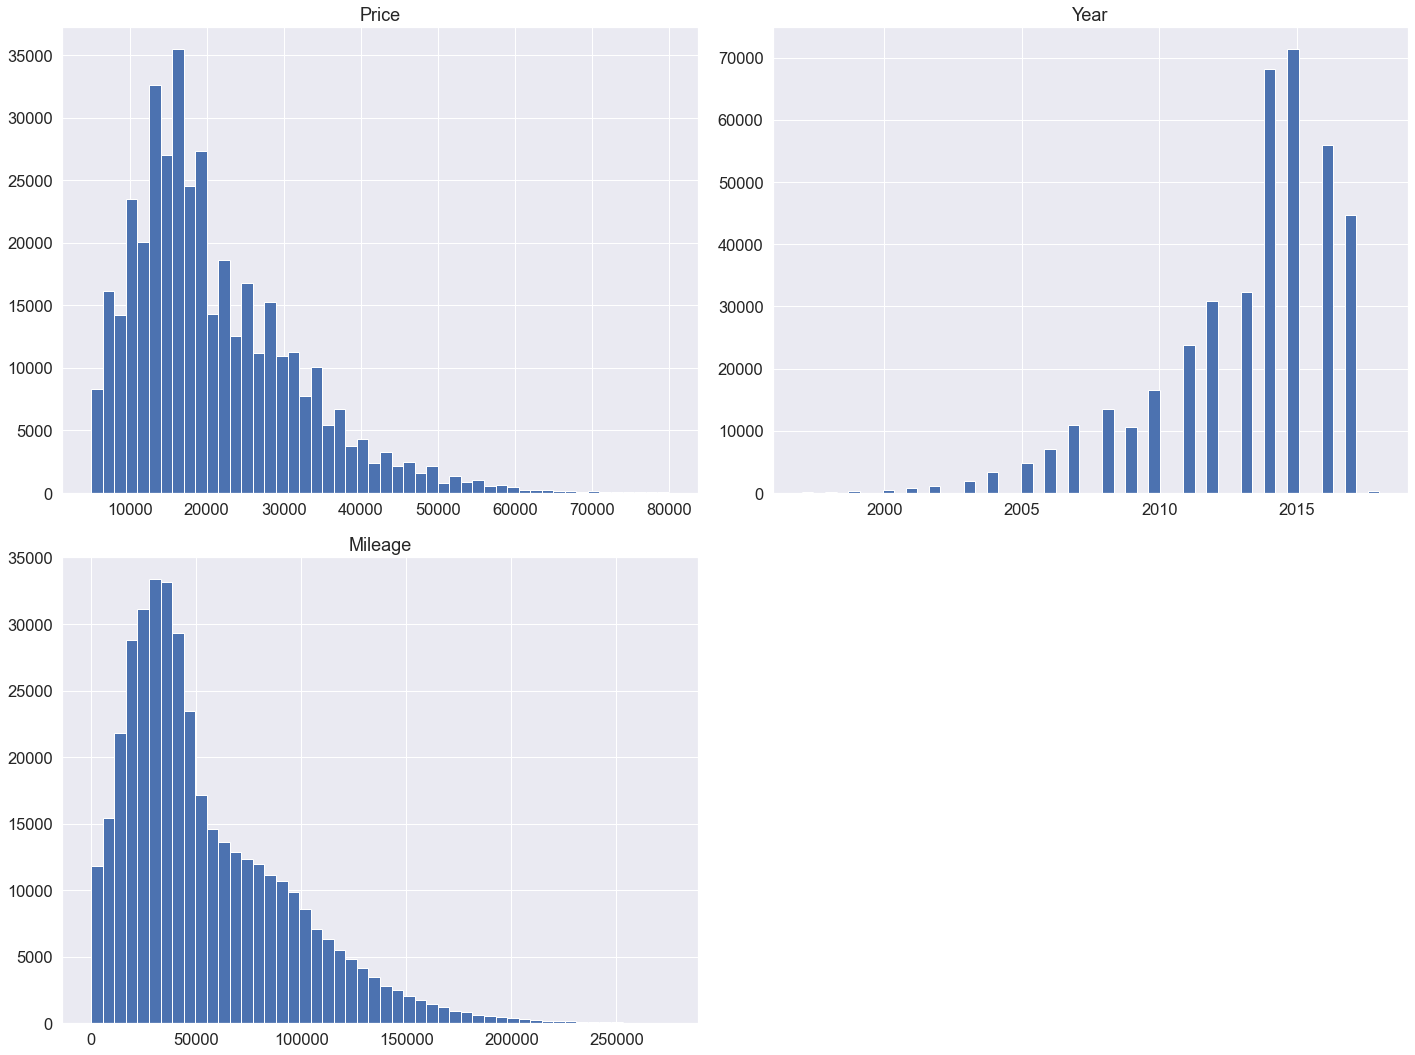

In [22]:
#Histograma para todas las variables numéricas incluyendo la variable de respuesta
dataTraining.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

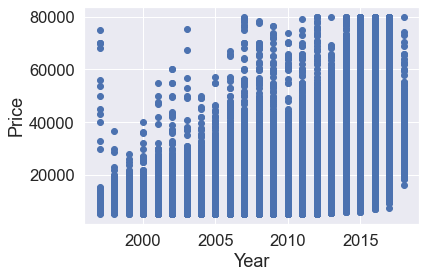

In [23]:
plt.scatter(dataTraining.Year,dataTraining.Price)
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()

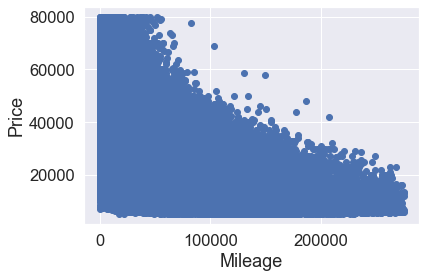

In [24]:
plt.scatter(dataTraining.Mileage,dataTraining.Price)
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.show()

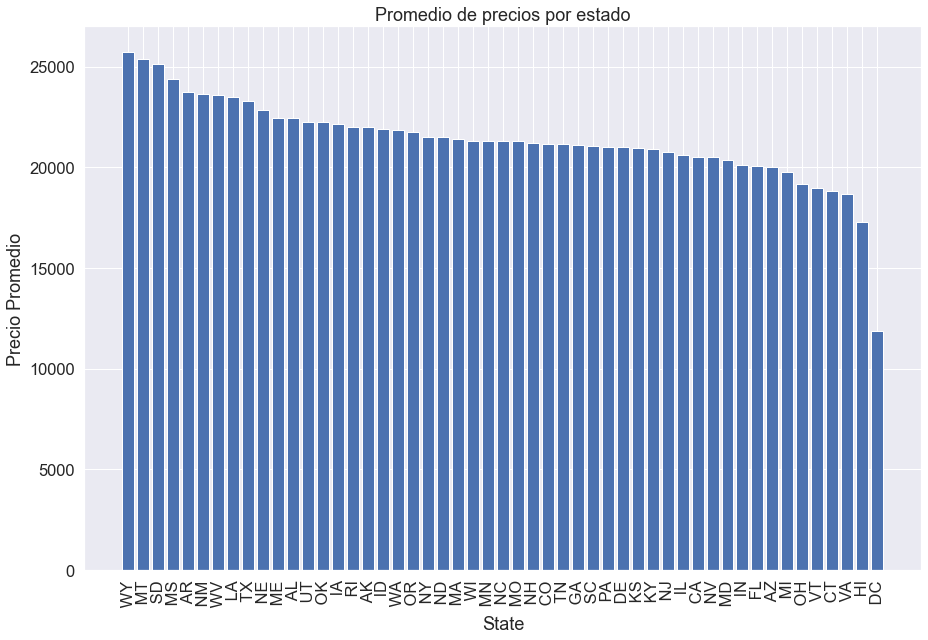

In [25]:
# Agrupamos por Estado y calculamos el promedio de los precios
data = dataTraining.groupby('State')['Price'].mean()

# Ordenamos los valores de mayor a menor
data = data.sort_values(ascending=False)

# Creamos la gráfica de barras
plt.figure(figsize=(15,10))
plt.bar(data.index, data.values)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Precio Promedio')
plt.title('Promedio de precios por estado')
plt.show()

<AxesSubplot:xlabel='Price', ylabel='Density'>

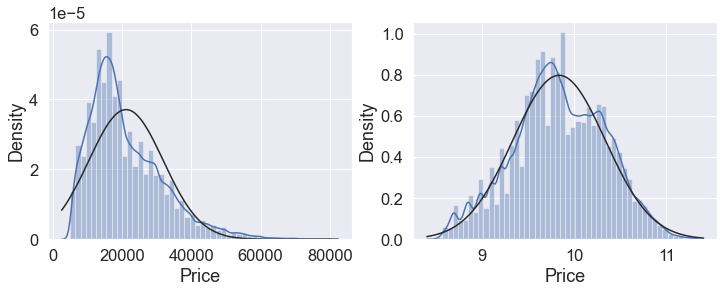

In [26]:
from scipy.stats import norm
fig, ax = plt.subplots(1,2)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.distplot(dataTraining['Price'], ax=ax[0], fit=norm)
sns.distplot(np.log(dataTraining[('Price')]+1), ax=ax[1], fit= norm)

In [27]:
dataTraining.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

In [28]:
# Fit transform

scaler = StandardScaler()
scaler.fit(dataTraining[['Mileage']])
dataTraining[['Mileage']] = scaler.transform(dataTraining[['Mileage']])
dataTesting[['Mileage']] = scaler.transform(dataTesting[['Mileage']])

In [29]:
k=104

############################## Dummies para Marca ####################################
dummies = pd.get_dummies(dataTraining['Make'], prefix='Make')
dummies=dummies.drop('Make_Freightliner', axis=1)
dataTraining = pd.concat([dataTraining, dummies], axis=1)   

######################## Dummies para los modelos ##########################

# Crear un diccionario vacío para almacenar los resultados
promedios_por_marca = {}

# Recorrer los valores distintos de la columna "Make"
for marca in dataTraining["Model"].unique():
    # Obtener el promedio de la columna "Price" para los registros donde "Make" es igual a la marca actual
    promedio = dataTraining.loc[dataTraining["Model"] == marca, "Price"].mean()
    # Agregar la marca y su promedio al diccionario
    promedios_por_marca[marca] = promedio
diccionario_ordenado = dict(sorted(promedios_por_marca.items(), key=lambda x: x[1], reverse=True))

In [30]:
column_names = []
for i in range(0, 60000, int(60000/k)):
    name = f"{i}-{i+int(60000/k)}"
    column_names.append(name)

# Creamos las columnas con el nombre de la partición en el dataframe
for i in range(len(column_names)):
    dataTraining[column_names[i]]=0

# Creamos diccionario con el rango de precios como llaves y los modelos que se encuentran en ese rango como valores
rango_precios = {}

for column in column_names:
    start, end = column.split("-")
    start, end = int(start), int(end)
    rango_precios[column] = [key for key, value in diccionario_ordenado.items() if start <= value <= end]

# Validar si el valor de la columna Model está en el diccionario rango_precios
for i, row in dataTraining.iterrows():
    model = row['Model']
    for key, value in rango_precios.items():
        if model in value:
            dataTraining.at[i, key] = 1

############################## Dummies para State ####################################
dummies = pd.get_dummies(dataTraining['State'], prefix='State')
dataTraining = pd.concat([dataTraining, dummies], axis=1)

dataTraining = dataTraining.drop(['State', 'Make', 'Model'], axis=1)
# ---------------------------------------------------------------------------------------------------

# Separación de variables predictoras (X) y variable de interés (y)
y = dataTraining['Price']
X = dataTraining.drop(['Price'], axis=1)

# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
y_train

337913    36800
138476    28900
121265    35233
112111     5900
79435     29500
          ...  
259423     5995
366226    18793
132030    19995
146977     9998
122048    74999
Name: Price, Length: 267715, dtype: int64

In [32]:
y_test

237806     7320
40291     13853
105338    31890
379199    33000
10772     11900
          ...  
395934     9776
33439      6900
48716     16400
305162    21995
197941    26900
Name: Price, Length: 131861, dtype: int64

In [33]:
y_train = np.log1p(y_train)

In [34]:
y_train

337913    10.513280
138476    10.271631
121265    10.469767
112111     8.682877
79435     10.292179
            ...    
259423     8.698848
366226     9.841293
132030     9.903288
146977     9.210240
122048    11.225243
Name: Price, Length: 267715, dtype: float64

#### Random forest

##### Calibración del modelo

In [35]:
# Calibración n_estimators
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 50, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []
mse_scores = []
# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rrf = RandomForestRegressor(n_estimators=estimator, max_depth=4, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(rrf, X_train, y_train, cv=5).mean())
    mse_scores.append(np.sqrt(np.abs(cross_val_score(rrf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())))

Text(0, 0.5, 'Accuracy')

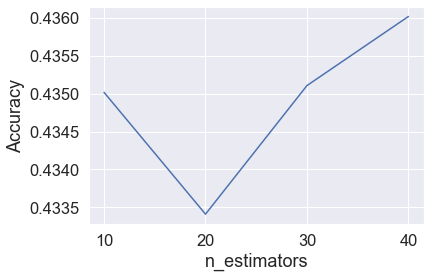

In [36]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [37]:
nEstimators = estimator_range[accuracy_scores.index(max(accuracy_scores))]
nEstimators

40

In [38]:
# Calibración max_depth 
# Creación de lista de valores para iterar sobre diferentes valores de max_features
depth_range = range(1, 6)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []
mse_scores = []
# Uso de un 10-fold cross-validation para cada valor de max_features
for depth in depth_range:
    rrf = RandomForestRegressor(n_estimators=nEstimators, max_depth=depth, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(rrf, X_train, y_train, cv=5).mean())
    mse_scores.append(np.sqrt(np.abs(cross_val_score(rrf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())))

Text(0, 0.5, 'Accuracy')

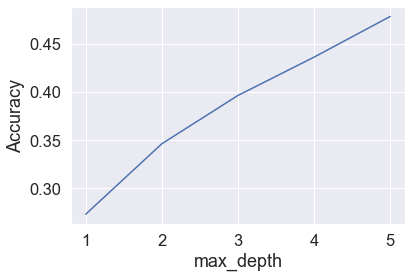

In [39]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [40]:
maxDepth = depth_range[accuracy_scores.index(max(accuracy_scores))]
maxDepth

5

##### Entrenamiento del modelo

In [41]:
rrf = RandomForestRegressor(n_estimators=nEstimators, max_depth=maxDepth, random_state=1, n_jobs=-1)
cross_val_score(rrf, X_train, y_train, cv=10)
rrf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=40, n_jobs=-1, random_state=1)

In [45]:
#Impresión de desempeño del modelo
y_pred = rrf.predict(X_test)
y_pred = np.expm1(y_pred)

# RMSE
rrf_RMSE = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %.3f" %rrf_RMSE )
# MAE
rrf_MAE = mean_absolute_error(y_test, y_pred)
print("MAE: %.3f" %rrf_MAE )

RMSE: 8599.160
MAE: 6138.472


In [42]:
#Impresión de desempeño del modelo
y_pred = rrf.predict(X_test)
y_pred

array([ 9.45243624,  9.60287248, 10.19313027, ...,  9.95745422,
        9.95745422, 10.13080957])

In [43]:
y_test

237806     7320
40291     13853
105338    31890
379199    33000
10772     11900
          ...  
395934     9776
33439      6900
48716     16400
305162    21995
197941    26900
Name: Price, Length: 131861, dtype: int64

In [44]:
y_pred = np.expm1(y_pred)
y_pred

array([12738.16313141, 14806.25400431, 26718.00184871, ...,
       21107.98849626, 21107.98849626, 25103.68021014])

In [45]:
# RMSE
rrf_RMSE = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %.3f" %rrf_RMSE )
# MAE
rrf_MAE = mean_absolute_error(y_test, y_pred)
print("MAE: %.3f" %rrf_MAE )

RMSE: 8599.160
MAE: 6138.472


#### XGBoost

In [46]:
xgb = XGBRegressor(n_jobs=-1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [50]:
#Impresión de desempeño del modelo
y_pred = xgb.predict(X_test)
y_pred = np.expm1(y_pred)

# RMSE
xgb_RMSE = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %.3f" %xgb_RMSE )
# MAE
xgb_MAE = mean_absolute_error(y_test, y_pred)
print("MAE: %.3f" %xgb_MAE )

RMSE: 3910.140
MAE: 2532.472


In [47]:
#Impresión de desempeño del modelo
y_pred = xgb.predict(X_test)
y_pred

array([ 9.165095,  9.592156, 10.407469, ...,  9.703789,  9.902559,
       10.267666], dtype=float32)

In [48]:
y_test

237806     7320
40291     13853
105338    31890
379199    33000
10772     11900
          ...  
395934     9776
33439      6900
48716     16400
305162    21995
197941    26900
Name: Price, Length: 131861, dtype: int64

In [49]:
y_pred = np.expm1(y_pred)
y_pred

array([ 9556.633, 14648.426, 33104.965, ..., 16378.548, 19980.443,
       28785.617], dtype=float32)

In [50]:
# RMSE
xgb_RMSE = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %.3f" %xgb_RMSE )
# MAE
xgb_MAE = mean_absolute_error(y_test, y_pred)
print("MAE: %.3f" %xgb_MAE )

RMSE: 3910.140
MAE: 2532.472


#### LightGBM

In [51]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000
}

In [52]:
lgbm = lgb.LGBMRegressor(**hyper_params)

In [53]:
y_test = np.log1p(y_test)

In [54]:
lgbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.9, col

[138]	valid_0's l1: 0.296485	valid_0's l2: 0.137197
[139]	valid_0's l1: 0.295941	valid_0's l2: 0.136728
[140]	valid_0's l1: 0.295512	valid_0's l2: 0.136286
[141]	valid_0's l1: 0.295057	valid_0's l2: 0.135825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's l1: 0.294778	valid_0's l2: 0.13558
[143]	valid_0's l1: 0.294254	valid_0's l2: 0.135123
[144]	valid_0's l1: 0.293819	valid_0's l2: 0.134689
[145]	valid_0's l1: 0.293296	valid_0's l2: 0.134246
[146]	valid_0's l1: 0.292766	valid_0's l2: 0.133794
[147]	valid_0's l1: 0.29228	valid_0's l2: 0.133348
[148]	valid_0's l1: 0.29183	valid_0's l2: 0.132929
[149]	valid_0's l1: 0.291316	valid_0's l2: 0.132492
[150]	valid_0's l1: 0.290808	valid_0's l2: 0.132054
[151]	valid_0's l1: 0.29031	valid_0's l2: 0.131632
[152]	valid_0's l1: 0.289805	valid_0's l2: 0.13121
[153]	valid_0's l1: 0.289334	valid_0's l2: 0.130797
[154]	valid_0's l1: 0.288907	valid_0's l2: 0.130404
[155]	valid_0's l1: 0.288409	valid_0's l2: 0.1

[299]	valid_0's l1: 0.239681	valid_0's l2: 0.0910665
[300]	valid_0's l1: 0.239461	valid_0's l2: 0.0909006
[301]	valid_0's l1: 0.239222	valid_0's l2: 0.0907265
[302]	valid_0's l1: 0.238998	valid_0's l2: 0.0905568
[303]	valid_0's l1: 0.238732	valid_0's l2: 0.0903842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[304]	valid_0's l1: 0.238471	valid_0's l2: 0.0902146
[305]	valid_0's l1: 0.238242	valid_0's l2: 0.0900495
[306]	valid_0's l1: 0.237996	valid_0's l2: 0.089872
[307]	valid_0's l1: 0.237764	valid_0's l2: 0.0897023
[308]	valid_0's l1: 0.237544	valid_0's l2: 0.0895349
[309]	valid_0's l1: 0.237316	valid_0's l2: 0.0893771
[310]	valid_0's l1: 0.237105	valid_0's l2: 0.0892145
[311]	valid_0's l1: 0.236865	valid_0's l2: 0.0890519
[312]	valid_0's l1: 0.236606	valid_0's l2: 0.0888826
[313]	valid_0's l1: 0.236331	valid_0's l2: 0.0887134
[314]	valid_0's l1: 0.236117	valid_0's l2: 0.0885612
[315]	valid_0's l1: 0.235853	valid_0's l2: 0.0883958
[316]	valid_0's l1: 0.235

[433]	valid_0's l1: 0.214174	valid_0's l2: 0.0737668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[434]	valid_0's l1: 0.214033	valid_0's l2: 0.073669
[435]	valid_0's l1: 0.21386	valid_0's l2: 0.0735689
[436]	valid_0's l1: 0.213719	valid_0's l2: 0.0734782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[437]	valid_0's l1: 0.213568	valid_0's l2: 0.0733842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[438]	valid_0's l1: 0.213436	valid_0's l2: 0.0732928
[439]	valid_0's l1: 0.213279	valid_0's l2: 0.0731989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's l1: 0.213126	valid_0's l2: 0.0731154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's l1: 0.213003	valid_0's l2: 0.0730251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[442]	valid_0's l1: 0.212876	valid_0's l2: 0.0729394
[443]	valid_0's l1: 0.

[530]	valid_0's l1: 0.201312	valid_0's l2: 0.0660129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[531]	valid_0's l1: 0.201192	valid_0's l2: 0.0659422
[532]	valid_0's l1: 0.201072	valid_0's l2: 0.0658721
[533]	valid_0's l1: 0.20096	valid_0's l2: 0.0658028
[534]	valid_0's l1: 0.20085	valid_0's l2: 0.0657337
[535]	valid_0's l1: 0.200741	valid_0's l2: 0.0656652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[536]	valid_0's l1: 0.20062	valid_0's l2: 0.0655968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	valid_0's l1: 0.200513	valid_0's l2: 0.0655297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	valid_0's l1: 0.200408	valid_0's l2: 0.065461
[539]	valid_0's l1: 0.200295	valid_0's l2: 0.0653929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	valid_0's l1: 0.200192	valid_0's l2: 0.0653272
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's l1: 0.193148	valid_0's l2: 0.0613214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's l1: 0.193049	valid_0's l2: 0.06127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's l1: 0.192934	valid_0's l2: 0.0612111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	valid_0's l1: 0.192847	valid_0's l2: 0.061159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	valid_0's l1: 0.192711	valid_0's l2: 0.0610904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	valid_0's l1: 0.192615	valid_0's l2: 0.0610341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[612]	valid_0's l1: 0.192508	valid_0's l2: 0.0609784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[613]	valid_0's l1: 0.192413	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	valid_0's l1: 0.186547	valid_0's l2: 0.057662
[679]	valid_0's l1: 0.186447	valid_0's l2: 0.0576112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[680]	valid_0's l1: 0.186358	valid_0's l2: 0.0575615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[681]	valid_0's l1: 0.186279	valid_0's l2: 0.0575198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[682]	valid_0's l1: 0.186196	valid_0's l2: 0.0574783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	valid_0's l1: 0.186124	valid_0's l2: 0.0574354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	valid_0's l1: 0.186037	valid_0's l2: 0.0573933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[685]	valid_0's l1: 0.185961	valid_0's l2: 0.0573522
[LightGBM] [Warning] No further splits with positive

[751]	valid_0's l1: 0.18098	valid_0's l2: 0.0546072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	valid_0's l1: 0.180892	valid_0's l2: 0.0545641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[753]	valid_0's l1: 0.18081	valid_0's l2: 0.054524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[754]	valid_0's l1: 0.18074	valid_0's l2: 0.0544871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[755]	valid_0's l1: 0.180674	valid_0's l2: 0.0544522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[756]	valid_0's l1: 0.180602	valid_0's l2: 0.0544162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[757]	valid_0's l1: 0.180534	valid_0's l2: 0.0543813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[758]	valid_0's l1: 0.180465	valid_0's l2: 0.0543463
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[825]	valid_0's l1: 0.176033	valid_0's l2: 0.0519937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[826]	valid_0's l1: 0.175973	valid_0's l2: 0.0519636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[827]	valid_0's l1: 0.17591	valid_0's l2: 0.0519326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[828]	valid_0's l1: 0.175844	valid_0's l2: 0.0519001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[829]	valid_0's l1: 0.175782	valid_0's l2: 0.0518703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[830]	valid_0's l1: 0.175731	valid_0's l2: 0.0518434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[831]	valid_0's l1: 0.175677	valid_0's l2: 0.0518153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[832]	valid_0's l1: 0.175625	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[895]	valid_0's l1: 0.172097	valid_0's l2: 0.0498705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[896]	valid_0's l1: 0.172056	valid_0's l2: 0.0498478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[897]	valid_0's l1: 0.171995	valid_0's l2: 0.0498175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[898]	valid_0's l1: 0.171956	valid_0's l2: 0.0497948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[899]	valid_0's l1: 0.171901	valid_0's l2: 0.0497659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[900]	valid_0's l1: 0.171828	valid_0's l2: 0.0497296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[901]	valid_0's l1: 0.171777	valid_0's l2: 0.0496997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[902]	valid_0's l1: 0.171724	

[965]	valid_0's l1: 0.168376	valid_0's l2: 0.0479539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[966]	valid_0's l1: 0.168315	valid_0's l2: 0.0479233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[967]	valid_0's l1: 0.168269	valid_0's l2: 0.047895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[968]	valid_0's l1: 0.168211	valid_0's l2: 0.0478677
[969]	valid_0's l1: 0.168154	valid_0's l2: 0.0478368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[970]	valid_0's l1: 0.168113	valid_0's l2: 0.0478155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[971]	valid_0's l1: 0.16808	valid_0's l2: 0.0477945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[972]	valid_0's l1: 0.168045	valid_0's l2: 0.0477742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[973]	valid_0's l1: 0.168007	valid_0's l2: 0.0477536


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1036]	valid_0's l1: 0.164899	valid_0's l2: 0.0461647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1037]	valid_0's l1: 0.164825	valid_0's l2: 0.0461254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1038]	valid_0's l1: 0.164782	valid_0's l2: 0.0461052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1039]	valid_0's l1: 0.164725	valid_0's l2: 0.0460791
[1040]	valid_0's l1: 0.164654	valid_0's l2: 0.0460411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1041]	valid_0's l1: 0.164619	valid_0's l2: 0.0460225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1042]	valid_0's l1: 0.164579	valid_0's l2: 0.0460033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1043]	valid_0's l1: 0.16453	valid_0's l2: 0.0459801
[LightGBM] [Warning] No further splits with 

[1103]	valid_0's l1: 0.16201	valid_0's l2: 0.044714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1104]	valid_0's l1: 0.161976	valid_0's l2: 0.0446961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1105]	valid_0's l1: 0.161943	valid_0's l2: 0.0446785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1106]	valid_0's l1: 0.161901	valid_0's l2: 0.0446552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1107]	valid_0's l1: 0.161852	valid_0's l2: 0.0446328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1108]	valid_0's l1: 0.161818	valid_0's l2: 0.0446157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1109]	valid_0's l1: 0.161783	valid_0's l2: 0.0445982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1110]	valid_0's l1: 0.161733	valid_0's l2: 0.0445745
[1111]	valid_0's l1: 0.161686	valid_0's l2: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1174]	valid_0's l1: 0.15911	valid_0's l2: 0.0432895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1175]	valid_0's l1: 0.159083	valid_0's l2: 0.0432742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1176]	valid_0's l1: 0.159045	valid_0's l2: 0.0432561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1177]	valid_0's l1: 0.159006	valid_0's l2: 0.0432365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1178]	valid_0's l1: 0.158967	valid_0's l2: 0.0432182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1179]	valid_0's l1: 0.158929	valid_0's l2: 0.043199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1180]	valid_0's l1: 0.158904	valid_0's l2: 0.0431846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1181]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1244]	valid_0's l1: 0.156688	valid_0's l2: 0.0421046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1245]	valid_0's l1: 0.156654	valid_0's l2: 0.0420888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1246]	valid_0's l1: 0.15662	valid_0's l2: 0.0420739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1247]	valid_0's l1: 0.156584	valid_0's l2: 0.0420577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1248]	valid_0's l1: 0.156549	valid_0's l2: 0.0420426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1249]	valid_0's l1: 0.156512	valid_0's l2: 0.0420258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1250]	valid_0's l1: 0.156474	valid_0's l2: 0.0420092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1251]	valid_0's l1: 0.

[1310]	valid_0's l1: 0.154458	valid_0's l2: 0.0410464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1311]	valid_0's l1: 0.154401	valid_0's l2: 0.0410183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1312]	valid_0's l1: 0.154345	valid_0's l2: 0.0409911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1313]	valid_0's l1: 0.154297	valid_0's l2: 0.0409662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1314]	valid_0's l1: 0.154241	valid_0's l2: 0.0409401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1315]	valid_0's l1: 0.154206	valid_0's l2: 0.0409199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1316]	valid_0's l1: 0.154187	valid_0's l2: 0.0409058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1317]	valid_0's l1: 0.154164	valid_0's l2: 0.040893
[LightGBM] [Warning] No further splits with 

[1380]	valid_0's l1: 0.152316	valid_0's l2: 0.0400209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1381]	valid_0's l1: 0.152295	valid_0's l2: 0.040008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1382]	valid_0's l1: 0.15227	valid_0's l2: 0.0399964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1383]	valid_0's l1: 0.152244	valid_0's l2: 0.0399837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1384]	valid_0's l1: 0.152223	valid_0's l2: 0.0399713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1385]	valid_0's l1: 0.15219	valid_0's l2: 0.0399578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1386]	valid_0's l1: 0.152161	valid_0's l2: 0.0399459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1387]	valid_0's l1: 0.15214	valid_0's l2: 0.0399335
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1451]	valid_0's l1: 0.150384	valid_0's l2: 0.0391028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1452]	valid_0's l1: 0.150349	valid_0's l2: 0.0390883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1453]	valid_0's l1: 0.150327	valid_0's l2: 0.0390781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1454]	valid_0's l1: 0.150305	valid_0's l2: 0.0390675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1455]	valid_0's l1: 0.150278	valid_0's l2: 0.0390555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1456]	valid_0's l1: 0.150258	valid_0's l2: 0.0390451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1457]	valid_0's l1: 0.150235	valid_0's l2: 0.0390341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1458]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1520]	valid_0's l1: 0.148676	valid_0's l2: 0.0383032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1521]	valid_0's l1: 0.148627	valid_0's l2: 0.0382825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1522]	valid_0's l1: 0.148593	valid_0's l2: 0.0382679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1523]	valid_0's l1: 0.148568	valid_0's l2: 0.0382543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1524]	valid_0's l1: 0.148547	valid_0's l2: 0.0382447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1525]	valid_0's l1: 0.148524	valid_0's l2: 0.0382341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1526]	valid_0's l1: 0.148484	valid_0's l2: 0.038217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1527]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1585]	valid_0's l1: 0.146968	valid_0's l2: 0.0375318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1586]	valid_0's l1: 0.146946	valid_0's l2: 0.0375216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1587]	valid_0's l1: 0.146908	valid_0's l2: 0.037506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1588]	valid_0's l1: 0.146876	valid_0's l2: 0.0374925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1589]	valid_0's l1: 0.146855	valid_0's l2: 0.0374841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1590]	valid_0's l1: 0.146828	valid_0's l2: 0.0374719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1591]	valid_0's l1: 0.146803	valid_0's l2: 0.0374598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1592]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1658]	valid_0's l1: 0.14529	valid_0's l2: 0.036762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1659]	valid_0's l1: 0.145276	valid_0's l2: 0.036755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1660]	valid_0's l1: 0.145254	valid_0's l2: 0.0367454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1661]	valid_0's l1: 0.145237	valid_0's l2: 0.0367374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1662]	valid_0's l1: 0.145217	valid_0's l2: 0.0367296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1663]	valid_0's l1: 0.145201	valid_0's l2: 0.0367219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1664]	valid_0's l1: 0.145184	valid_0's l2: 0.0367148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1665]	valid_0's l1: 0.14

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1725]	valid_0's l1: 0.143897	valid_0's l2: 0.036133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1726]	valid_0's l1: 0.143884	valid_0's l2: 0.0361258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1727]	valid_0's l1: 0.143863	valid_0's l2: 0.0361178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1728]	valid_0's l1: 0.143847	valid_0's l2: 0.0361103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1729]	valid_0's l1: 0.143827	valid_0's l2: 0.0361022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1730]	valid_0's l1: 0.143807	valid_0's l2: 0.0360937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1731]	valid_0's l1: 0.143786	valid_0's l2: 0.0360848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1732]	valid_0's l1: 0.

[1796]	valid_0's l1: 0.142521	valid_0's l2: 0.0355269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1797]	valid_0's l1: 0.142507	valid_0's l2: 0.0355209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1798]	valid_0's l1: 0.142491	valid_0's l2: 0.035514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1799]	valid_0's l1: 0.142473	valid_0's l2: 0.0355064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1800]	valid_0's l1: 0.142451	valid_0's l2: 0.035496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1801]	valid_0's l1: 0.142433	valid_0's l2: 0.0354888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1802]	valid_0's l1: 0.142415	valid_0's l2: 0.0354809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1803]	valid_0's l1: 0.142394	valid_0's l2: 0.0354719
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1864]	valid_0's l1: 0.141027	valid_0's l2: 0.0348911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1865]	valid_0's l1: 0.141006	valid_0's l2: 0.0348811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1866]	valid_0's l1: 0.140992	valid_0's l2: 0.0348748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1867]	valid_0's l1: 0.140964	valid_0's l2: 0.0348623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1868]	valid_0's l1: 0.14095	valid_0's l2: 0.034856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1869]	valid_0's l1: 0.140924	valid_0's l2: 0.0348447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1870]	valid_0's l1: 0.140909	valid_0's l2: 0.0348386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1871]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1935]	valid_0's l1: 0.139667	valid_0's l2: 0.0342973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1936]	valid_0's l1: 0.139647	valid_0's l2: 0.0342892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1937]	valid_0's l1: 0.139629	valid_0's l2: 0.0342815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1938]	valid_0's l1: 0.139606	valid_0's l2: 0.0342707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1939]	valid_0's l1: 0.139592	valid_0's l2: 0.034265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1940]	valid_0's l1: 0.139573	valid_0's l2: 0.0342564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1941]	valid_0's l1: 0.139557	valid_0's l2: 0.0342497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1942]	valid_0's l1: 0.

[2001]	valid_0's l1: 0.138681	valid_0's l2: 0.0338576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2002]	valid_0's l1: 0.138666	valid_0's l2: 0.0338513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2003]	valid_0's l1: 0.138653	valid_0's l2: 0.0338457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2004]	valid_0's l1: 0.13864	valid_0's l2: 0.0338403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2005]	valid_0's l1: 0.13862	valid_0's l2: 0.0338326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2006]	valid_0's l1: 0.138607	valid_0's l2: 0.0338268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2007]	valid_0's l1: 0.138594	valid_0's l2: 0.0338216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2008]	valid_0's l1: 0.138574	valid_0's l2: 0.0338132
[LightGBM] [Warning] No further splits with p

[2070]	valid_0's l1: 0.137525	valid_0's l2: 0.0333715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2071]	valid_0's l1: 0.137515	valid_0's l2: 0.0333663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2072]	valid_0's l1: 0.137505	valid_0's l2: 0.0333616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2073]	valid_0's l1: 0.137496	valid_0's l2: 0.0333557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2074]	valid_0's l1: 0.137485	valid_0's l2: 0.0333505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2075]	valid_0's l1: 0.137476	valid_0's l2: 0.0333459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2076]	valid_0's l1: 0.137453	valid_0's l2: 0.0333362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2077]	valid_0's l1: 0.137444	valid_0's l2: 0.0333306
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2139]	valid_0's l1: 0.136314	valid_0's l2: 0.0328617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2140]	valid_0's l1: 0.136296	valid_0's l2: 0.0328547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2141]	valid_0's l1: 0.136276	valid_0's l2: 0.0328455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2142]	valid_0's l1: 0.136258	valid_0's l2: 0.0328385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2143]	valid_0's l1: 0.136234	valid_0's l2: 0.032829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2144]	valid_0's l1: 0.136212	valid_0's l2: 0.0328197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2145]	valid_0's l1: 0.13619	valid_0's l2: 0.0328105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2146]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2204]	valid_0's l1: 0.135335	valid_0's l2: 0.0324427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2205]	valid_0's l1: 0.135318	valid_0's l2: 0.0324361
[2206]	valid_0's l1: 0.135288	valid_0's l2: 0.0324242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2207]	valid_0's l1: 0.135271	valid_0's l2: 0.0324172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2208]	valid_0's l1: 0.135256	valid_0's l2: 0.0324118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2209]	valid_0's l1: 0.135241	valid_0's l2: 0.0324058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2210]	valid_0's l1: 0.135214	valid_0's l2: 0.0323948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2211]	valid_0's l1: 0.135203	valid_0's l2: 0.0323908
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2274]	valid_0's l1: 0.134475	valid_0's l2: 0.032095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2275]	valid_0's l1: 0.134451	valid_0's l2: 0.0320856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2276]	valid_0's l1: 0.134438	valid_0's l2: 0.0320804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2277]	valid_0's l1: 0.134425	valid_0's l2: 0.032075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2278]	valid_0's l1: 0.134412	valid_0's l2: 0.0320697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2279]	valid_0's l1: 0.134403	valid_0's l2: 0.0320657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2280]	valid_0's l1: 0.134389	valid_0's l2: 0.0320599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2281]	valid_0's l1: 0.1

[2339]	valid_0's l1: 0.133596	valid_0's l2: 0.0317325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2340]	valid_0's l1: 0.133579	valid_0's l2: 0.0317258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2341]	valid_0's l1: 0.133566	valid_0's l2: 0.0317201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2342]	valid_0's l1: 0.133551	valid_0's l2: 0.0317151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2343]	valid_0's l1: 0.133536	valid_0's l2: 0.0317102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2344]	valid_0's l1: 0.133524	valid_0's l2: 0.0317061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2345]	valid_0's l1: 0.133513	valid_0's l2: 0.0317011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2346]	valid_0's l1: 0.1335	valid_0's l2: 0.031696
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2411]	valid_0's l1: 0.132684	valid_0's l2: 0.0313621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2412]	valid_0's l1: 0.132671	valid_0's l2: 0.0313573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2413]	valid_0's l1: 0.132655	valid_0's l2: 0.031351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2414]	valid_0's l1: 0.132641	valid_0's l2: 0.0313456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2415]	valid_0's l1: 0.13263	valid_0's l2: 0.0313412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2416]	valid_0's l1: 0.132619	valid_0's l2: 0.031337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2417]	valid_0's l1: 0.132606	valid_0's l2: 0.0313317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2418]	valid_0's l1: 0.13

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2482]	valid_0's l1: 0.131868	valid_0's l2: 0.0310326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2483]	valid_0's l1: 0.131859	valid_0's l2: 0.0310291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2484]	valid_0's l1: 0.131847	valid_0's l2: 0.0310251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2485]	valid_0's l1: 0.131839	valid_0's l2: 0.0310214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2486]	valid_0's l1: 0.131827	valid_0's l2: 0.0310176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2487]	valid_0's l1: 0.13182	valid_0's l2: 0.0310144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2488]	valid_0's l1: 0.131809	valid_0's l2: 0.0310108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2489]	valid_0's l1: 0.

[2546]	valid_0's l1: 0.131139	valid_0's l2: 0.0307453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2547]	valid_0's l1: 0.131133	valid_0's l2: 0.0307426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2548]	valid_0's l1: 0.131124	valid_0's l2: 0.0307398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2549]	valid_0's l1: 0.131115	valid_0's l2: 0.030736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2550]	valid_0's l1: 0.131109	valid_0's l2: 0.0307333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2551]	valid_0's l1: 0.131097	valid_0's l2: 0.0307283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2552]	valid_0's l1: 0.131084	valid_0's l2: 0.0307231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2553]	valid_0's l1: 0.131073	valid_0's l2: 0.030718
[LightGBM] [Warning] No further splits with p

[2610]	valid_0's l1: 0.130495	valid_0's l2: 0.0304956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2611]	valid_0's l1: 0.130488	valid_0's l2: 0.0304931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2612]	valid_0's l1: 0.130474	valid_0's l2: 0.0304875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2613]	valid_0's l1: 0.130457	valid_0's l2: 0.0304805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2614]	valid_0's l1: 0.13043	valid_0's l2: 0.030469
[2615]	valid_0's l1: 0.130404	valid_0's l2: 0.0304585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2616]	valid_0's l1: 0.130372	valid_0's l2: 0.0304462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2617]	valid_0's l1: 0.130349	valid_0's l2: 0.0304366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2618]	valid_0's l1: 0.130325	valid_0's l2: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2682]	valid_0's l1: 0.12972	valid_0's l2: 0.0301872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2683]	valid_0's l1: 0.129713	valid_0's l2: 0.0301846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2684]	valid_0's l1: 0.129703	valid_0's l2: 0.030181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2685]	valid_0's l1: 0.129697	valid_0's l2: 0.0301785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2686]	valid_0's l1: 0.129689	valid_0's l2: 0.0301752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2687]	valid_0's l1: 0.129681	valid_0's l2: 0.0301718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2688]	valid_0's l1: 0.129669	valid_0's l2: 0.0301678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2689]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2753]	valid_0's l1: 0.128968	valid_0's l2: 0.0298977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2754]	valid_0's l1: 0.128957	valid_0's l2: 0.0298941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2755]	valid_0's l1: 0.128948	valid_0's l2: 0.0298911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2756]	valid_0's l1: 0.128939	valid_0's l2: 0.029888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2757]	valid_0's l1: 0.128932	valid_0's l2: 0.0298858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2758]	valid_0's l1: 0.12892	valid_0's l2: 0.0298817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2759]	valid_0's l1: 0.128911	valid_0's l2: 0.0298781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2760]	valid_0's l1: 0.1

[2817]	valid_0's l1: 0.128443	valid_0's l2: 0.0296916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2818]	valid_0's l1: 0.128437	valid_0's l2: 0.0296894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2819]	valid_0's l1: 0.128431	valid_0's l2: 0.0296868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2820]	valid_0's l1: 0.128411	valid_0's l2: 0.0296785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2821]	valid_0's l1: 0.128406	valid_0's l2: 0.0296764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2822]	valid_0's l1: 0.1284	valid_0's l2: 0.029674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2823]	valid_0's l1: 0.128393	valid_0's l2: 0.0296714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2824]	valid_0's l1: 0.128389	valid_0's l2: 0.0296691
[LightGBM] [Warning] No further splits with po

[2882]	valid_0's l1: 0.127878	valid_0's l2: 0.0294795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2883]	valid_0's l1: 0.127871	valid_0's l2: 0.0294767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2884]	valid_0's l1: 0.127861	valid_0's l2: 0.0294724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2885]	valid_0's l1: 0.127854	valid_0's l2: 0.0294693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2886]	valid_0's l1: 0.127835	valid_0's l2: 0.0294613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2887]	valid_0's l1: 0.127815	valid_0's l2: 0.0294531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2888]	valid_0's l1: 0.127809	valid_0's l2: 0.0294506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2889]	valid_0's l1: 0.127792	valid_0's l2: 0.0294437
[LightGBM] [Warning] No further splits with

[2947]	valid_0's l1: 0.127339	valid_0's l2: 0.0292765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2948]	valid_0's l1: 0.127327	valid_0's l2: 0.0292721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2949]	valid_0's l1: 0.127321	valid_0's l2: 0.0292703
[2950]	valid_0's l1: 0.127295	valid_0's l2: 0.0292593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2951]	valid_0's l1: 0.127285	valid_0's l2: 0.0292558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2952]	valid_0's l1: 0.12728	valid_0's l2: 0.0292537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2953]	valid_0's l1: 0.127275	valid_0's l2: 0.0292515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2954]	valid_0's l1: 0.12727	valid_0's l2: 0.0292494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2955]	valid_0's l1: 0.127263	valid_0's l2: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3014]	valid_0's l1: 0.126714	valid_0's l2: 0.0290401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3015]	valid_0's l1: 0.126704	valid_0's l2: 0.0290369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3016]	valid_0's l1: 0.126695	valid_0's l2: 0.0290333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3017]	valid_0's l1: 0.126689	valid_0's l2: 0.0290311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3018]	valid_0's l1: 0.126679	valid_0's l2: 0.0290281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3019]	valid_0's l1: 0.126673	valid_0's l2: 0.0290256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3020]	valid_0's l1: 0.126664	valid_0's l2: 0.0290221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3021]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3080]	valid_0's l1: 0.126195	valid_0's l2: 0.0288469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3081]	valid_0's l1: 0.12619	valid_0's l2: 0.0288447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3082]	valid_0's l1: 0.126186	valid_0's l2: 0.0288429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3083]	valid_0's l1: 0.12618	valid_0's l2: 0.0288408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3084]	valid_0's l1: 0.126175	valid_0's l2: 0.0288392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3085]	valid_0's l1: 0.126172	valid_0's l2: 0.0288374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3086]	valid_0's l1: 0.126168	valid_0's l2: 0.0288357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3087]	valid_0's l1: 0.1

[3150]	valid_0's l1: 0.125765	valid_0's l2: 0.0286778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3151]	valid_0's l1: 0.125759	valid_0's l2: 0.028676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3152]	valid_0's l1: 0.125754	valid_0's l2: 0.0286743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3153]	valid_0's l1: 0.125748	valid_0's l2: 0.0286725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3154]	valid_0's l1: 0.125743	valid_0's l2: 0.0286707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3155]	valid_0's l1: 0.125737	valid_0's l2: 0.028669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3156]	valid_0's l1: 0.125731	valid_0's l2: 0.0286674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3157]	valid_0's l1: 0.125726	valid_0's l2: 0.0286658
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3285]	valid_0's l1: 0.1248	valid_0's l2: 0.0283279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3286]	valid_0's l1: 0.124783	valid_0's l2: 0.0283216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3287]	valid_0's l1: 0.124767	valid_0's l2: 0.028316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3288]	valid_0's l1: 0.124762	valid_0's l2: 0.0283143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3289]	valid_0's l1: 0.124743	valid_0's l2: 0.0283072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3290]	valid_0's l1: 0.124726	valid_0's l2: 0.0283009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3291]	valid_0's l1: 0.124721	valid_0's l2: 0.0282991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3292]	valid_0's l1: 0.12

[3350]	valid_0's l1: 0.124303	valid_0's l2: 0.0281419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3351]	valid_0's l1: 0.124298	valid_0's l2: 0.0281403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3352]	valid_0's l1: 0.124294	valid_0's l2: 0.028139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3353]	valid_0's l1: 0.124289	valid_0's l2: 0.0281377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3354]	valid_0's l1: 0.124286	valid_0's l2: 0.0281364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3355]	valid_0's l1: 0.124281	valid_0's l2: 0.0281351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3356]	valid_0's l1: 0.124278	valid_0's l2: 0.0281339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3357]	valid_0's l1: 0.124273	valid_0's l2: 0.0281325
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3418]	valid_0's l1: 0.123921	valid_0's l2: 0.0280014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3419]	valid_0's l1: 0.123918	valid_0's l2: 0.0280005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3420]	valid_0's l1: 0.123914	valid_0's l2: 0.0279987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3421]	valid_0's l1: 0.123907	valid_0's l2: 0.0279963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3422]	valid_0's l1: 0.123903	valid_0's l2: 0.0279947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3423]	valid_0's l1: 0.123898	valid_0's l2: 0.0279931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3424]	valid_0's l1: 0.123895	valid_0's l2: 0.0279917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3425]	valid_0's l1: 0

[3484]	valid_0's l1: 0.123503	valid_0's l2: 0.0278451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3485]	valid_0's l1: 0.123499	valid_0's l2: 0.0278438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3486]	valid_0's l1: 0.123491	valid_0's l2: 0.0278414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3487]	valid_0's l1: 0.123483	valid_0's l2: 0.0278386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3488]	valid_0's l1: 0.123476	valid_0's l2: 0.0278363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3489]	valid_0's l1: 0.12347	valid_0's l2: 0.0278346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3490]	valid_0's l1: 0.123465	valid_0's l2: 0.0278326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3491]	valid_0's l1: 0.123462	valid_0's l2: 0.0278315
[LightGBM] [Warning] No further splits with 

[3550]	valid_0's l1: 0.123177	valid_0's l2: 0.0277324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3551]	valid_0's l1: 0.123173	valid_0's l2: 0.0277311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3552]	valid_0's l1: 0.123169	valid_0's l2: 0.0277297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3553]	valid_0's l1: 0.123165	valid_0's l2: 0.0277283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3554]	valid_0's l1: 0.123161	valid_0's l2: 0.0277269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3555]	valid_0's l1: 0.123157	valid_0's l2: 0.0277256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3556]	valid_0's l1: 0.123154	valid_0's l2: 0.0277244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3557]	valid_0's l1: 0.12315	valid_0's l2: 0.0277234
[LightGBM] [Warning] No further splits with 

[3617]	valid_0's l1: 0.122738	valid_0's l2: 0.0275765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3618]	valid_0's l1: 0.122732	valid_0's l2: 0.0275745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3619]	valid_0's l1: 0.122727	valid_0's l2: 0.0275729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3620]	valid_0's l1: 0.122719	valid_0's l2: 0.0275703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3621]	valid_0's l1: 0.122708	valid_0's l2: 0.0275661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3622]	valid_0's l1: 0.122697	valid_0's l2: 0.027562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3623]	valid_0's l1: 0.122693	valid_0's l2: 0.0275604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3624]	valid_0's l1: 0.122689	valid_0's l2: 0.0275592
[LightGBM] [Warning] No further splits with 

[3685]	valid_0's l1: 0.122424	valid_0's l2: 0.0274657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3686]	valid_0's l1: 0.122421	valid_0's l2: 0.0274645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3687]	valid_0's l1: 0.122418	valid_0's l2: 0.0274633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3688]	valid_0's l1: 0.122408	valid_0's l2: 0.0274598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3689]	valid_0's l1: 0.122405	valid_0's l2: 0.0274588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3690]	valid_0's l1: 0.122402	valid_0's l2: 0.0274577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3691]	valid_0's l1: 0.122396	valid_0's l2: 0.0274559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3692]	valid_0's l1: 0.122387	valid_0's l2: 0.0274532
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3753]	valid_0's l1: 0.122091	valid_0's l2: 0.0273467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3754]	valid_0's l1: 0.122086	valid_0's l2: 0.0273454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3755]	valid_0's l1: 0.122082	valid_0's l2: 0.027344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3756]	valid_0's l1: 0.122078	valid_0's l2: 0.027343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3757]	valid_0's l1: 0.122075	valid_0's l2: 0.0273419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3758]	valid_0's l1: 0.122072	valid_0's l2: 0.0273411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3759]	valid_0's l1: 0.122067	valid_0's l2: 0.0273396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3760]	valid_0's l1: 0.1

[3820]	valid_0's l1: 0.121743	valid_0's l2: 0.0272191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3821]	valid_0's l1: 0.121735	valid_0's l2: 0.0272163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3822]	valid_0's l1: 0.12173	valid_0's l2: 0.0272147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3823]	valid_0's l1: 0.121723	valid_0's l2: 0.0272121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3824]	valid_0's l1: 0.121719	valid_0's l2: 0.0272105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3825]	valid_0's l1: 0.121716	valid_0's l2: 0.0272093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3826]	valid_0's l1: 0.121712	valid_0's l2: 0.027208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3827]	valid_0's l1: 0.121708	valid_0's l2: 0.0272064
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3886]	valid_0's l1: 0.121463	valid_0's l2: 0.0271169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3887]	valid_0's l1: 0.12146	valid_0's l2: 0.0271159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3888]	valid_0's l1: 0.121457	valid_0's l2: 0.027115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3889]	valid_0's l1: 0.121454	valid_0's l2: 0.0271139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3890]	valid_0's l1: 0.121451	valid_0's l2: 0.0271129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3891]	valid_0's l1: 0.121445	valid_0's l2: 0.0271107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3892]	valid_0's l1: 0.121439	valid_0's l2: 0.0271085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3893]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3954]	valid_0's l1: 0.121126	valid_0's l2: 0.0270007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3955]	valid_0's l1: 0.121121	valid_0's l2: 0.0269991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3956]	valid_0's l1: 0.121117	valid_0's l2: 0.026998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3957]	valid_0's l1: 0.12111	valid_0's l2: 0.0269956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3958]	valid_0's l1: 0.121099	valid_0's l2: 0.0269915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3959]	valid_0's l1: 0.121092	valid_0's l2: 0.0269887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3960]	valid_0's l1: 0.12109	valid_0's l2: 0.0269879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3961]	valid_0's l1: 0.12

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4019]	valid_0's l1: 0.120818	valid_0's l2: 0.0268913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4020]	valid_0's l1: 0.120816	valid_0's l2: 0.0268903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4021]	valid_0's l1: 0.120813	valid_0's l2: 0.0268891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4022]	valid_0's l1: 0.120811	valid_0's l2: 0.0268881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4023]	valid_0's l1: 0.120808	valid_0's l2: 0.0268869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4024]	valid_0's l1: 0.120805	valid_0's l2: 0.0268857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4025]	valid_0's l1: 0.120801	valid_0's l2: 0.0268845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4026]	valid_0's l1: 0

[4083]	valid_0's l1: 0.120523	valid_0's l2: 0.0267865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4084]	valid_0's l1: 0.12052	valid_0's l2: 0.0267853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4085]	valid_0's l1: 0.120511	valid_0's l2: 0.026782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4086]	valid_0's l1: 0.120506	valid_0's l2: 0.0267806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4087]	valid_0's l1: 0.120503	valid_0's l2: 0.0267795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4088]	valid_0's l1: 0.120494	valid_0's l2: 0.0267763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4089]	valid_0's l1: 0.120487	valid_0's l2: 0.0267739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4090]	valid_0's l1: 0.12048	valid_0's l2: 0.0267717
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4153]	valid_0's l1: 0.120213	valid_0's l2: 0.0266763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4154]	valid_0's l1: 0.120203	valid_0's l2: 0.0266723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4155]	valid_0's l1: 0.120198	valid_0's l2: 0.0266703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4156]	valid_0's l1: 0.120184	valid_0's l2: 0.0266647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4157]	valid_0's l1: 0.120172	valid_0's l2: 0.0266598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4158]	valid_0's l1: 0.120163	valid_0's l2: 0.0266562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4159]	valid_0's l1: 0.120158	valid_0's l2: 0.0266538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4160]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4221]	valid_0's l1: 0.119907	valid_0's l2: 0.0265693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4222]	valid_0's l1: 0.119903	valid_0's l2: 0.0265678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4223]	valid_0's l1: 0.119898	valid_0's l2: 0.0265662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4224]	valid_0's l1: 0.119895	valid_0's l2: 0.0265652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4225]	valid_0's l1: 0.11989	valid_0's l2: 0.0265636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4226]	valid_0's l1: 0.119886	valid_0's l2: 0.0265622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4227]	valid_0's l1: 0.119882	valid_0's l2: 0.0265608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4228]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4289]	valid_0's l1: 0.119654	valid_0's l2: 0.0264771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4290]	valid_0's l1: 0.119653	valid_0's l2: 0.0264764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4291]	valid_0's l1: 0.119647	valid_0's l2: 0.0264741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4292]	valid_0's l1: 0.119642	valid_0's l2: 0.0264719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4293]	valid_0's l1: 0.119639	valid_0's l2: 0.0264707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4294]	valid_0's l1: 0.119633	valid_0's l2: 0.0264685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4295]	valid_0's l1: 0.119628	valid_0's l2: 0.0264666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4296]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4353]	valid_0's l1: 0.119353	valid_0's l2: 0.0263736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4354]	valid_0's l1: 0.119351	valid_0's l2: 0.0263729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4355]	valid_0's l1: 0.11935	valid_0's l2: 0.0263723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4356]	valid_0's l1: 0.119348	valid_0's l2: 0.0263717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4357]	valid_0's l1: 0.119346	valid_0's l2: 0.026371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4358]	valid_0's l1: 0.119345	valid_0's l2: 0.0263703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4359]	valid_0's l1: 0.119343	valid_0's l2: 0.0263696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4360]	valid_0's l1: 0.1

[4417]	valid_0's l1: 0.119151	valid_0's l2: 0.0263035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4418]	valid_0's l1: 0.119149	valid_0's l2: 0.0263029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4419]	valid_0's l1: 0.119147	valid_0's l2: 0.0263023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4420]	valid_0's l1: 0.119146	valid_0's l2: 0.0263016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4421]	valid_0's l1: 0.119133	valid_0's l2: 0.0262974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4422]	valid_0's l1: 0.119123	valid_0's l2: 0.0262939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4423]	valid_0's l1: 0.11911	valid_0's l2: 0.0262897
[4424]	valid_0's l1: 0.119099	valid_0's l2: 0.0262855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4425]	valid_0's l1: 0.119087	valid_0's l2: 

[4483]	valid_0's l1: 0.118881	valid_0's l2: 0.0262081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4484]	valid_0's l1: 0.118879	valid_0's l2: 0.0262072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4485]	valid_0's l1: 0.118877	valid_0's l2: 0.0262066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4486]	valid_0's l1: 0.118875	valid_0's l2: 0.0262058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4487]	valid_0's l1: 0.118873	valid_0's l2: 0.0262052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4488]	valid_0's l1: 0.118871	valid_0's l2: 0.0262047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4489]	valid_0's l1: 0.118864	valid_0's l2: 0.0262016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4490]	valid_0's l1: 0.118862	valid_0's l2: 0.0262008
[LightGBM] [Warning] No further splits with

[4553]	valid_0's l1: 0.118574	valid_0's l2: 0.0260972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4554]	valid_0's l1: 0.118571	valid_0's l2: 0.0260962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4555]	valid_0's l1: 0.118569	valid_0's l2: 0.0260954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4556]	valid_0's l1: 0.118566	valid_0's l2: 0.0260946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4557]	valid_0's l1: 0.118564	valid_0's l2: 0.0260939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4558]	valid_0's l1: 0.118561	valid_0's l2: 0.026093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4559]	valid_0's l1: 0.118558	valid_0's l2: 0.0260921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4560]	valid_0's l1: 0.118556	valid_0's l2: 0.0260913
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4622]	valid_0's l1: 0.118302	valid_0's l2: 0.0259967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4623]	valid_0's l1: 0.118296	valid_0's l2: 0.0259943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4624]	valid_0's l1: 0.118294	valid_0's l2: 0.0259936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4625]	valid_0's l1: 0.118291	valid_0's l2: 0.0259921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4626]	valid_0's l1: 0.118287	valid_0's l2: 0.0259908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4627]	valid_0's l1: 0.118285	valid_0's l2: 0.0259898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4628]	valid_0's l1: 0.118282	valid_0's l2: 0.0259889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4629]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4687]	valid_0's l1: 0.118112	valid_0's l2: 0.0259309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4688]	valid_0's l1: 0.118106	valid_0's l2: 0.0259288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4689]	valid_0's l1: 0.1181	valid_0's l2: 0.0259267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4690]	valid_0's l1: 0.118095	valid_0's l2: 0.0259252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4691]	valid_0's l1: 0.118093	valid_0's l2: 0.0259246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4692]	valid_0's l1: 0.118082	valid_0's l2: 0.0259206
[4693]	valid_0's l1: 0.118071	valid_0's l2: 0.0259167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4694]	valid_0's l1: 0.11806	valid_0's l2: 0.0259126
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4754]	valid_0's l1: 0.11779	valid_0's l2: 0.0258144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4755]	valid_0's l1: 0.117788	valid_0's l2: 0.0258138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4756]	valid_0's l1: 0.117787	valid_0's l2: 0.0258133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4757]	valid_0's l1: 0.117784	valid_0's l2: 0.0258124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4758]	valid_0's l1: 0.117782	valid_0's l2: 0.0258118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4759]	valid_0's l1: 0.11778	valid_0's l2: 0.025811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4760]	valid_0's l1: 0.117778	valid_0's l2: 0.0258104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4761]	valid_0's l1: 0.11

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4818]	valid_0's l1: 0.117593	valid_0's l2: 0.0257455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4819]	valid_0's l1: 0.11759	valid_0's l2: 0.0257443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4820]	valid_0's l1: 0.117588	valid_0's l2: 0.0257436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4821]	valid_0's l1: 0.117583	valid_0's l2: 0.0257418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4822]	valid_0's l1: 0.117579	valid_0's l2: 0.0257403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4823]	valid_0's l1: 0.117577	valid_0's l2: 0.0257396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4824]	valid_0's l1: 0.117574	valid_0's l2: 0.0257389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4825]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4883]	valid_0's l1: 0.117428	valid_0's l2: 0.025688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4884]	valid_0's l1: 0.117424	valid_0's l2: 0.0256867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4885]	valid_0's l1: 0.117421	valid_0's l2: 0.0256857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4886]	valid_0's l1: 0.117419	valid_0's l2: 0.0256851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4887]	valid_0's l1: 0.117416	valid_0's l2: 0.0256838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4888]	valid_0's l1: 0.117413	valid_0's l2: 0.0256831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4889]	valid_0's l1: 0.117409	valid_0's l2: 0.0256816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4890]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4953]	valid_0's l1: 0.117151	valid_0's l2: 0.0255881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4954]	valid_0's l1: 0.117146	valid_0's l2: 0.0255864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4955]	valid_0's l1: 0.117144	valid_0's l2: 0.0255858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4956]	valid_0's l1: 0.117142	valid_0's l2: 0.0255851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4957]	valid_0's l1: 0.117141	valid_0's l2: 0.0255846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4958]	valid_0's l1: 0.11714	valid_0's l2: 0.0255841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4959]	valid_0's l1: 0.117137	valid_0's l2: 0.0255832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4960]	valid_0's l1: 0.

[5022]	valid_0's l1: 0.11692	valid_0's l2: 0.0255072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5023]	valid_0's l1: 0.116917	valid_0's l2: 0.0255063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5024]	valid_0's l1: 0.116914	valid_0's l2: 0.0255055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5025]	valid_0's l1: 0.116912	valid_0's l2: 0.0255047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5026]	valid_0's l1: 0.116908	valid_0's l2: 0.0255038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5027]	valid_0's l1: 0.116905	valid_0's l2: 0.025503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5028]	valid_0's l1: 0.116903	valid_0's l2: 0.0255022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5029]	valid_0's l1: 0.116899	valid_0's l2: 0.0255008
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5096]	valid_0's l1: 0.116673	valid_0's l2: 0.0254177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5097]	valid_0's l1: 0.116672	valid_0's l2: 0.0254173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5098]	valid_0's l1: 0.116671	valid_0's l2: 0.025417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5099]	valid_0's l1: 0.11667	valid_0's l2: 0.0254166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5100]	valid_0's l1: 0.116668	valid_0's l2: 0.0254163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5101]	valid_0's l1: 0.116664	valid_0's l2: 0.0254146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5102]	valid_0's l1: 0.11666	valid_0's l2: 0.0254133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5103]	valid_0's l1: 0.11

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5165]	valid_0's l1: 0.116497	valid_0's l2: 0.0253574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5166]	valid_0's l1: 0.116495	valid_0's l2: 0.0253568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5167]	valid_0's l1: 0.116493	valid_0's l2: 0.0253563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5168]	valid_0's l1: 0.116491	valid_0's l2: 0.0253557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5169]	valid_0's l1: 0.116488	valid_0's l2: 0.0253549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5170]	valid_0's l1: 0.116486	valid_0's l2: 0.0253543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5171]	valid_0's l1: 0.116483	valid_0's l2: 0.0253532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5172]	valid_0's l1: 0

[5231]	valid_0's l1: 0.116308	valid_0's l2: 0.0252907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5232]	valid_0's l1: 0.116307	valid_0's l2: 0.0252902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5233]	valid_0's l1: 0.116305	valid_0's l2: 0.0252896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5234]	valid_0's l1: 0.116303	valid_0's l2: 0.0252893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5235]	valid_0's l1: 0.116302	valid_0's l2: 0.0252888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5236]	valid_0's l1: 0.116298	valid_0's l2: 0.0252875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5237]	valid_0's l1: 0.116295	valid_0's l2: 0.0252866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5238]	valid_0's l1: 0.116294	valid_0's l2: 0.0252862
[LightGBM] [Warning] No further splits with

[5296]	valid_0's l1: 0.116178	valid_0's l2: 0.0252466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5297]	valid_0's l1: 0.116176	valid_0's l2: 0.0252462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5298]	valid_0's l1: 0.116175	valid_0's l2: 0.0252457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5299]	valid_0's l1: 0.116173	valid_0's l2: 0.0252453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5300]	valid_0's l1: 0.116172	valid_0's l2: 0.025245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5301]	valid_0's l1: 0.116168	valid_0's l2: 0.0252434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5302]	valid_0's l1: 0.116162	valid_0's l2: 0.0252412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5303]	valid_0's l1: 0.116157	valid_0's l2: 0.0252393
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5366]	valid_0's l1: 0.115993	valid_0's l2: 0.0251824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5367]	valid_0's l1: 0.11599	valid_0's l2: 0.0251814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5368]	valid_0's l1: 0.115986	valid_0's l2: 0.0251801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5369]	valid_0's l1: 0.115981	valid_0's l2: 0.0251785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5370]	valid_0's l1: 0.115979	valid_0's l2: 0.0251775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5371]	valid_0's l1: 0.115975	valid_0's l2: 0.0251765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5372]	valid_0's l1: 0.115972	valid_0's l2: 0.0251756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5373]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5432]	valid_0's l1: 0.1158	valid_0's l2: 0.0251186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5433]	valid_0's l1: 0.115796	valid_0's l2: 0.0251173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5434]	valid_0's l1: 0.115794	valid_0's l2: 0.0251162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5435]	valid_0's l1: 0.11579	valid_0's l2: 0.0251148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5436]	valid_0's l1: 0.115788	valid_0's l2: 0.025114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5437]	valid_0's l1: 0.115786	valid_0's l2: 0.0251134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5438]	valid_0's l1: 0.115785	valid_0's l2: 0.0251129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5439]	valid_0's l1: 0.115

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5500]	valid_0's l1: 0.11561	valid_0's l2: 0.0250532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5501]	valid_0's l1: 0.115609	valid_0's l2: 0.025053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5502]	valid_0's l1: 0.115608	valid_0's l2: 0.0250526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5503]	valid_0's l1: 0.115607	valid_0's l2: 0.0250522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5504]	valid_0's l1: 0.115606	valid_0's l2: 0.0250519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5505]	valid_0's l1: 0.115605	valid_0's l2: 0.0250515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5506]	valid_0's l1: 0.115604	valid_0's l2: 0.0250513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5507]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5566]	valid_0's l1: 0.115462	valid_0's l2: 0.0250026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5567]	valid_0's l1: 0.11546	valid_0's l2: 0.0250019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5568]	valid_0's l1: 0.115453	valid_0's l2: 0.024999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5569]	valid_0's l1: 0.115449	valid_0's l2: 0.0249973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5570]	valid_0's l1: 0.115441	valid_0's l2: 0.0249943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5571]	valid_0's l1: 0.11544	valid_0's l2: 0.0249942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5572]	valid_0's l1: 0.115439	valid_0's l2: 0.0249939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5573]	valid_0's l1: 0.11

[5697]	valid_0's l1: 0.11515	valid_0's l2: 0.0248983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5698]	valid_0's l1: 0.115147	valid_0's l2: 0.0248974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5699]	valid_0's l1: 0.115146	valid_0's l2: 0.024897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5700]	valid_0's l1: 0.11514	valid_0's l2: 0.0248948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5701]	valid_0's l1: 0.115138	valid_0's l2: 0.0248943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5702]	valid_0's l1: 0.115137	valid_0's l2: 0.0248936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5703]	valid_0's l1: 0.115133	valid_0's l2: 0.0248921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5704]	valid_0's l1: 0.115129	valid_0's l2: 0.0248907
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5763]	valid_0's l1: 0.114967	valid_0's l2: 0.0248348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5764]	valid_0's l1: 0.114965	valid_0's l2: 0.0248341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5765]	valid_0's l1: 0.114962	valid_0's l2: 0.0248331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5766]	valid_0's l1: 0.114961	valid_0's l2: 0.0248325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5767]	valid_0's l1: 0.114959	valid_0's l2: 0.0248319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5768]	valid_0's l1: 0.114956	valid_0's l2: 0.0248308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5769]	valid_0's l1: 0.114955	valid_0's l2: 0.0248302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5770]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5832]	valid_0's l1: 0.114855	valid_0's l2: 0.0247976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5833]	valid_0's l1: 0.114854	valid_0's l2: 0.0247973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5834]	valid_0's l1: 0.114853	valid_0's l2: 0.024797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5835]	valid_0's l1: 0.114852	valid_0's l2: 0.0247968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5836]	valid_0's l1: 0.114851	valid_0's l2: 0.0247964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5837]	valid_0's l1: 0.11485	valid_0's l2: 0.0247962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5838]	valid_0's l1: 0.114849	valid_0's l2: 0.0247958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5839]	valid_0's l1: 0.1

[5897]	valid_0's l1: 0.114749	valid_0's l2: 0.0247636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5898]	valid_0's l1: 0.114746	valid_0's l2: 0.0247627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5899]	valid_0's l1: 0.114744	valid_0's l2: 0.024762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5900]	valid_0's l1: 0.114741	valid_0's l2: 0.0247611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5901]	valid_0's l1: 0.114738	valid_0's l2: 0.0247602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5902]	valid_0's l1: 0.114736	valid_0's l2: 0.0247597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5903]	valid_0's l1: 0.114734	valid_0's l2: 0.0247588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5904]	valid_0's l1: 0.11473	valid_0's l2: 0.0247577
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5966]	valid_0's l1: 0.114588	valid_0's l2: 0.0247113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5967]	valid_0's l1: 0.114582	valid_0's l2: 0.0247094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5968]	valid_0's l1: 0.11458	valid_0's l2: 0.0247088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5969]	valid_0's l1: 0.114576	valid_0's l2: 0.0247076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5970]	valid_0's l1: 0.114575	valid_0's l2: 0.0247073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5971]	valid_0's l1: 0.114573	valid_0's l2: 0.0247064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5972]	valid_0's l1: 0.114571	valid_0's l2: 0.0247058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5973]	valid_0's l1: 0.

[6036]	valid_0's l1: 0.114443	valid_0's l2: 0.0246628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6037]	valid_0's l1: 0.114442	valid_0's l2: 0.0246624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6038]	valid_0's l1: 0.11444	valid_0's l2: 0.0246619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6039]	valid_0's l1: 0.114439	valid_0's l2: 0.0246615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6040]	valid_0's l1: 0.114438	valid_0's l2: 0.024661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6041]	valid_0's l1: 0.114435	valid_0's l2: 0.0246599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6042]	valid_0's l1: 0.114431	valid_0's l2: 0.0246585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6043]	valid_0's l1: 0.114426	valid_0's l2: 0.0246569
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6103]	valid_0's l1: 0.114299	valid_0's l2: 0.0246169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6104]	valid_0's l1: 0.114298	valid_0's l2: 0.0246165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6105]	valid_0's l1: 0.114297	valid_0's l2: 0.0246162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6106]	valid_0's l1: 0.114296	valid_0's l2: 0.0246159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6107]	valid_0's l1: 0.114295	valid_0's l2: 0.0246153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6108]	valid_0's l1: 0.114294	valid_0's l2: 0.024615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6109]	valid_0's l1: 0.114292	valid_0's l2: 0.0246146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6110]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6168]	valid_0's l1: 0.114144	valid_0's l2: 0.0245667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6169]	valid_0's l1: 0.114142	valid_0's l2: 0.0245663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6170]	valid_0's l1: 0.114141	valid_0's l2: 0.0245659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6171]	valid_0's l1: 0.114137	valid_0's l2: 0.0245646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6172]	valid_0's l1: 0.114135	valid_0's l2: 0.024564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6173]	valid_0's l1: 0.114135	valid_0's l2: 0.0245638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6174]	valid_0's l1: 0.114131	valid_0's l2: 0.0245624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6175]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6236]	valid_0's l1: 0.113975	valid_0's l2: 0.024509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6237]	valid_0's l1: 0.113971	valid_0's l2: 0.0245072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6238]	valid_0's l1: 0.113968	valid_0's l2: 0.0245064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6239]	valid_0's l1: 0.113964	valid_0's l2: 0.0245051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6240]	valid_0's l1: 0.113963	valid_0's l2: 0.0245045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6241]	valid_0's l1: 0.113959	valid_0's l2: 0.0245036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6242]	valid_0's l1: 0.113956	valid_0's l2: 0.0245023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6243]	valid_0's l1: 0.

[6300]	valid_0's l1: 0.113818	valid_0's l2: 0.0244583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6301]	valid_0's l1: 0.113817	valid_0's l2: 0.0244581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6302]	valid_0's l1: 0.113816	valid_0's l2: 0.0244579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6303]	valid_0's l1: 0.113814	valid_0's l2: 0.0244574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6304]	valid_0's l1: 0.113814	valid_0's l2: 0.0244572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6305]	valid_0's l1: 0.113812	valid_0's l2: 0.0244569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6306]	valid_0's l1: 0.113809	valid_0's l2: 0.0244558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6307]	valid_0's l1: 0.113808	valid_0's l2: 0.0244555
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6369]	valid_0's l1: 0.113637	valid_0's l2: 0.024397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6370]	valid_0's l1: 0.113635	valid_0's l2: 0.0243963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6371]	valid_0's l1: 0.113634	valid_0's l2: 0.0243959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6372]	valid_0's l1: 0.113631	valid_0's l2: 0.0243951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6373]	valid_0's l1: 0.11363	valid_0's l2: 0.0243948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6374]	valid_0's l1: 0.113629	valid_0's l2: 0.0243945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6375]	valid_0's l1: 0.113628	valid_0's l2: 0.0243942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6376]	valid_0's l1: 0.1

[6440]	valid_0's l1: 0.113513	valid_0's l2: 0.0243562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6441]	valid_0's l1: 0.11351	valid_0's l2: 0.0243554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6442]	valid_0's l1: 0.113508	valid_0's l2: 0.0243545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6443]	valid_0's l1: 0.113505	valid_0's l2: 0.0243537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6444]	valid_0's l1: 0.113503	valid_0's l2: 0.0243529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6445]	valid_0's l1: 0.113502	valid_0's l2: 0.0243526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6446]	valid_0's l1: 0.1135	valid_0's l2: 0.0243519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6447]	valid_0's l1: 0.113498	valid_0's l2: 0.0243511
[LightGBM] [Warning] No further splits with po

[6509]	valid_0's l1: 0.113374	valid_0's l2: 0.0243092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6510]	valid_0's l1: 0.113372	valid_0's l2: 0.0243085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6511]	valid_0's l1: 0.11337	valid_0's l2: 0.0243074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6512]	valid_0's l1: 0.113367	valid_0's l2: 0.0243062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6513]	valid_0's l1: 0.113364	valid_0's l2: 0.0243054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6514]	valid_0's l1: 0.113362	valid_0's l2: 0.0243046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6515]	valid_0's l1: 0.113361	valid_0's l2: 0.024304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6516]	valid_0's l1: 0.113359	valid_0's l2: 0.0243034
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6579]	valid_0's l1: 0.113191	valid_0's l2: 0.0242482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6580]	valid_0's l1: 0.11319	valid_0's l2: 0.0242479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6581]	valid_0's l1: 0.113188	valid_0's l2: 0.0242474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6582]	valid_0's l1: 0.113184	valid_0's l2: 0.0242465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6583]	valid_0's l1: 0.113183	valid_0's l2: 0.0242462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6584]	valid_0's l1: 0.113181	valid_0's l2: 0.0242456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6585]	valid_0's l1: 0.113178	valid_0's l2: 0.0242449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6586]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6646]	valid_0's l1: 0.113074	valid_0's l2: 0.0242121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6647]	valid_0's l1: 0.113072	valid_0's l2: 0.0242115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6648]	valid_0's l1: 0.11307	valid_0's l2: 0.024211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6649]	valid_0's l1: 0.113068	valid_0's l2: 0.0242103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6650]	valid_0's l1: 0.113065	valid_0's l2: 0.0242096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6651]	valid_0's l1: 0.113064	valid_0's l2: 0.0242093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6652]	valid_0's l1: 0.113063	valid_0's l2: 0.0242089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6653]	valid_0's l1: 0.1

[6716]	valid_0's l1: 0.112981	valid_0's l2: 0.0241823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6717]	valid_0's l1: 0.112981	valid_0's l2: 0.0241821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6718]	valid_0's l1: 0.11298	valid_0's l2: 0.0241819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6719]	valid_0's l1: 0.112979	valid_0's l2: 0.0241817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6720]	valid_0's l1: 0.112978	valid_0's l2: 0.0241815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6721]	valid_0's l1: 0.112977	valid_0's l2: 0.0241813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6722]	valid_0's l1: 0.112977	valid_0's l2: 0.024181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6723]	valid_0's l1: 0.112976	valid_0's l2: 0.0241808
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6787]	valid_0's l1: 0.112831	valid_0's l2: 0.0241299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6788]	valid_0's l1: 0.112829	valid_0's l2: 0.0241293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6789]	valid_0's l1: 0.112829	valid_0's l2: 0.0241291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6790]	valid_0's l1: 0.112827	valid_0's l2: 0.0241284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6791]	valid_0's l1: 0.112824	valid_0's l2: 0.0241275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6792]	valid_0's l1: 0.112821	valid_0's l2: 0.0241265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6793]	valid_0's l1: 0.112818	valid_0's l2: 0.0241252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6794]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6851]	valid_0's l1: 0.112728	valid_0's l2: 0.024097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6852]	valid_0's l1: 0.112728	valid_0's l2: 0.0240968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6853]	valid_0's l1: 0.112727	valid_0's l2: 0.0240966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6854]	valid_0's l1: 0.112725	valid_0's l2: 0.024096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6855]	valid_0's l1: 0.112724	valid_0's l2: 0.0240956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6856]	valid_0's l1: 0.112724	valid_0's l2: 0.0240954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6857]	valid_0's l1: 0.112723	valid_0's l2: 0.0240953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6858]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6917]	valid_0's l1: 0.112613	valid_0's l2: 0.0240572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6918]	valid_0's l1: 0.112611	valid_0's l2: 0.0240568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6919]	valid_0's l1: 0.11261	valid_0's l2: 0.0240563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6920]	valid_0's l1: 0.112608	valid_0's l2: 0.0240559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6921]	valid_0's l1: 0.112603	valid_0's l2: 0.024054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6922]	valid_0's l1: 0.112599	valid_0's l2: 0.0240526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6923]	valid_0's l1: 0.112595	valid_0's l2: 0.0240507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6924]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6983]	valid_0's l1: 0.112472	valid_0's l2: 0.0240101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6984]	valid_0's l1: 0.112471	valid_0's l2: 0.0240095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6985]	valid_0's l1: 0.112469	valid_0's l2: 0.0240089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6986]	valid_0's l1: 0.112468	valid_0's l2: 0.0240084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6987]	valid_0's l1: 0.112466	valid_0's l2: 0.0240077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6988]	valid_0's l1: 0.112465	valid_0's l2: 0.0240073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6989]	valid_0's l1: 0.112464	valid_0's l2: 0.0240068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6990]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7048]	valid_0's l1: 0.112376	valid_0's l2: 0.0239788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7049]	valid_0's l1: 0.112373	valid_0's l2: 0.0239777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7050]	valid_0's l1: 0.112371	valid_0's l2: 0.023977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7051]	valid_0's l1: 0.11237	valid_0's l2: 0.0239768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7052]	valid_0's l1: 0.112369	valid_0's l2: 0.0239766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7053]	valid_0's l1: 0.112368	valid_0's l2: 0.0239762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7054]	valid_0's l1: 0.112368	valid_0's l2: 0.0239761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7055]	valid_0's l1: 0.1

[7115]	valid_0's l1: 0.112243	valid_0's l2: 0.0239315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7116]	valid_0's l1: 0.112242	valid_0's l2: 0.0239314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7117]	valid_0's l1: 0.112242	valid_0's l2: 0.0239312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7118]	valid_0's l1: 0.112241	valid_0's l2: 0.0239311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7119]	valid_0's l1: 0.112241	valid_0's l2: 0.0239309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7120]	valid_0's l1: 0.11224	valid_0's l2: 0.0239308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7121]	valid_0's l1: 0.112239	valid_0's l2: 0.0239304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7122]	valid_0's l1: 0.112238	valid_0's l2: 0.02393
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7183]	valid_0's l1: 0.112123	valid_0's l2: 0.0238893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7184]	valid_0's l1: 0.112122	valid_0's l2: 0.0238889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7185]	valid_0's l1: 0.112121	valid_0's l2: 0.0238885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7186]	valid_0's l1: 0.112119	valid_0's l2: 0.023888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7187]	valid_0's l1: 0.112118	valid_0's l2: 0.0238877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7188]	valid_0's l1: 0.112117	valid_0's l2: 0.0238873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7189]	valid_0's l1: 0.112114	valid_0's l2: 0.0238865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7190]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7252]	valid_0's l1: 0.112026	valid_0's l2: 0.0238555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7253]	valid_0's l1: 0.112021	valid_0's l2: 0.0238536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7254]	valid_0's l1: 0.112016	valid_0's l2: 0.0238518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7255]	valid_0's l1: 0.112011	valid_0's l2: 0.0238501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7256]	valid_0's l1: 0.112007	valid_0's l2: 0.0238485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7257]	valid_0's l1: 0.112006	valid_0's l2: 0.0238483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7258]	valid_0's l1: 0.112	valid_0's l2: 0.0238463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7259]	valid_0's l1: 0.11

[7318]	valid_0's l1: 0.111916	valid_0's l2: 0.0238214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7319]	valid_0's l1: 0.111915	valid_0's l2: 0.0238211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7320]	valid_0's l1: 0.111911	valid_0's l2: 0.0238199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7321]	valid_0's l1: 0.111911	valid_0's l2: 0.0238197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7322]	valid_0's l1: 0.111909	valid_0's l2: 0.0238193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7323]	valid_0's l1: 0.111908	valid_0's l2: 0.0238188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7324]	valid_0's l1: 0.111907	valid_0's l2: 0.0238185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7325]	valid_0's l1: 0.111904	valid_0's l2: 0.0238178
[LightGBM] [Warning] No further splits with

[7390]	valid_0's l1: 0.111831	valid_0's l2: 0.0237929
[7391]	valid_0's l1: 0.111826	valid_0's l2: 0.0237914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7392]	valid_0's l1: 0.111825	valid_0's l2: 0.0237911
[7393]	valid_0's l1: 0.111821	valid_0's l2: 0.0237899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7394]	valid_0's l1: 0.111817	valid_0's l2: 0.0237885
[7395]	valid_0's l1: 0.111812	valid_0's l2: 0.0237872
[7396]	valid_0's l1: 0.111808	valid_0's l2: 0.0237857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7397]	valid_0's l1: 0.111807	valid_0's l2: 0.0237854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7398]	valid_0's l1: 0.111803	valid_0's l2: 0.0237844
[7399]	valid_0's l1: 0.111799	valid_0's l2: 0.0237829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7400]	valid_0's l1: 0.111797	valid_0's l2: 0.0237821
[LightGBM] [Warning] No further

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7458]	valid_0's l1: 0.111725	valid_0's l2: 0.0237589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7459]	valid_0's l1: 0.111724	valid_0's l2: 0.0237587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7460]	valid_0's l1: 0.111723	valid_0's l2: 0.0237586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7461]	valid_0's l1: 0.111723	valid_0's l2: 0.0237584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7462]	valid_0's l1: 0.111722	valid_0's l2: 0.0237582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7463]	valid_0's l1: 0.111721	valid_0's l2: 0.0237579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7464]	valid_0's l1: 0.111717	valid_0's l2: 0.0237569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7465]	valid_0's l1: 0

[7586]	valid_0's l1: 0.111524	valid_0's l2: 0.0236932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7587]	valid_0's l1: 0.111523	valid_0's l2: 0.0236928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7588]	valid_0's l1: 0.111522	valid_0's l2: 0.0236925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7589]	valid_0's l1: 0.111521	valid_0's l2: 0.0236921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7590]	valid_0's l1: 0.11152	valid_0's l2: 0.023692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7591]	valid_0's l1: 0.11152	valid_0's l2: 0.0236918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7592]	valid_0's l1: 0.111518	valid_0's l2: 0.0236914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7593]	valid_0's l1: 0.111517	valid_0's l2: 0.0236911
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7651]	valid_0's l1: 0.111417	valid_0's l2: 0.0236579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7652]	valid_0's l1: 0.111416	valid_0's l2: 0.0236577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7653]	valid_0's l1: 0.111416	valid_0's l2: 0.0236575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7654]	valid_0's l1: 0.111415	valid_0's l2: 0.0236573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7655]	valid_0's l1: 0.111415	valid_0's l2: 0.0236572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7656]	valid_0's l1: 0.111414	valid_0's l2: 0.0236571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7657]	valid_0's l1: 0.111412	valid_0's l2: 0.0236565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7658]	valid_0's l1: 0

[7715]	valid_0's l1: 0.111349	valid_0's l2: 0.0236359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7716]	valid_0's l1: 0.111348	valid_0's l2: 0.0236357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7717]	valid_0's l1: 0.111348	valid_0's l2: 0.0236356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7718]	valid_0's l1: 0.111347	valid_0's l2: 0.0236353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7719]	valid_0's l1: 0.111346	valid_0's l2: 0.0236352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7720]	valid_0's l1: 0.111346	valid_0's l2: 0.0236351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7721]	valid_0's l1: 0.111345	valid_0's l2: 0.023635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7722]	valid_0's l1: 0.111345	valid_0's l2: 0.0236349
[LightGBM] [Warning] No further splits with 

[7780]	valid_0's l1: 0.111294	valid_0's l2: 0.0236178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7781]	valid_0's l1: 0.111292	valid_0's l2: 0.0236168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7782]	valid_0's l1: 0.11129	valid_0's l2: 0.0236158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7783]	valid_0's l1: 0.111288	valid_0's l2: 0.0236148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7784]	valid_0's l1: 0.111285	valid_0's l2: 0.0236138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7785]	valid_0's l1: 0.111284	valid_0's l2: 0.0236134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7786]	valid_0's l1: 0.111282	valid_0's l2: 0.0236124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7787]	valid_0's l1: 0.11128	valid_0's l2: 0.0236116
[LightGBM] [Warning] No further splits with p

[7844]	valid_0's l1: 0.111175	valid_0's l2: 0.0235776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7845]	valid_0's l1: 0.111174	valid_0's l2: 0.0235773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7846]	valid_0's l1: 0.111173	valid_0's l2: 0.023577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7847]	valid_0's l1: 0.111173	valid_0's l2: 0.0235767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7848]	valid_0's l1: 0.111172	valid_0's l2: 0.0235764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7849]	valid_0's l1: 0.111171	valid_0's l2: 0.0235761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7850]	valid_0's l1: 0.11117	valid_0's l2: 0.0235759
[7851]	valid_0's l1: 0.111165	valid_0's l2: 0.0235744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7852]	valid_0's l1: 0.111161	valid_0's l2: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7919]	valid_0's l1: 0.111051	valid_0's l2: 0.0235358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7920]	valid_0's l1: 0.11105	valid_0's l2: 0.0235357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7921]	valid_0's l1: 0.111049	valid_0's l2: 0.0235351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7922]	valid_0's l1: 0.111047	valid_0's l2: 0.0235344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7923]	valid_0's l1: 0.111045	valid_0's l2: 0.023534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7924]	valid_0's l1: 0.111044	valid_0's l2: 0.0235335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7925]	valid_0's l1: 0.111042	valid_0's l2: 0.023533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7926]	valid_0's l1: 0.11

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7990]	valid_0's l1: 0.11094	valid_0's l2: 0.0235003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7991]	valid_0's l1: 0.110935	valid_0's l2: 0.0234986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7992]	valid_0's l1: 0.110931	valid_0's l2: 0.0234974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7993]	valid_0's l1: 0.110931	valid_0's l2: 0.0234971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7994]	valid_0's l1: 0.110927	valid_0's l2: 0.0234959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7995]	valid_0's l1: 0.110926	valid_0's l2: 0.0234956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7996]	valid_0's l1: 0.110923	valid_0's l2: 0.0234945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7997]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8055]	valid_0's l1: 0.110836	valid_0's l2: 0.0234664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8056]	valid_0's l1: 0.110835	valid_0's l2: 0.0234661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8057]	valid_0's l1: 0.110833	valid_0's l2: 0.0234655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8058]	valid_0's l1: 0.110831	valid_0's l2: 0.0234652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8059]	valid_0's l1: 0.11083	valid_0's l2: 0.0234647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8060]	valid_0's l1: 0.110829	valid_0's l2: 0.0234644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8061]	valid_0's l1: 0.110826	valid_0's l2: 0.0234636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8062]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8121]	valid_0's l1: 0.110775	valid_0's l2: 0.0234464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8122]	valid_0's l1: 0.110774	valid_0's l2: 0.023446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8123]	valid_0's l1: 0.110773	valid_0's l2: 0.0234456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8124]	valid_0's l1: 0.110772	valid_0's l2: 0.0234454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8125]	valid_0's l1: 0.110771	valid_0's l2: 0.023445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8126]	valid_0's l1: 0.11077	valid_0's l2: 0.0234447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8127]	valid_0's l1: 0.110769	valid_0's l2: 0.0234444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8128]	valid_0's l1: 0.11

[8189]	valid_0's l1: 0.110706	valid_0's l2: 0.0234238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8190]	valid_0's l1: 0.110705	valid_0's l2: 0.0234237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8191]	valid_0's l1: 0.110703	valid_0's l2: 0.023423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8192]	valid_0's l1: 0.110702	valid_0's l2: 0.0234226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8193]	valid_0's l1: 0.110701	valid_0's l2: 0.0234224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8194]	valid_0's l1: 0.110699	valid_0's l2: 0.0234218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8195]	valid_0's l1: 0.110697	valid_0's l2: 0.0234212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8196]	valid_0's l1: 0.110696	valid_0's l2: 0.0234211
[LightGBM] [Warning] No further splits with 

[8259]	valid_0's l1: 0.110631	valid_0's l2: 0.023399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8260]	valid_0's l1: 0.11063	valid_0's l2: 0.0233985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8261]	valid_0's l1: 0.110628	valid_0's l2: 0.023398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8262]	valid_0's l1: 0.110627	valid_0's l2: 0.0233976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8263]	valid_0's l1: 0.110626	valid_0's l2: 0.0233974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8264]	valid_0's l1: 0.110625	valid_0's l2: 0.0233971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8265]	valid_0's l1: 0.110624	valid_0's l2: 0.0233968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8266]	valid_0's l1: 0.110623	valid_0's l2: 0.0233965
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8333]	valid_0's l1: 0.110522	valid_0's l2: 0.0233653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8334]	valid_0's l1: 0.11052	valid_0's l2: 0.0233647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8335]	valid_0's l1: 0.110518	valid_0's l2: 0.023364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8336]	valid_0's l1: 0.110518	valid_0's l2: 0.0233638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8337]	valid_0's l1: 0.110517	valid_0's l2: 0.0233635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8338]	valid_0's l1: 0.110517	valid_0's l2: 0.0233634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8339]	valid_0's l1: 0.110515	valid_0's l2: 0.0233628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8340]	valid_0's l1: 0.1

[8404]	valid_0's l1: 0.110433	valid_0's l2: 0.0233377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8405]	valid_0's l1: 0.110432	valid_0's l2: 0.0233376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8406]	valid_0's l1: 0.110432	valid_0's l2: 0.0233375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8407]	valid_0's l1: 0.110431	valid_0's l2: 0.0233374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8408]	valid_0's l1: 0.110431	valid_0's l2: 0.0233373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8409]	valid_0's l1: 0.11043	valid_0's l2: 0.0233372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8410]	valid_0's l1: 0.110429	valid_0's l2: 0.0233371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8411]	valid_0's l1: 0.110427	valid_0's l2: 0.0233366
[LightGBM] [Warning] No further splits with 

[8469]	valid_0's l1: 0.110356	valid_0's l2: 0.0233139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8470]	valid_0's l1: 0.110355	valid_0's l2: 0.0233135
[8471]	valid_0's l1: 0.110352	valid_0's l2: 0.0233126
[8472]	valid_0's l1: 0.110349	valid_0's l2: 0.0233117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8473]	valid_0's l1: 0.110348	valid_0's l2: 0.0233111
[8474]	valid_0's l1: 0.110345	valid_0's l2: 0.0233104
[8475]	valid_0's l1: 0.110343	valid_0's l2: 0.0233095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8476]	valid_0's l1: 0.11034	valid_0's l2: 0.0233087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8477]	valid_0's l1: 0.11034	valid_0's l2: 0.0233085
[8478]	valid_0's l1: 0.110337	valid_0's l2: 0.0233076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8479]	valid_0's l1: 0.110337	valid_0's l2: 0.0233076
[LightGBM] [Warning] No further s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8540]	valid_0's l1: 0.110266	valid_0's l2: 0.0232837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8541]	valid_0's l1: 0.110265	valid_0's l2: 0.0232833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8542]	valid_0's l1: 0.110262	valid_0's l2: 0.0232823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8543]	valid_0's l1: 0.110261	valid_0's l2: 0.023282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8544]	valid_0's l1: 0.11026	valid_0's l2: 0.0232816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8545]	valid_0's l1: 0.110259	valid_0's l2: 0.0232813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8546]	valid_0's l1: 0.110258	valid_0's l2: 0.0232811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8547]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8606]	valid_0's l1: 0.110194	valid_0's l2: 0.0232608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8607]	valid_0's l1: 0.110193	valid_0's l2: 0.0232607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8608]	valid_0's l1: 0.110192	valid_0's l2: 0.0232601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8609]	valid_0's l1: 0.11019	valid_0's l2: 0.0232597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8610]	valid_0's l1: 0.11019	valid_0's l2: 0.0232593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8611]	valid_0's l1: 0.110189	valid_0's l2: 0.0232592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8612]	valid_0's l1: 0.110188	valid_0's l2: 0.0232589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8613]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8675]	valid_0's l1: 0.110102	valid_0's l2: 0.0232326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8676]	valid_0's l1: 0.110102	valid_0's l2: 0.0232325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8677]	valid_0's l1: 0.110102	valid_0's l2: 0.0232325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8678]	valid_0's l1: 0.110102	valid_0's l2: 0.0232324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8679]	valid_0's l1: 0.110101	valid_0's l2: 0.0232324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8680]	valid_0's l1: 0.110101	valid_0's l2: 0.0232322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8681]	valid_0's l1: 0.110099	valid_0's l2: 0.0232316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8682]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8746]	valid_0's l1: 0.110028	valid_0's l2: 0.0232068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8747]	valid_0's l1: 0.110026	valid_0's l2: 0.0232061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8748]	valid_0's l1: 0.110025	valid_0's l2: 0.0232058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8749]	valid_0's l1: 0.110024	valid_0's l2: 0.0232052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8750]	valid_0's l1: 0.110022	valid_0's l2: 0.0232046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8751]	valid_0's l1: 0.110021	valid_0's l2: 0.0232042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8752]	valid_0's l1: 0.11002	valid_0's l2: 0.0232039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8753]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8814]	valid_0's l1: 0.109945	valid_0's l2: 0.0231804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8815]	valid_0's l1: 0.109944	valid_0's l2: 0.0231801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8816]	valid_0's l1: 0.109944	valid_0's l2: 0.02318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8817]	valid_0's l1: 0.109943	valid_0's l2: 0.0231797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8818]	valid_0's l1: 0.109942	valid_0's l2: 0.0231795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8819]	valid_0's l1: 0.109942	valid_0's l2: 0.0231793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8820]	valid_0's l1: 0.109941	valid_0's l2: 0.023179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8821]	valid_0's l1: 0.10

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8884]	valid_0's l1: 0.109879	valid_0's l2: 0.02316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8885]	valid_0's l1: 0.109879	valid_0's l2: 0.0231599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8886]	valid_0's l1: 0.109879	valid_0's l2: 0.0231599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8887]	valid_0's l1: 0.109879	valid_0's l2: 0.0231599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8888]	valid_0's l1: 0.109878	valid_0's l2: 0.0231598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8889]	valid_0's l1: 0.109878	valid_0's l2: 0.0231598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8890]	valid_0's l1: 0.109878	valid_0's l2: 0.0231597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8891]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8951]	valid_0's l1: 0.109844	valid_0's l2: 0.0231498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8952]	valid_0's l1: 0.109842	valid_0's l2: 0.0231491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8953]	valid_0's l1: 0.109841	valid_0's l2: 0.0231487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8954]	valid_0's l1: 0.109838	valid_0's l2: 0.0231481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8955]	valid_0's l1: 0.109837	valid_0's l2: 0.0231477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8956]	valid_0's l1: 0.109835	valid_0's l2: 0.0231471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8957]	valid_0's l1: 0.109834	valid_0's l2: 0.0231466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8958]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9021]	valid_0's l1: 0.109772	valid_0's l2: 0.0231256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9022]	valid_0's l1: 0.109772	valid_0's l2: 0.0231255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9023]	valid_0's l1: 0.109771	valid_0's l2: 0.0231254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9024]	valid_0's l1: 0.109771	valid_0's l2: 0.0231253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9025]	valid_0's l1: 0.109771	valid_0's l2: 0.0231253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9026]	valid_0's l1: 0.109771	valid_0's l2: 0.0231251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9027]	valid_0's l1: 0.10977	valid_0's l2: 0.023125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9028]	valid_0's l1: 0.1

[9089]	valid_0's l1: 0.109705	valid_0's l2: 0.0231055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9090]	valid_0's l1: 0.109704	valid_0's l2: 0.0231052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9091]	valid_0's l1: 0.109703	valid_0's l2: 0.0231047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9092]	valid_0's l1: 0.109701	valid_0's l2: 0.0231042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9093]	valid_0's l1: 0.109699	valid_0's l2: 0.0231037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9094]	valid_0's l1: 0.109698	valid_0's l2: 0.0231033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9095]	valid_0's l1: 0.109696	valid_0's l2: 0.0231027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9096]	valid_0's l1: 0.109695	valid_0's l2: 0.0231023
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9155]	valid_0's l1: 0.109658	valid_0's l2: 0.0230916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9156]	valid_0's l1: 0.109657	valid_0's l2: 0.0230912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9157]	valid_0's l1: 0.109657	valid_0's l2: 0.0230911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9158]	valid_0's l1: 0.109656	valid_0's l2: 0.0230908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9159]	valid_0's l1: 0.109654	valid_0's l2: 0.0230905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9160]	valid_0's l1: 0.109654	valid_0's l2: 0.0230904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9161]	valid_0's l1: 0.109653	valid_0's l2: 0.0230901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9162]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9223]	valid_0's l1: 0.109603	valid_0's l2: 0.0230766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9224]	valid_0's l1: 0.109603	valid_0's l2: 0.0230766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9225]	valid_0's l1: 0.109603	valid_0's l2: 0.0230766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9226]	valid_0's l1: 0.109603	valid_0's l2: 0.0230765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9227]	valid_0's l1: 0.109603	valid_0's l2: 0.0230765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9228]	valid_0's l1: 0.109603	valid_0's l2: 0.0230766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9229]	valid_0's l1: 0.109603	valid_0's l2: 0.0230765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9230]	valid_0's l1: 0

[9292]	valid_0's l1: 0.109578	valid_0's l2: 0.0230678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9293]	valid_0's l1: 0.109577	valid_0's l2: 0.0230676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9294]	valid_0's l1: 0.109577	valid_0's l2: 0.0230675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9295]	valid_0's l1: 0.109577	valid_0's l2: 0.0230674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9296]	valid_0's l1: 0.109576	valid_0's l2: 0.0230673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9297]	valid_0's l1: 0.109575	valid_0's l2: 0.0230669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9298]	valid_0's l1: 0.109574	valid_0's l2: 0.0230665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9299]	valid_0's l1: 0.109573	valid_0's l2: 0.0230665
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9361]	valid_0's l1: 0.109492	valid_0's l2: 0.0230423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9362]	valid_0's l1: 0.109492	valid_0's l2: 0.0230422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9363]	valid_0's l1: 0.109492	valid_0's l2: 0.0230422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9364]	valid_0's l1: 0.109492	valid_0's l2: 0.0230421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9365]	valid_0's l1: 0.109492	valid_0's l2: 0.0230421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9366]	valid_0's l1: 0.109492	valid_0's l2: 0.0230421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9367]	valid_0's l1: 0.109492	valid_0's l2: 0.023042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9368]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9430]	valid_0's l1: 0.109424	valid_0's l2: 0.0230222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9431]	valid_0's l1: 0.109424	valid_0's l2: 0.0230222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9432]	valid_0's l1: 0.109424	valid_0's l2: 0.0230221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9433]	valid_0's l1: 0.109424	valid_0's l2: 0.0230221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9434]	valid_0's l1: 0.109424	valid_0's l2: 0.0230221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9435]	valid_0's l1: 0.109424	valid_0's l2: 0.023022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9436]	valid_0's l1: 0.109424	valid_0's l2: 0.023022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9437]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9495]	valid_0's l1: 0.10936	valid_0's l2: 0.023001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9496]	valid_0's l1: 0.109359	valid_0's l2: 0.0230007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9497]	valid_0's l1: 0.109359	valid_0's l2: 0.0230006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9498]	valid_0's l1: 0.109359	valid_0's l2: 0.0230005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9499]	valid_0's l1: 0.109358	valid_0's l2: 0.0230002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9500]	valid_0's l1: 0.109357	valid_0's l2: 0.0230001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9501]	valid_0's l1: 0.109356	valid_0's l2: 0.0229997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9502]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9559]	valid_0's l1: 0.109307	valid_0's l2: 0.0229846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9560]	valid_0's l1: 0.109306	valid_0's l2: 0.0229845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9561]	valid_0's l1: 0.109304	valid_0's l2: 0.022984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9562]	valid_0's l1: 0.109303	valid_0's l2: 0.0229834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9563]	valid_0's l1: 0.1093	valid_0's l2: 0.0229828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9564]	valid_0's l1: 0.109298	valid_0's l2: 0.0229822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9565]	valid_0's l1: 0.109297	valid_0's l2: 0.0229817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9566]	valid_0's l1: 0.10

[9626]	valid_0's l1: 0.109254	valid_0's l2: 0.0229687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9627]	valid_0's l1: 0.109254	valid_0's l2: 0.0229686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9628]	valid_0's l1: 0.109252	valid_0's l2: 0.0229679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9629]	valid_0's l1: 0.10925	valid_0's l2: 0.0229673
[9630]	valid_0's l1: 0.109248	valid_0's l2: 0.0229666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9631]	valid_0's l1: 0.109247	valid_0's l2: 0.0229665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9632]	valid_0's l1: 0.109247	valid_0's l2: 0.0229663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9633]	valid_0's l1: 0.109246	valid_0's l2: 0.0229662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9634]	valid_0's l1: 0.109246	valid_0's l2: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9694]	valid_0's l1: 0.10919	valid_0's l2: 0.0229485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9695]	valid_0's l1: 0.10919	valid_0's l2: 0.0229484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9696]	valid_0's l1: 0.10919	valid_0's l2: 0.0229484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9697]	valid_0's l1: 0.109189	valid_0's l2: 0.0229484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9698]	valid_0's l1: 0.109189	valid_0's l2: 0.0229483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9699]	valid_0's l1: 0.109189	valid_0's l2: 0.0229483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9700]	valid_0's l1: 0.109188	valid_0's l2: 0.0229482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9701]	valid_0's l1: 0.10

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9764]	valid_0's l1: 0.109144	valid_0's l2: 0.0229344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9765]	valid_0's l1: 0.109143	valid_0's l2: 0.0229341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9766]	valid_0's l1: 0.109142	valid_0's l2: 0.0229338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9767]	valid_0's l1: 0.109142	valid_0's l2: 0.0229335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9768]	valid_0's l1: 0.109141	valid_0's l2: 0.0229332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9769]	valid_0's l1: 0.109141	valid_0's l2: 0.0229329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9770]	valid_0's l1: 0.10914	valid_0's l2: 0.0229326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9771]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9829]	valid_0's l1: 0.109095	valid_0's l2: 0.0229179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9830]	valid_0's l1: 0.109093	valid_0's l2: 0.0229175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9831]	valid_0's l1: 0.109093	valid_0's l2: 0.0229174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9832]	valid_0's l1: 0.109092	valid_0's l2: 0.0229172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9833]	valid_0's l1: 0.109092	valid_0's l2: 0.022917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9834]	valid_0's l1: 0.109091	valid_0's l2: 0.0229169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9835]	valid_0's l1: 0.109091	valid_0's l2: 0.0229167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9836]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9895]	valid_0's l1: 0.109041	valid_0's l2: 0.0228995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9896]	valid_0's l1: 0.10904	valid_0's l2: 0.0228992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9897]	valid_0's l1: 0.109039	valid_0's l2: 0.0228989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9898]	valid_0's l1: 0.109039	valid_0's l2: 0.0228985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9899]	valid_0's l1: 0.109038	valid_0's l2: 0.0228984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9900]	valid_0's l1: 0.109038	valid_0's l2: 0.0228981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9901]	valid_0's l1: 0.109037	valid_0's l2: 0.0228981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9902]	valid_0's l1: 0.

[9961]	valid_0's l1: 0.108978	valid_0's l2: 0.0228802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9962]	valid_0's l1: 0.108978	valid_0's l2: 0.0228799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9963]	valid_0's l1: 0.108977	valid_0's l2: 0.0228798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9964]	valid_0's l1: 0.108977	valid_0's l2: 0.0228796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9965]	valid_0's l1: 0.108975	valid_0's l2: 0.0228791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9966]	valid_0's l1: 0.108974	valid_0's l2: 0.0228789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9967]	valid_0's l1: 0.108973	valid_0's l2: 0.0228786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9968]	valid_0's l1: 0.108972	valid_0's l2: 0.0228782
[LightGBM] [Warning] No further splits with

[10028]	valid_0's l1: 0.108937	valid_0's l2: 0.0228679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10029]	valid_0's l1: 0.108937	valid_0's l2: 0.0228679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10030]	valid_0's l1: 0.108937	valid_0's l2: 0.0228679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10031]	valid_0's l1: 0.108936	valid_0's l2: 0.0228675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10032]	valid_0's l1: 0.108935	valid_0's l2: 0.0228672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10033]	valid_0's l1: 0.108934	valid_0's l2: 0.022867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10034]	valid_0's l1: 0.108933	valid_0's l2: 0.0228667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10035]	valid_0's l1: 0.108932	valid_0's l2: 0.0228664
[LightGBM] [Warning] No further spli

[10097]	valid_0's l1: 0.108908	valid_0's l2: 0.0228578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10098]	valid_0's l1: 0.108907	valid_0's l2: 0.0228577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10099]	valid_0's l1: 0.108907	valid_0's l2: 0.0228576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10100]	valid_0's l1: 0.108906	valid_0's l2: 0.0228574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10101]	valid_0's l1: 0.108906	valid_0's l2: 0.0228572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10102]	valid_0's l1: 0.108905	valid_0's l2: 0.0228571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10103]	valid_0's l1: 0.108904	valid_0's l2: 0.0228569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10104]	valid_0's l1: 0.108904	valid_0's l2: 0.0228568
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10165]	valid_0's l1: 0.108861	valid_0's l2: 0.0228425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10166]	valid_0's l1: 0.108861	valid_0's l2: 0.0228425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10167]	valid_0's l1: 0.108861	valid_0's l2: 0.0228425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10168]	valid_0's l1: 0.108861	valid_0's l2: 0.0228425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10169]	valid_0's l1: 0.108861	valid_0's l2: 0.0228425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10170]	valid_0's l1: 0.10886	valid_0's l2: 0.0228425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10171]	valid_0's l1: 0.10886	valid_0's l2: 0.0228424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10172]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10231]	valid_0's l1: 0.10884	valid_0's l2: 0.0228369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10232]	valid_0's l1: 0.108839	valid_0's l2: 0.0228367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10233]	valid_0's l1: 0.108839	valid_0's l2: 0.0228366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10234]	valid_0's l1: 0.108838	valid_0's l2: 0.0228365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10235]	valid_0's l1: 0.108837	valid_0's l2: 0.0228363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10236]	valid_0's l1: 0.108836	valid_0's l2: 0.0228361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10237]	valid_0's l1: 0.108836	valid_0's l2: 0.022836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10238]	valid_0's

[10299]	valid_0's l1: 0.1088	valid_0's l2: 0.0228263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10300]	valid_0's l1: 0.1088	valid_0's l2: 0.0228263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10301]	valid_0's l1: 0.1088	valid_0's l2: 0.0228262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10302]	valid_0's l1: 0.108799	valid_0's l2: 0.0228261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10303]	valid_0's l1: 0.108798	valid_0's l2: 0.022826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10304]	valid_0's l1: 0.108797	valid_0's l2: 0.0228257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10305]	valid_0's l1: 0.108796	valid_0's l2: 0.0228254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10306]	valid_0's l1: 0.108796	valid_0's l2: 0.0228253
[LightGBM] [Warning] No further splits wit

[10364]	valid_0's l1: 0.108762	valid_0's l2: 0.0228154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10365]	valid_0's l1: 0.108762	valid_0's l2: 0.0228153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10366]	valid_0's l1: 0.108761	valid_0's l2: 0.022815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10367]	valid_0's l1: 0.108761	valid_0's l2: 0.0228148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10368]	valid_0's l1: 0.10876	valid_0's l2: 0.0228146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10369]	valid_0's l1: 0.108759	valid_0's l2: 0.0228143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10370]	valid_0's l1: 0.108758	valid_0's l2: 0.0228141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10371]	valid_0's l1: 0.108758	valid_0's l2: 0.022814
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10431]	valid_0's l1: 0.108724	valid_0's l2: 0.0228034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10432]	valid_0's l1: 0.108724	valid_0's l2: 0.0228032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10433]	valid_0's l1: 0.108723	valid_0's l2: 0.022803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10434]	valid_0's l1: 0.108721	valid_0's l2: 0.0228024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10435]	valid_0's l1: 0.10872	valid_0's l2: 0.0228021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10436]	valid_0's l1: 0.108719	valid_0's l2: 0.0228019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10437]	valid_0's l1: 0.108719	valid_0's l2: 0.0228017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10438]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10498]	valid_0's l1: 0.108679	valid_0's l2: 0.0227906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10499]	valid_0's l1: 0.108679	valid_0's l2: 0.0227906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10500]	valid_0's l1: 0.108679	valid_0's l2: 0.0227906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10501]	valid_0's l1: 0.108679	valid_0's l2: 0.0227904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10502]	valid_0's l1: 0.108678	valid_0's l2: 0.0227903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10503]	valid_0's l1: 0.108678	valid_0's l2: 0.0227902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10504]	valid_0's l1: 0.108678	valid_0's l2: 0.0227901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10505]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10565]	valid_0's l1: 0.108645	valid_0's l2: 0.0227797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10566]	valid_0's l1: 0.108644	valid_0's l2: 0.0227795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10567]	valid_0's l1: 0.108643	valid_0's l2: 0.0227792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10568]	valid_0's l1: 0.108642	valid_0's l2: 0.0227791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10569]	valid_0's l1: 0.108642	valid_0's l2: 0.0227788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10570]	valid_0's l1: 0.108641	valid_0's l2: 0.0227786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10571]	valid_0's l1: 0.108641	valid_0's l2: 0.0227786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10572]	valid_0

[10631]	valid_0's l1: 0.108619	valid_0's l2: 0.0227713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10632]	valid_0's l1: 0.108619	valid_0's l2: 0.0227711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10633]	valid_0's l1: 0.108618	valid_0's l2: 0.022771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10634]	valid_0's l1: 0.108617	valid_0's l2: 0.0227705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10635]	valid_0's l1: 0.108616	valid_0's l2: 0.0227703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10636]	valid_0's l1: 0.108615	valid_0's l2: 0.0227701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10637]	valid_0's l1: 0.108615	valid_0's l2: 0.02277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10638]	valid_0's l1: 0.108614	valid_0's l2: 0.0227698
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10700]	valid_0's l1: 0.108574	valid_0's l2: 0.0227579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10701]	valid_0's l1: 0.108573	valid_0's l2: 0.0227578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10702]	valid_0's l1: 0.108573	valid_0's l2: 0.0227576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10703]	valid_0's l1: 0.108572	valid_0's l2: 0.0227574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10704]	valid_0's l1: 0.108572	valid_0's l2: 0.0227573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10705]	valid_0's l1: 0.108571	valid_0's l2: 0.0227572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10706]	valid_0's l1: 0.108571	valid_0's l2: 0.0227571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10707]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10768]	valid_0's l1: 0.108547	valid_0's l2: 0.0227483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10769]	valid_0's l1: 0.108546	valid_0's l2: 0.0227482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10770]	valid_0's l1: 0.108546	valid_0's l2: 0.0227481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10771]	valid_0's l1: 0.108546	valid_0's l2: 0.022748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10772]	valid_0's l1: 0.108546	valid_0's l2: 0.0227479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10773]	valid_0's l1: 0.108545	valid_0's l2: 0.0227479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10774]	valid_0's l1: 0.108545	valid_0's l2: 0.0227478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10775]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10833]	valid_0's l1: 0.108522	valid_0's l2: 0.0227396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10834]	valid_0's l1: 0.108521	valid_0's l2: 0.0227394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10835]	valid_0's l1: 0.10852	valid_0's l2: 0.0227391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10836]	valid_0's l1: 0.10852	valid_0's l2: 0.022739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10837]	valid_0's l1: 0.108519	valid_0's l2: 0.0227388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10838]	valid_0's l1: 0.108518	valid_0's l2: 0.0227385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10839]	valid_0's l1: 0.108518	valid_0's l2: 0.0227382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10840]	valid_0's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10901]	valid_0's l1: 0.108485	valid_0's l2: 0.0227284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10902]	valid_0's l1: 0.108484	valid_0's l2: 0.0227282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10903]	valid_0's l1: 0.108483	valid_0's l2: 0.022728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10904]	valid_0's l1: 0.108483	valid_0's l2: 0.022728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10905]	valid_0's l1: 0.108482	valid_0's l2: 0.0227277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10906]	valid_0's l1: 0.108482	valid_0's l2: 0.0227278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10907]	valid_0's l1: 0.108481	valid_0's l2: 0.0227275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10908]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10968]	valid_0's l1: 0.108448	valid_0's l2: 0.0227176
[10969]	valid_0's l1: 0.108447	valid_0's l2: 0.0227174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10970]	valid_0's l1: 0.108447	valid_0's l2: 0.0227172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10971]	valid_0's l1: 0.108446	valid_0's l2: 0.0227172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10972]	valid_0's l1: 0.108446	valid_0's l2: 0.0227172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10973]	valid_0's l1: 0.108446	valid_0's l2: 0.0227171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10974]	valid_0's l1: 0.108445	valid_0's l2: 0.0227171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10975]	valid_0's l1: 0.108445	valid_0's l2: 0.0227169
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11035]	valid_0's l1: 0.10842	valid_0's l2: 0.0227086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11036]	valid_0's l1: 0.108419	valid_0's l2: 0.0227085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11037]	valid_0's l1: 0.108419	valid_0's l2: 0.0227084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11038]	valid_0's l1: 0.108419	valid_0's l2: 0.0227084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11039]	valid_0's l1: 0.108419	valid_0's l2: 0.0227084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11040]	valid_0's l1: 0.108418	valid_0's l2: 0.0227083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11041]	valid_0's l1: 0.108418	valid_0's l2: 0.0227083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11042]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11105]	valid_0's l1: 0.108397	valid_0's l2: 0.0227018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11106]	valid_0's l1: 0.108396	valid_0's l2: 0.0227018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11107]	valid_0's l1: 0.108396	valid_0's l2: 0.0227016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11108]	valid_0's l1: 0.108395	valid_0's l2: 0.0227015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11109]	valid_0's l1: 0.108395	valid_0's l2: 0.0227014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11110]	valid_0's l1: 0.108394	valid_0's l2: 0.0227013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11111]	valid_0's l1: 0.108394	valid_0's l2: 0.022701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11112]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11169]	valid_0's l1: 0.108371	valid_0's l2: 0.0226932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11170]	valid_0's l1: 0.108371	valid_0's l2: 0.0226931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11171]	valid_0's l1: 0.108371	valid_0's l2: 0.0226931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11172]	valid_0's l1: 0.10837	valid_0's l2: 0.022693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11173]	valid_0's l1: 0.10837	valid_0's l2: 0.0226929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11174]	valid_0's l1: 0.10837	valid_0's l2: 0.0226928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11175]	valid_0's l1: 0.10837	valid_0's l2: 0.0226928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11176]	valid_0's l1

[11233]	valid_0's l1: 0.108349	valid_0's l2: 0.022686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11234]	valid_0's l1: 0.108348	valid_0's l2: 0.0226857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11235]	valid_0's l1: 0.108347	valid_0's l2: 0.0226854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11236]	valid_0's l1: 0.108346	valid_0's l2: 0.0226852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11237]	valid_0's l1: 0.108346	valid_0's l2: 0.0226851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11238]	valid_0's l1: 0.108346	valid_0's l2: 0.0226849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11239]	valid_0's l1: 0.108345	valid_0's l2: 0.0226846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11240]	valid_0's l1: 0.108345	valid_0's l2: 0.0226845
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11298]	valid_0's l1: 0.108316	valid_0's l2: 0.0226762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11299]	valid_0's l1: 0.108316	valid_0's l2: 0.0226763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11300]	valid_0's l1: 0.108315	valid_0's l2: 0.0226762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11301]	valid_0's l1: 0.108315	valid_0's l2: 0.0226761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11302]	valid_0's l1: 0.108315	valid_0's l2: 0.022676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11303]	valid_0's l1: 0.108315	valid_0's l2: 0.0226759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11304]	valid_0's l1: 0.108314	valid_0's l2: 0.0226757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11305]	valid_0'

[11365]	valid_0's l1: 0.108296	valid_0's l2: 0.0226708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11366]	valid_0's l1: 0.108296	valid_0's l2: 0.0226708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11367]	valid_0's l1: 0.108295	valid_0's l2: 0.0226707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11368]	valid_0's l1: 0.108294	valid_0's l2: 0.0226705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11369]	valid_0's l1: 0.108294	valid_0's l2: 0.0226704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11370]	valid_0's l1: 0.108294	valid_0's l2: 0.0226703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11371]	valid_0's l1: 0.108293	valid_0's l2: 0.0226702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11372]	valid_0's l1: 0.108293	valid_0's l2: 0.0226701
[LightGBM] [Warning] No further spl

[11430]	valid_0's l1: 0.108274	valid_0's l2: 0.0226651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11431]	valid_0's l1: 0.108273	valid_0's l2: 0.0226649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11432]	valid_0's l1: 0.108273	valid_0's l2: 0.0226647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11433]	valid_0's l1: 0.108272	valid_0's l2: 0.0226645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11434]	valid_0's l1: 0.108272	valid_0's l2: 0.0226644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11435]	valid_0's l1: 0.108271	valid_0's l2: 0.0226641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11436]	valid_0's l1: 0.10827	valid_0's l2: 0.0226638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11437]	valid_0's l1: 0.108269	valid_0's l2: 0.0226635
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11494]	valid_0's l1: 0.10825	valid_0's l2: 0.0226569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11495]	valid_0's l1: 0.108248	valid_0's l2: 0.0226565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11496]	valid_0's l1: 0.108248	valid_0's l2: 0.0226563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11497]	valid_0's l1: 0.108247	valid_0's l2: 0.0226562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11498]	valid_0's l1: 0.108247	valid_0's l2: 0.0226561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11499]	valid_0's l1: 0.108246	valid_0's l2: 0.0226559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11500]	valid_0's l1: 0.108246	valid_0's l2: 0.0226559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11501]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11560]	valid_0's l1: 0.108232	valid_0's l2: 0.0226506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11561]	valid_0's l1: 0.108231	valid_0's l2: 0.0226503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11562]	valid_0's l1: 0.10823	valid_0's l2: 0.0226501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11563]	valid_0's l1: 0.108229	valid_0's l2: 0.0226499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11564]	valid_0's l1: 0.108229	valid_0's l2: 0.0226497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11565]	valid_0's l1: 0.108228	valid_0's l2: 0.0226494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11566]	valid_0's l1: 0.108228	valid_0's l2: 0.0226494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11567]	valid_0'

[11623]	valid_0's l1: 0.108206	valid_0's l2: 0.0226419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11624]	valid_0's l1: 0.108206	valid_0's l2: 0.0226418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11625]	valid_0's l1: 0.108206	valid_0's l2: 0.0226417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11626]	valid_0's l1: 0.108205	valid_0's l2: 0.0226416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11627]	valid_0's l1: 0.108205	valid_0's l2: 0.0226415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11628]	valid_0's l1: 0.108205	valid_0's l2: 0.0226414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11629]	valid_0's l1: 0.108205	valid_0's l2: 0.0226413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11630]	valid_0's l1: 0.108204	valid_0's l2: 0.0226411
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11687]	valid_0's l1: 0.108182	valid_0's l2: 0.022635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11688]	valid_0's l1: 0.108182	valid_0's l2: 0.022635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11689]	valid_0's l1: 0.108181	valid_0's l2: 0.0226347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11690]	valid_0's l1: 0.108181	valid_0's l2: 0.0226348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11691]	valid_0's l1: 0.10818	valid_0's l2: 0.0226345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11692]	valid_0's l1: 0.10818	valid_0's l2: 0.0226344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11693]	valid_0's l1: 0.108179	valid_0's l2: 0.0226342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11694]	valid_0's l

[11750]	valid_0's l1: 0.108153	valid_0's l2: 0.0226259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11751]	valid_0's l1: 0.108153	valid_0's l2: 0.0226259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11752]	valid_0's l1: 0.108153	valid_0's l2: 0.0226259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11753]	valid_0's l1: 0.108153	valid_0's l2: 0.0226259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11754]	valid_0's l1: 0.108152	valid_0's l2: 0.0226259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11755]	valid_0's l1: 0.108152	valid_0's l2: 0.0226259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11756]	valid_0's l1: 0.108152	valid_0's l2: 0.0226259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11757]	valid_0's l1: 0.108152	valid_0's l2: 0.0226258
[LightGBM] [Warning] No further spl

[11815]	valid_0's l1: 0.108138	valid_0's l2: 0.022621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11816]	valid_0's l1: 0.108138	valid_0's l2: 0.0226209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11817]	valid_0's l1: 0.108138	valid_0's l2: 0.0226208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11818]	valid_0's l1: 0.108138	valid_0's l2: 0.0226207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11819]	valid_0's l1: 0.108137	valid_0's l2: 0.0226204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11820]	valid_0's l1: 0.108137	valid_0's l2: 0.0226203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11821]	valid_0's l1: 0.108136	valid_0's l2: 0.0226202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11822]	valid_0's l1: 0.108136	valid_0's l2: 0.02262
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11880]	valid_0's l1: 0.108117	valid_0's l2: 0.0226153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11881]	valid_0's l1: 0.108116	valid_0's l2: 0.022615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11882]	valid_0's l1: 0.108116	valid_0's l2: 0.0226149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11883]	valid_0's l1: 0.108115	valid_0's l2: 0.0226146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11884]	valid_0's l1: 0.108114	valid_0's l2: 0.0226145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11885]	valid_0's l1: 0.108114	valid_0's l2: 0.0226145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11886]	valid_0's l1: 0.108114	valid_0's l2: 0.0226144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11887]	valid_0'

[11949]	valid_0's l1: 0.108098	valid_0's l2: 0.0226091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11950]	valid_0's l1: 0.108097	valid_0's l2: 0.022609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11951]	valid_0's l1: 0.108097	valid_0's l2: 0.0226088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11952]	valid_0's l1: 0.108097	valid_0's l2: 0.0226087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11953]	valid_0's l1: 0.108096	valid_0's l2: 0.0226086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11954]	valid_0's l1: 0.108096	valid_0's l2: 0.0226084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11955]	valid_0's l1: 0.108096	valid_0's l2: 0.0226083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11956]	valid_0's l1: 0.108096	valid_0's l2: 0.0226083
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12015]	valid_0's l1: 0.108079	valid_0's l2: 0.0226039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12016]	valid_0's l1: 0.108078	valid_0's l2: 0.0226038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12017]	valid_0's l1: 0.108078	valid_0's l2: 0.0226037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12018]	valid_0's l1: 0.108077	valid_0's l2: 0.0226036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12019]	valid_0's l1: 0.108076	valid_0's l2: 0.0226034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12020]	valid_0's l1: 0.108076	valid_0's l2: 0.0226034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12021]	valid_0's l1: 0.108076	valid_0's l2: 0.0226034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12022]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12083]	valid_0's l1: 0.108055	valid_0's l2: 0.0225969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12084]	valid_0's l1: 0.108055	valid_0's l2: 0.0225969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12085]	valid_0's l1: 0.108055	valid_0's l2: 0.0225969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12086]	valid_0's l1: 0.108054	valid_0's l2: 0.0225968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12087]	valid_0's l1: 0.108054	valid_0's l2: 0.0225968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12088]	valid_0's l1: 0.108054	valid_0's l2: 0.0225968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12089]	valid_0's l1: 0.108054	valid_0's l2: 0.0225968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12090]	valid_0

[12211]	valid_0's l1: 0.108026	valid_0's l2: 0.022588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12212]	valid_0's l1: 0.108026	valid_0's l2: 0.022588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12213]	valid_0's l1: 0.108026	valid_0's l2: 0.0225881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12214]	valid_0's l1: 0.108025	valid_0's l2: 0.022588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12215]	valid_0's l1: 0.108025	valid_0's l2: 0.0225881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12216]	valid_0's l1: 0.108025	valid_0's l2: 0.022588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12217]	valid_0's l1: 0.108025	valid_0's l2: 0.022588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12218]	valid_0's l1: 0.108025	valid_0's l2: 0.022588
[LightGBM] [Warning] No further splits wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12279]	valid_0's l1: 0.108011	valid_0's l2: 0.0225846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12280]	valid_0's l1: 0.108011	valid_0's l2: 0.0225846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12281]	valid_0's l1: 0.108011	valid_0's l2: 0.0225845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12282]	valid_0's l1: 0.108011	valid_0's l2: 0.0225844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12283]	valid_0's l1: 0.108011	valid_0's l2: 0.0225845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12284]	valid_0's l1: 0.108011	valid_0's l2: 0.0225844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12285]	valid_0's l1: 0.108011	valid_0's l2: 0.0225844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12286]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12345]	valid_0's l1: 0.107995	valid_0's l2: 0.0225802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12346]	valid_0's l1: 0.107995	valid_0's l2: 0.0225802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12347]	valid_0's l1: 0.107994	valid_0's l2: 0.0225801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12348]	valid_0's l1: 0.107994	valid_0's l2: 0.0225801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12349]	valid_0's l1: 0.107994	valid_0's l2: 0.0225801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12350]	valid_0's l1: 0.107994	valid_0's l2: 0.0225801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12351]	valid_0's l1: 0.107994	valid_0's l2: 0.0225802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12352]	valid_0

[12410]	valid_0's l1: 0.107981	valid_0's l2: 0.0225769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12411]	valid_0's l1: 0.10798	valid_0's l2: 0.0225768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12412]	valid_0's l1: 0.10798	valid_0's l2: 0.0225767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12413]	valid_0's l1: 0.107979	valid_0's l2: 0.0225766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12414]	valid_0's l1: 0.107979	valid_0's l2: 0.0225766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12415]	valid_0's l1: 0.107979	valid_0's l2: 0.0225765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12416]	valid_0's l1: 0.107978	valid_0's l2: 0.0225764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12417]	valid_0's l1: 0.107978	valid_0's l2: 0.0225764
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12478]	valid_0's l1: 0.107962	valid_0's l2: 0.0225709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12479]	valid_0's l1: 0.107961	valid_0's l2: 0.0225708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12480]	valid_0's l1: 0.107961	valid_0's l2: 0.0225707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12481]	valid_0's l1: 0.107961	valid_0's l2: 0.0225707
[12482]	valid_0's l1: 0.10796	valid_0's l2: 0.0225705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12483]	valid_0's l1: 0.10796	valid_0's l2: 0.0225705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12484]	valid_0's l1: 0.107959	valid_0's l2: 0.0225703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12485]	valid_0's l1: 0.107959	valid_0's l2: 0.0225702
[LightGBM] [Warning] No further split

[12544]	valid_0's l1: 0.107941	valid_0's l2: 0.0225651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12545]	valid_0's l1: 0.10794	valid_0's l2: 0.0225651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12546]	valid_0's l1: 0.10794	valid_0's l2: 0.0225651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12547]	valid_0's l1: 0.10794	valid_0's l2: 0.0225651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12548]	valid_0's l1: 0.10794	valid_0's l2: 0.0225651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12549]	valid_0's l1: 0.10794	valid_0's l2: 0.0225652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12550]	valid_0's l1: 0.10794	valid_0's l2: 0.0225652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12551]	valid_0's l1: 0.10794	valid_0's l2: 0.0225652
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12614]	valid_0's l1: 0.10793	valid_0's l2: 0.0225628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12615]	valid_0's l1: 0.10793	valid_0's l2: 0.0225627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12616]	valid_0's l1: 0.10793	valid_0's l2: 0.0225627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12617]	valid_0's l1: 0.10793	valid_0's l2: 0.0225627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12618]	valid_0's l1: 0.10793	valid_0's l2: 0.0225627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12619]	valid_0's l1: 0.10793	valid_0's l2: 0.0225627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12620]	valid_0's l1: 0.10793	valid_0's l2: 0.0225627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12621]	valid_0's l1: 

[12678]	valid_0's l1: 0.107918	valid_0's l2: 0.0225592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12679]	valid_0's l1: 0.107918	valid_0's l2: 0.0225592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12680]	valid_0's l1: 0.107918	valid_0's l2: 0.0225592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12681]	valid_0's l1: 0.107917	valid_0's l2: 0.0225591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12682]	valid_0's l1: 0.107917	valid_0's l2: 0.022559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12683]	valid_0's l1: 0.107917	valid_0's l2: 0.0225589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12684]	valid_0's l1: 0.107916	valid_0's l2: 0.0225587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12685]	valid_0's l1: 0.107916	valid_0's l2: 0.0225586
[LightGBM] [Warning] No further spli

[12744]	valid_0's l1: 0.107903	valid_0's l2: 0.0225544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12745]	valid_0's l1: 0.107903	valid_0's l2: 0.0225544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12746]	valid_0's l1: 0.107903	valid_0's l2: 0.0225544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12747]	valid_0's l1: 0.107903	valid_0's l2: 0.0225544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12748]	valid_0's l1: 0.107903	valid_0's l2: 0.0225544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12749]	valid_0's l1: 0.107902	valid_0's l2: 0.0225544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12750]	valid_0's l1: 0.107902	valid_0's l2: 0.0225544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12751]	valid_0's l1: 0.107902	valid_0's l2: 0.0225543
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12811]	valid_0's l1: 0.107892	valid_0's l2: 0.0225525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12812]	valid_0's l1: 0.107892	valid_0's l2: 0.0225523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12813]	valid_0's l1: 0.107891	valid_0's l2: 0.0225522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12814]	valid_0's l1: 0.107891	valid_0's l2: 0.0225521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12815]	valid_0's l1: 0.10789	valid_0's l2: 0.022552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12816]	valid_0's l1: 0.10789	valid_0's l2: 0.0225518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12817]	valid_0's l1: 0.107889	valid_0's l2: 0.0225517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12818]	valid_0's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12875]	valid_0's l1: 0.107871	valid_0's l2: 0.0225464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12876]	valid_0's l1: 0.107871	valid_0's l2: 0.0225463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12877]	valid_0's l1: 0.107871	valid_0's l2: 0.0225463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12878]	valid_0's l1: 0.107871	valid_0's l2: 0.0225462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12879]	valid_0's l1: 0.107871	valid_0's l2: 0.0225462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12880]	valid_0's l1: 0.10787	valid_0's l2: 0.022546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12881]	valid_0's l1: 0.10787	valid_0's l2: 0.0225459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12882]	valid_0's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12942]	valid_0's l1: 0.107857	valid_0's l2: 0.0225426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12943]	valid_0's l1: 0.107857	valid_0's l2: 0.0225425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12944]	valid_0's l1: 0.107857	valid_0's l2: 0.0225426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12945]	valid_0's l1: 0.107857	valid_0's l2: 0.0225426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12946]	valid_0's l1: 0.107857	valid_0's l2: 0.0225426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12947]	valid_0's l1: 0.107857	valid_0's l2: 0.0225426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12948]	valid_0's l1: 0.107857	valid_0's l2: 0.0225426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12949]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13009]	valid_0's l1: 0.107847	valid_0's l2: 0.0225401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13010]	valid_0's l1: 0.107847	valid_0's l2: 0.0225401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13011]	valid_0's l1: 0.107846	valid_0's l2: 0.0225399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13012]	valid_0's l1: 0.107846	valid_0's l2: 0.0225398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13013]	valid_0's l1: 0.107846	valid_0's l2: 0.0225397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13014]	valid_0's l1: 0.107845	valid_0's l2: 0.0225396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13015]	valid_0's l1: 0.107845	valid_0's l2: 0.0225395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13016]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13073]	valid_0's l1: 0.107831	valid_0's l2: 0.0225352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13074]	valid_0's l1: 0.107831	valid_0's l2: 0.022535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13075]	valid_0's l1: 0.10783	valid_0's l2: 0.0225349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13076]	valid_0's l1: 0.10783	valid_0's l2: 0.0225348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13077]	valid_0's l1: 0.10783	valid_0's l2: 0.0225347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13078]	valid_0's l1: 0.107829	valid_0's l2: 0.0225347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13079]	valid_0's l1: 0.107829	valid_0's l2: 0.0225346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13080]	valid_0's l

[13136]	valid_0's l1: 0.107816	valid_0's l2: 0.0225305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13137]	valid_0's l1: 0.107815	valid_0's l2: 0.0225303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13138]	valid_0's l1: 0.107815	valid_0's l2: 0.0225302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13139]	valid_0's l1: 0.107814	valid_0's l2: 0.0225301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13140]	valid_0's l1: 0.107814	valid_0's l2: 0.0225301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13141]	valid_0's l1: 0.107814	valid_0's l2: 0.02253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13142]	valid_0's l1: 0.107814	valid_0's l2: 0.0225299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13143]	valid_0's l1: 0.107813	valid_0's l2: 0.0225298
[LightGBM] [Warning] No further split

[13203]	valid_0's l1: 0.107798	valid_0's l2: 0.0225242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13204]	valid_0's l1: 0.107798	valid_0's l2: 0.0225242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13205]	valid_0's l1: 0.107798	valid_0's l2: 0.0225241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13206]	valid_0's l1: 0.107798	valid_0's l2: 0.0225241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13207]	valid_0's l1: 0.107797	valid_0's l2: 0.0225241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13208]	valid_0's l1: 0.107797	valid_0's l2: 0.022524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13209]	valid_0's l1: 0.107797	valid_0's l2: 0.0225239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13210]	valid_0's l1: 0.107797	valid_0's l2: 0.0225239
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13268]	valid_0's l1: 0.107788	valid_0's l2: 0.0225217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13269]	valid_0's l1: 0.107787	valid_0's l2: 0.0225216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13270]	valid_0's l1: 0.107787	valid_0's l2: 0.0225215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13271]	valid_0's l1: 0.107787	valid_0's l2: 0.0225214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13272]	valid_0's l1: 0.107787	valid_0's l2: 0.0225214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13273]	valid_0's l1: 0.107786	valid_0's l2: 0.0225213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13274]	valid_0's l1: 0.107786	valid_0's l2: 0.0225212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13275]	valid_0

[13333]	valid_0's l1: 0.10777	valid_0's l2: 0.0225171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13334]	valid_0's l1: 0.10777	valid_0's l2: 0.022517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13335]	valid_0's l1: 0.10777	valid_0's l2: 0.022517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13336]	valid_0's l1: 0.10777	valid_0's l2: 0.022517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13337]	valid_0's l1: 0.10777	valid_0's l2: 0.0225169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13338]	valid_0's l1: 0.10777	valid_0's l2: 0.0225169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13339]	valid_0's l1: 0.107769	valid_0's l2: 0.0225168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13340]	valid_0's l1: 0.107769	valid_0's l2: 0.0225168
[LightGBM] [Warning] No further splits with 

[13399]	valid_0's l1: 0.107756	valid_0's l2: 0.0225131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13400]	valid_0's l1: 0.107756	valid_0's l2: 0.0225131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13401]	valid_0's l1: 0.107756	valid_0's l2: 0.0225131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13402]	valid_0's l1: 0.107756	valid_0's l2: 0.0225131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13403]	valid_0's l1: 0.107756	valid_0's l2: 0.022513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13404]	valid_0's l1: 0.107756	valid_0's l2: 0.022513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13405]	valid_0's l1: 0.107757	valid_0's l2: 0.0225129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13406]	valid_0's l1: 0.107757	valid_0's l2: 0.0225128
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13467]	valid_0's l1: 0.107746	valid_0's l2: 0.0225096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13468]	valid_0's l1: 0.107745	valid_0's l2: 0.0225095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13469]	valid_0's l1: 0.107745	valid_0's l2: 0.0225093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13470]	valid_0's l1: 0.107744	valid_0's l2: 0.0225093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13471]	valid_0's l1: 0.107744	valid_0's l2: 0.0225092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13472]	valid_0's l1: 0.107744	valid_0's l2: 0.0225092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13473]	valid_0's l1: 0.107744	valid_0's l2: 0.0225092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13474]	valid_0

[13533]	valid_0's l1: 0.107736	valid_0's l2: 0.0225071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13534]	valid_0's l1: 0.107735	valid_0's l2: 0.022507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13535]	valid_0's l1: 0.107735	valid_0's l2: 0.0225069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13536]	valid_0's l1: 0.107735	valid_0's l2: 0.0225069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13537]	valid_0's l1: 0.107735	valid_0's l2: 0.0225068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13538]	valid_0's l1: 0.107735	valid_0's l2: 0.0225067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13539]	valid_0's l1: 0.107734	valid_0's l2: 0.0225066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13540]	valid_0's l1: 0.107734	valid_0's l2: 0.0225065
[LightGBM] [Warning] No further spli

[13602]	valid_0's l1: 0.107725	valid_0's l2: 0.0225026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13603]	valid_0's l1: 0.107725	valid_0's l2: 0.0225026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13604]	valid_0's l1: 0.107725	valid_0's l2: 0.0225026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13605]	valid_0's l1: 0.107725	valid_0's l2: 0.0225025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13606]	valid_0's l1: 0.107725	valid_0's l2: 0.0225026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13607]	valid_0's l1: 0.107725	valid_0's l2: 0.0225026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13608]	valid_0's l1: 0.107725	valid_0's l2: 0.0225026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13609]	valid_0's l1: 0.107725	valid_0's l2: 0.0225026
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13666]	valid_0's l1: 0.107716	valid_0's l2: 0.0224989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13667]	valid_0's l1: 0.107716	valid_0's l2: 0.0224989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13668]	valid_0's l1: 0.107716	valid_0's l2: 0.0224988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13669]	valid_0's l1: 0.107716	valid_0's l2: 0.0224987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13670]	valid_0's l1: 0.107715	valid_0's l2: 0.0224986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13671]	valid_0's l1: 0.107715	valid_0's l2: 0.0224983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13672]	valid_0's l1: 0.107714	valid_0's l2: 0.0224982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13673]	valid_0

[13732]	valid_0's l1: 0.1077	valid_0's l2: 0.022495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13733]	valid_0's l1: 0.107699	valid_0's l2: 0.0224948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13734]	valid_0's l1: 0.107699	valid_0's l2: 0.0224946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13735]	valid_0's l1: 0.107698	valid_0's l2: 0.0224944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13736]	valid_0's l1: 0.107697	valid_0's l2: 0.0224943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13737]	valid_0's l1: 0.107697	valid_0's l2: 0.0224942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13738]	valid_0's l1: 0.107696	valid_0's l2: 0.0224941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13739]	valid_0's l1: 0.107696	valid_0's l2: 0.022494
[LightGBM] [Warning] No further splits 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13797]	valid_0's l1: 0.107684	valid_0's l2: 0.0224913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13798]	valid_0's l1: 0.107684	valid_0's l2: 0.0224912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13799]	valid_0's l1: 0.107683	valid_0's l2: 0.0224911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13800]	valid_0's l1: 0.107683	valid_0's l2: 0.022491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13801]	valid_0's l1: 0.107683	valid_0's l2: 0.0224909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13802]	valid_0's l1: 0.107683	valid_0's l2: 0.0224908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13803]	valid_0's l1: 0.107682	valid_0's l2: 0.0224907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13804]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13864]	valid_0's l1: 0.107671	valid_0's l2: 0.022488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13865]	valid_0's l1: 0.107671	valid_0's l2: 0.0224878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13866]	valid_0's l1: 0.107671	valid_0's l2: 0.0224878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13867]	valid_0's l1: 0.10767	valid_0's l2: 0.0224878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13868]	valid_0's l1: 0.10767	valid_0's l2: 0.0224877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13869]	valid_0's l1: 0.10767	valid_0's l2: 0.0224877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13870]	valid_0's l1: 0.10767	valid_0's l2: 0.0224876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13871]	valid_0's l1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13931]	valid_0's l1: 0.107657	valid_0's l2: 0.0224836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13932]	valid_0's l1: 0.107657	valid_0's l2: 0.0224836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13933]	valid_0's l1: 0.107657	valid_0's l2: 0.0224835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13934]	valid_0's l1: 0.107657	valid_0's l2: 0.0224835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13935]	valid_0's l1: 0.107656	valid_0's l2: 0.0224834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13936]	valid_0's l1: 0.107656	valid_0's l2: 0.0224834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13937]	valid_0's l1: 0.107656	valid_0's l2: 0.0224833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13938]	valid_0

[13995]	valid_0's l1: 0.107643	valid_0's l2: 0.0224794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13996]	valid_0's l1: 0.107643	valid_0's l2: 0.0224794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13997]	valid_0's l1: 0.107643	valid_0's l2: 0.0224792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13998]	valid_0's l1: 0.107643	valid_0's l2: 0.0224793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13999]	valid_0's l1: 0.107643	valid_0's l2: 0.0224793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14000]	valid_0's l1: 0.107643	valid_0's l2: 0.0224792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14001]	valid_0's l1: 0.107642	valid_0's l2: 0.0224791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14002]	valid_0's l1: 0.107642	valid_0's l2: 0.0224791
[LightGBM] [Warning] No further spl

[14064]	valid_0's l1: 0.107634	valid_0's l2: 0.0224766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14065]	valid_0's l1: 0.107634	valid_0's l2: 0.0224765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14066]	valid_0's l1: 0.107634	valid_0's l2: 0.0224763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14067]	valid_0's l1: 0.107633	valid_0's l2: 0.0224761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14068]	valid_0's l1: 0.107633	valid_0's l2: 0.022476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14069]	valid_0's l1: 0.107632	valid_0's l2: 0.0224758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14070]	valid_0's l1: 0.107632	valid_0's l2: 0.0224757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14071]	valid_0's l1: 0.107631	valid_0's l2: 0.0224755
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14133]	valid_0's l1: 0.107622	valid_0's l2: 0.0224729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14134]	valid_0's l1: 0.107622	valid_0's l2: 0.0224728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14135]	valid_0's l1: 0.107622	valid_0's l2: 0.0224727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14136]	valid_0's l1: 0.107621	valid_0's l2: 0.0224727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14137]	valid_0's l1: 0.107621	valid_0's l2: 0.0224726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14138]	valid_0's l1: 0.107621	valid_0's l2: 0.0224725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14139]	valid_0's l1: 0.107621	valid_0's l2: 0.0224724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14140]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14200]	valid_0's l1: 0.107608	valid_0's l2: 0.0224688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14201]	valid_0's l1: 0.107608	valid_0's l2: 0.0224687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14202]	valid_0's l1: 0.107607	valid_0's l2: 0.0224687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14203]	valid_0's l1: 0.107607	valid_0's l2: 0.0224686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14204]	valid_0's l1: 0.107607	valid_0's l2: 0.0224686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14205]	valid_0's l1: 0.107606	valid_0's l2: 0.0224685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14206]	valid_0's l1: 0.107606	valid_0's l2: 0.0224685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14207]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14267]	valid_0's l1: 0.1076	valid_0's l2: 0.0224673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14268]	valid_0's l1: 0.1076	valid_0's l2: 0.0224674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14269]	valid_0's l1: 0.1076	valid_0's l2: 0.0224675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14270]	valid_0's l1: 0.1076	valid_0's l2: 0.0224675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14271]	valid_0's l1: 0.1076	valid_0's l2: 0.0224673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14272]	valid_0's l1: 0.1076	valid_0's l2: 0.0224673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14273]	valid_0's l1: 0.1076	valid_0's l2: 0.0224672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14274]	valid_0's l1: 0.1076	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14331]	valid_0's l1: 0.107591	valid_0's l2: 0.0224649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14332]	valid_0's l1: 0.107591	valid_0's l2: 0.0224649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14333]	valid_0's l1: 0.10759	valid_0's l2: 0.0224648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14334]	valid_0's l1: 0.10759	valid_0's l2: 0.0224648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14335]	valid_0's l1: 0.10759	valid_0's l2: 0.0224648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14336]	valid_0's l1: 0.10759	valid_0's l2: 0.0224648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14337]	valid_0's l1: 0.107589	valid_0's l2: 0.0224648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14338]	valid_0's l

[14395]	valid_0's l1: 0.107584	valid_0's l2: 0.0224647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14396]	valid_0's l1: 0.107583	valid_0's l2: 0.0224646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14397]	valid_0's l1: 0.107583	valid_0's l2: 0.0224646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14398]	valid_0's l1: 0.107583	valid_0's l2: 0.0224645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14399]	valid_0's l1: 0.107582	valid_0's l2: 0.0224644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14400]	valid_0's l1: 0.107582	valid_0's l2: 0.0224644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14401]	valid_0's l1: 0.107583	valid_0's l2: 0.0224644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14402]	valid_0's l1: 0.107583	valid_0's l2: 0.0224645
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14461]	valid_0's l1: 0.107577	valid_0's l2: 0.0224622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14462]	valid_0's l1: 0.107577	valid_0's l2: 0.0224623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14463]	valid_0's l1: 0.107577	valid_0's l2: 0.0224623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14464]	valid_0's l1: 0.107577	valid_0's l2: 0.0224623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14465]	valid_0's l1: 0.107577	valid_0's l2: 0.0224623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14466]	valid_0's l1: 0.107576	valid_0's l2: 0.0224623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14467]	valid_0's l1: 0.107576	valid_0's l2: 0.0224624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14468]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14525]	valid_0's l1: 0.107566	valid_0's l2: 0.02246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14526]	valid_0's l1: 0.107565	valid_0's l2: 0.0224599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14527]	valid_0's l1: 0.107565	valid_0's l2: 0.0224598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14528]	valid_0's l1: 0.107565	valid_0's l2: 0.0224598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14529]	valid_0's l1: 0.107565	valid_0's l2: 0.0224597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14530]	valid_0's l1: 0.107565	valid_0's l2: 0.0224596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14531]	valid_0's l1: 0.107565	valid_0's l2: 0.0224595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14532]	valid_0's

[14588]	valid_0's l1: 0.107556	valid_0's l2: 0.0224573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14589]	valid_0's l1: 0.107556	valid_0's l2: 0.0224574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14590]	valid_0's l1: 0.107556	valid_0's l2: 0.0224574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14591]	valid_0's l1: 0.107556	valid_0's l2: 0.0224574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14592]	valid_0's l1: 0.107556	valid_0's l2: 0.0224574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14593]	valid_0's l1: 0.107556	valid_0's l2: 0.0224573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14594]	valid_0's l1: 0.107555	valid_0's l2: 0.0224573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14595]	valid_0's l1: 0.107555	valid_0's l2: 0.0224573
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14658]	valid_0's l1: 0.107543	valid_0's l2: 0.0224545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14659]	valid_0's l1: 0.107543	valid_0's l2: 0.0224545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14660]	valid_0's l1: 0.107543	valid_0's l2: 0.0224545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14661]	valid_0's l1: 0.107543	valid_0's l2: 0.0224545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14662]	valid_0's l1: 0.107543	valid_0's l2: 0.0224544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14663]	valid_0's l1: 0.107543	valid_0's l2: 0.0224544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14664]	valid_0's l1: 0.107543	valid_0's l2: 0.0224544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14665]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14724]	valid_0's l1: 0.107538	valid_0's l2: 0.0224532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14725]	valid_0's l1: 0.107538	valid_0's l2: 0.0224532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14726]	valid_0's l1: 0.107538	valid_0's l2: 0.0224533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14727]	valid_0's l1: 0.107538	valid_0's l2: 0.0224533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14728]	valid_0's l1: 0.107538	valid_0's l2: 0.0224534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14729]	valid_0's l1: 0.107538	valid_0's l2: 0.0224535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14730]	valid_0's l1: 0.107538	valid_0's l2: 0.0224534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14731]	valid_0

[14788]	valid_0's l1: 0.107527	valid_0's l2: 0.0224505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14789]	valid_0's l1: 0.107526	valid_0's l2: 0.0224504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14790]	valid_0's l1: 0.107525	valid_0's l2: 0.0224502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14791]	valid_0's l1: 0.107525	valid_0's l2: 0.0224502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14792]	valid_0's l1: 0.107525	valid_0's l2: 0.0224501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14793]	valid_0's l1: 0.107525	valid_0's l2: 0.02245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14794]	valid_0's l1: 0.107525	valid_0's l2: 0.02245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14795]	valid_0's l1: 0.107525	valid_0's l2: 0.0224499
[LightGBM] [Warning] No further splits 

[14856]	valid_0's l1: 0.107518	valid_0's l2: 0.022448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14857]	valid_0's l1: 0.107518	valid_0's l2: 0.0224479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14858]	valid_0's l1: 0.107518	valid_0's l2: 0.0224479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14859]	valid_0's l1: 0.107518	valid_0's l2: 0.0224479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14860]	valid_0's l1: 0.107518	valid_0's l2: 0.0224478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14861]	valid_0's l1: 0.107518	valid_0's l2: 0.0224478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14862]	valid_0's l1: 0.107518	valid_0's l2: 0.0224478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14863]	valid_0's l1: 0.107518	valid_0's l2: 0.0224478
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14924]	valid_0's l1: 0.10751	valid_0's l2: 0.022446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14925]	valid_0's l1: 0.10751	valid_0's l2: 0.022446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14926]	valid_0's l1: 0.10751	valid_0's l2: 0.0224459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14927]	valid_0's l1: 0.10751	valid_0's l2: 0.0224458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14928]	valid_0's l1: 0.107509	valid_0's l2: 0.0224457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14929]	valid_0's l1: 0.107509	valid_0's l2: 0.0224457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14930]	valid_0's l1: 0.107509	valid_0's l2: 0.0224457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14931]	valid_0's l1:

[15050]	valid_0's l1: 0.107497	valid_0's l2: 0.022442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15051]	valid_0's l1: 0.107497	valid_0's l2: 0.0224419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15052]	valid_0's l1: 0.107496	valid_0's l2: 0.0224419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15053]	valid_0's l1: 0.107496	valid_0's l2: 0.0224418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15054]	valid_0's l1: 0.107496	valid_0's l2: 0.0224417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15055]	valid_0's l1: 0.107496	valid_0's l2: 0.0224417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15056]	valid_0's l1: 0.107496	valid_0's l2: 0.0224416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15057]	valid_0's l1: 0.107495	valid_0's l2: 0.0224415
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15118]	valid_0's l1: 0.10749	valid_0's l2: 0.02244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15119]	valid_0's l1: 0.107489	valid_0's l2: 0.0224399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15120]	valid_0's l1: 0.107489	valid_0's l2: 0.0224398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15121]	valid_0's l1: 0.107489	valid_0's l2: 0.0224397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15122]	valid_0's l1: 0.107488	valid_0's l2: 0.0224395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15123]	valid_0's l1: 0.107488	valid_0's l2: 0.0224393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15124]	valid_0's l1: 0.107487	valid_0's l2: 0.0224392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15125]	valid_0's 

[15183]	valid_0's l1: 0.107479	valid_0's l2: 0.0224373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15184]	valid_0's l1: 0.107479	valid_0's l2: 0.0224372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15185]	valid_0's l1: 0.107479	valid_0's l2: 0.0224372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15186]	valid_0's l1: 0.107478	valid_0's l2: 0.0224372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15187]	valid_0's l1: 0.107478	valid_0's l2: 0.0224371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15188]	valid_0's l1: 0.107478	valid_0's l2: 0.0224371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15189]	valid_0's l1: 0.107477	valid_0's l2: 0.022437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15190]	valid_0's l1: 0.107477	valid_0's l2: 0.022437
[LightGBM] [Warning] No further split

[15253]	valid_0's l1: 0.107468	valid_0's l2: 0.0224352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15254]	valid_0's l1: 0.107468	valid_0's l2: 0.0224352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15255]	valid_0's l1: 0.107468	valid_0's l2: 0.0224352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15256]	valid_0's l1: 0.107467	valid_0's l2: 0.0224352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15257]	valid_0's l1: 0.107467	valid_0's l2: 0.0224351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15258]	valid_0's l1: 0.107467	valid_0's l2: 0.0224352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15259]	valid_0's l1: 0.107466	valid_0's l2: 0.0224351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15260]	valid_0's l1: 0.107466	valid_0's l2: 0.0224351
[LightGBM] [Warning] No further spl

[15319]	valid_0's l1: 0.107462	valid_0's l2: 0.0224349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15320]	valid_0's l1: 0.107461	valid_0's l2: 0.0224348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15321]	valid_0's l1: 0.107462	valid_0's l2: 0.0224349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15322]	valid_0's l1: 0.107462	valid_0's l2: 0.0224349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15323]	valid_0's l1: 0.107462	valid_0's l2: 0.022435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15324]	valid_0's l1: 0.107462	valid_0's l2: 0.022435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15325]	valid_0's l1: 0.107462	valid_0's l2: 0.0224351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15326]	valid_0's l1: 0.107461	valid_0's l2: 0.022435
[LightGBM] [Warning] No further splits

[15387]	valid_0's l1: 0.107454	valid_0's l2: 0.0224344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15388]	valid_0's l1: 0.107453	valid_0's l2: 0.0224343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15389]	valid_0's l1: 0.107452	valid_0's l2: 0.0224341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15390]	valid_0's l1: 0.107452	valid_0's l2: 0.0224339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15391]	valid_0's l1: 0.107452	valid_0's l2: 0.0224339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15392]	valid_0's l1: 0.107452	valid_0's l2: 0.0224339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15393]	valid_0's l1: 0.107451	valid_0's l2: 0.0224339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15394]	valid_0's l1: 0.107451	valid_0's l2: 0.0224339
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15456]	valid_0's l1: 0.107445	valid_0's l2: 0.0224324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15457]	valid_0's l1: 0.107445	valid_0's l2: 0.0224324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15458]	valid_0's l1: 0.107445	valid_0's l2: 0.0224324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15459]	valid_0's l1: 0.107445	valid_0's l2: 0.0224324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15460]	valid_0's l1: 0.107445	valid_0's l2: 0.0224324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15461]	valid_0's l1: 0.107445	valid_0's l2: 0.0224325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15462]	valid_0's l1: 0.107445	valid_0's l2: 0.0224325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15463]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15522]	valid_0's l1: 0.107443	valid_0's l2: 0.0224313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15523]	valid_0's l1: 0.107443	valid_0's l2: 0.0224314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15524]	valid_0's l1: 0.107443	valid_0's l2: 0.0224314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15525]	valid_0's l1: 0.107442	valid_0's l2: 0.0224313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15526]	valid_0's l1: 0.107442	valid_0's l2: 0.0224312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15527]	valid_0's l1: 0.107442	valid_0's l2: 0.0224312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15528]	valid_0's l1: 0.107442	valid_0's l2: 0.0224311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15529]	valid_0

[15588]	valid_0's l1: 0.107433	valid_0's l2: 0.0224294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15589]	valid_0's l1: 0.107433	valid_0's l2: 0.0224294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15590]	valid_0's l1: 0.107433	valid_0's l2: 0.0224295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15591]	valid_0's l1: 0.107433	valid_0's l2: 0.0224294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15592]	valid_0's l1: 0.107433	valid_0's l2: 0.0224294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15593]	valid_0's l1: 0.107433	valid_0's l2: 0.0224294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15594]	valid_0's l1: 0.107433	valid_0's l2: 0.0224294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15595]	valid_0's l1: 0.107433	valid_0's l2: 0.0224294
[LightGBM] [Warning] No further spl

[15655]	valid_0's l1: 0.107425	valid_0's l2: 0.0224271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15656]	valid_0's l1: 0.107425	valid_0's l2: 0.0224271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15657]	valid_0's l1: 0.107425	valid_0's l2: 0.022427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15658]	valid_0's l1: 0.107425	valid_0's l2: 0.0224269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15659]	valid_0's l1: 0.107425	valid_0's l2: 0.0224269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15660]	valid_0's l1: 0.107424	valid_0's l2: 0.0224268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15661]	valid_0's l1: 0.107424	valid_0's l2: 0.0224268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15662]	valid_0's l1: 0.107424	valid_0's l2: 0.0224268
[LightGBM] [Warning] No further spli

[15720]	valid_0's l1: 0.107417	valid_0's l2: 0.0224235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15721]	valid_0's l1: 0.107416	valid_0's l2: 0.0224234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15722]	valid_0's l1: 0.107416	valid_0's l2: 0.0224235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15723]	valid_0's l1: 0.107416	valid_0's l2: 0.0224235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15724]	valid_0's l1: 0.107416	valid_0's l2: 0.0224235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15725]	valid_0's l1: 0.107416	valid_0's l2: 0.0224235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15726]	valid_0's l1: 0.107416	valid_0's l2: 0.0224235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15727]	valid_0's l1: 0.107416	valid_0's l2: 0.0224235
[LightGBM] [Warning] No further spl

[15789]	valid_0's l1: 0.107411	valid_0's l2: 0.022423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15790]	valid_0's l1: 0.107411	valid_0's l2: 0.022423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15791]	valid_0's l1: 0.107411	valid_0's l2: 0.022423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15792]	valid_0's l1: 0.107411	valid_0's l2: 0.022423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15793]	valid_0's l1: 0.107411	valid_0's l2: 0.0224229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15794]	valid_0's l1: 0.107411	valid_0's l2: 0.0224229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15795]	valid_0's l1: 0.107411	valid_0's l2: 0.0224228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15796]	valid_0's l1: 0.107411	valid_0's l2: 0.0224228
[LightGBM] [Warning] No further splits 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15859]	valid_0's l1: 0.107403	valid_0's l2: 0.02242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15860]	valid_0's l1: 0.107403	valid_0's l2: 0.02242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15861]	valid_0's l1: 0.107402	valid_0's l2: 0.0224199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15862]	valid_0's l1: 0.107402	valid_0's l2: 0.0224198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15863]	valid_0's l1: 0.107402	valid_0's l2: 0.0224198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15864]	valid_0's l1: 0.107402	valid_0's l2: 0.0224198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15865]	valid_0's l1: 0.107402	valid_0's l2: 0.0224197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15866]	valid_0's l

[15924]	valid_0's l1: 0.107396	valid_0's l2: 0.0224182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15925]	valid_0's l1: 0.107396	valid_0's l2: 0.0224182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15926]	valid_0's l1: 0.107395	valid_0's l2: 0.022418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15927]	valid_0's l1: 0.107395	valid_0's l2: 0.0224179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15928]	valid_0's l1: 0.107395	valid_0's l2: 0.0224178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15929]	valid_0's l1: 0.107394	valid_0's l2: 0.0224177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15930]	valid_0's l1: 0.107394	valid_0's l2: 0.0224175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15931]	valid_0's l1: 0.107394	valid_0's l2: 0.0224175
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15995]	valid_0's l1: 0.107386	valid_0's l2: 0.0224142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15996]	valid_0's l1: 0.107386	valid_0's l2: 0.0224142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15997]	valid_0's l1: 0.107386	valid_0's l2: 0.0224141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15998]	valid_0's l1: 0.107386	valid_0's l2: 0.0224141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15999]	valid_0's l1: 0.107386	valid_0's l2: 0.0224141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16000]	valid_0's l1: 0.107386	valid_0's l2: 0.0224141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16001]	valid_0's l1: 0.107386	valid_0's l2: 0.022414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16002]	valid_0'

[16124]	valid_0's l1: 0.107373	valid_0's l2: 0.0224118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16125]	valid_0's l1: 0.107373	valid_0's l2: 0.0224119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16126]	valid_0's l1: 0.107373	valid_0's l2: 0.0224119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16127]	valid_0's l1: 0.107373	valid_0's l2: 0.022412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16128]	valid_0's l1: 0.107373	valid_0's l2: 0.022412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16129]	valid_0's l1: 0.107373	valid_0's l2: 0.022412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16130]	valid_0's l1: 0.107373	valid_0's l2: 0.0224121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16131]	valid_0's l1: 0.107373	valid_0's l2: 0.022412
[LightGBM] [Warning] No further splits 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16192]	valid_0's l1: 0.10737	valid_0's l2: 0.0224107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16193]	valid_0's l1: 0.107369	valid_0's l2: 0.0224106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16194]	valid_0's l1: 0.107369	valid_0's l2: 0.0224105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16195]	valid_0's l1: 0.107369	valid_0's l2: 0.0224104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16196]	valid_0's l1: 0.107369	valid_0's l2: 0.0224104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16197]	valid_0's l1: 0.107368	valid_0's l2: 0.0224103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16198]	valid_0's l1: 0.107368	valid_0's l2: 0.0224102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16199]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16256]	valid_0's l1: 0.107364	valid_0's l2: 0.0224094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16257]	valid_0's l1: 0.107364	valid_0's l2: 0.0224093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16258]	valid_0's l1: 0.107364	valid_0's l2: 0.0224093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16259]	valid_0's l1: 0.107363	valid_0's l2: 0.0224092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16260]	valid_0's l1: 0.107363	valid_0's l2: 0.0224091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16261]	valid_0's l1: 0.107363	valid_0's l2: 0.0224091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16262]	valid_0's l1: 0.107363	valid_0's l2: 0.0224091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16263]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16325]	valid_0's l1: 0.107358	valid_0's l2: 0.022408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16326]	valid_0's l1: 0.107358	valid_0's l2: 0.022408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16327]	valid_0's l1: 0.107357	valid_0's l2: 0.0224079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16328]	valid_0's l1: 0.107357	valid_0's l2: 0.0224079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16329]	valid_0's l1: 0.107357	valid_0's l2: 0.0224079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16330]	valid_0's l1: 0.107357	valid_0's l2: 0.0224079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16331]	valid_0's l1: 0.107357	valid_0's l2: 0.0224077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16332]	valid_0's

[16389]	valid_0's l1: 0.107351	valid_0's l2: 0.0224061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16390]	valid_0's l1: 0.107351	valid_0's l2: 0.0224062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16391]	valid_0's l1: 0.107351	valid_0's l2: 0.0224061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16392]	valid_0's l1: 0.107351	valid_0's l2: 0.0224062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16393]	valid_0's l1: 0.107351	valid_0's l2: 0.0224063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16394]	valid_0's l1: 0.107351	valid_0's l2: 0.0224063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16395]	valid_0's l1: 0.107351	valid_0's l2: 0.0224063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16396]	valid_0's l1: 0.107351	valid_0's l2: 0.0224063
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16458]	valid_0's l1: 0.10734	valid_0's l2: 0.0224031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16459]	valid_0's l1: 0.10734	valid_0's l2: 0.0224031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16460]	valid_0's l1: 0.10734	valid_0's l2: 0.0224031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16461]	valid_0's l1: 0.10734	valid_0's l2: 0.0224031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16462]	valid_0's l1: 0.107339	valid_0's l2: 0.0224029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16463]	valid_0's l1: 0.107339	valid_0's l2: 0.0224028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16464]	valid_0's l1: 0.107339	valid_0's l2: 0.0224027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16465]	valid_0's l

[16526]	valid_0's l1: 0.107334	valid_0's l2: 0.0224018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16527]	valid_0's l1: 0.107333	valid_0's l2: 0.0224017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16528]	valid_0's l1: 0.107333	valid_0's l2: 0.0224017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16529]	valid_0's l1: 0.107333	valid_0's l2: 0.0224016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16530]	valid_0's l1: 0.107333	valid_0's l2: 0.0224015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16531]	valid_0's l1: 0.107333	valid_0's l2: 0.0224016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16532]	valid_0's l1: 0.107333	valid_0's l2: 0.0224015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16533]	valid_0's l1: 0.107333	valid_0's l2: 0.0224015
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16590]	valid_0's l1: 0.107328	valid_0's l2: 0.0224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16591]	valid_0's l1: 0.107328	valid_0's l2: 0.0224001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16592]	valid_0's l1: 0.107327	valid_0's l2: 0.0224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16593]	valid_0's l1: 0.107327	valid_0's l2: 0.0224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16594]	valid_0's l1: 0.107327	valid_0's l2: 0.0223999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16595]	valid_0's l1: 0.107327	valid_0's l2: 0.0223998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16596]	valid_0's l1: 0.107327	valid_0's l2: 0.0223998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16597]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16655]	valid_0's l1: 0.107323	valid_0's l2: 0.0223991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16656]	valid_0's l1: 0.107322	valid_0's l2: 0.0223989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16657]	valid_0's l1: 0.107322	valid_0's l2: 0.0223988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16658]	valid_0's l1: 0.107322	valid_0's l2: 0.0223986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16659]	valid_0's l1: 0.107321	valid_0's l2: 0.0223985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16660]	valid_0's l1: 0.107321	valid_0's l2: 0.0223983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16661]	valid_0's l1: 0.107321	valid_0's l2: 0.0223983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16662]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16719]	valid_0's l1: 0.107317	valid_0's l2: 0.0223973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16720]	valid_0's l1: 0.107317	valid_0's l2: 0.0223974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16721]	valid_0's l1: 0.107317	valid_0's l2: 0.0223975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16722]	valid_0's l1: 0.107317	valid_0's l2: 0.0223975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16723]	valid_0's l1: 0.107317	valid_0's l2: 0.0223976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16724]	valid_0's l1: 0.107317	valid_0's l2: 0.0223977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16725]	valid_0's l1: 0.107318	valid_0's l2: 0.0223978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16726]	valid_0

[16783]	valid_0's l1: 0.107315	valid_0's l2: 0.0223981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16784]	valid_0's l1: 0.107315	valid_0's l2: 0.0223981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16785]	valid_0's l1: 0.107315	valid_0's l2: 0.0223981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16786]	valid_0's l1: 0.107315	valid_0's l2: 0.0223981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16787]	valid_0's l1: 0.107315	valid_0's l2: 0.0223981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16788]	valid_0's l1: 0.107315	valid_0's l2: 0.0223981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16789]	valid_0's l1: 0.107315	valid_0's l2: 0.022398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16790]	valid_0's l1: 0.107315	valid_0's l2: 0.0223981
[LightGBM] [Warning] No further spli

[16849]	valid_0's l1: 0.107308	valid_0's l2: 0.0223957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16850]	valid_0's l1: 0.107308	valid_0's l2: 0.0223957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16851]	valid_0's l1: 0.107308	valid_0's l2: 0.0223956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16852]	valid_0's l1: 0.107308	valid_0's l2: 0.0223956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16853]	valid_0's l1: 0.107308	valid_0's l2: 0.0223956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16854]	valid_0's l1: 0.107307	valid_0's l2: 0.0223956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16855]	valid_0's l1: 0.107307	valid_0's l2: 0.0223956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16856]	valid_0's l1: 0.107307	valid_0's l2: 0.0223956
[LightGBM] [Warning] No further spl

[16913]	valid_0's l1: 0.107301	valid_0's l2: 0.0223936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16914]	valid_0's l1: 0.107301	valid_0's l2: 0.0223936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16915]	valid_0's l1: 0.107301	valid_0's l2: 0.0223936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16916]	valid_0's l1: 0.107302	valid_0's l2: 0.0223936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16917]	valid_0's l1: 0.107302	valid_0's l2: 0.0223935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16918]	valid_0's l1: 0.107302	valid_0's l2: 0.0223936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16919]	valid_0's l1: 0.107302	valid_0's l2: 0.0223936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16920]	valid_0's l1: 0.107302	valid_0's l2: 0.0223936
[LightGBM] [Warning] No further spl

[16979]	valid_0's l1: 0.107291	valid_0's l2: 0.022391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16980]	valid_0's l1: 0.107291	valid_0's l2: 0.022391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16981]	valid_0's l1: 0.10729	valid_0's l2: 0.0223909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16982]	valid_0's l1: 0.10729	valid_0's l2: 0.022391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16983]	valid_0's l1: 0.10729	valid_0's l2: 0.022391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16984]	valid_0's l1: 0.10729	valid_0's l2: 0.022391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16985]	valid_0's l1: 0.10729	valid_0's l2: 0.0223911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16986]	valid_0's l1: 0.10729	valid_0's l2: 0.0223912
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17108]	valid_0's l1: 0.107287	valid_0's l2: 0.0223937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17109]	valid_0's l1: 0.107287	valid_0's l2: 0.0223936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17110]	valid_0's l1: 0.107287	valid_0's l2: 0.0223936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17111]	valid_0's l1: 0.107287	valid_0's l2: 0.0223936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17112]	valid_0's l1: 0.107287	valid_0's l2: 0.0223937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17113]	valid_0's l1: 0.107287	valid_0's l2: 0.0223937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17114]	valid_0's l1: 0.107286	valid_0's l2: 0.0223937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17115]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17172]	valid_0's l1: 0.107279	valid_0's l2: 0.0223925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17173]	valid_0's l1: 0.107279	valid_0's l2: 0.0223925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17174]	valid_0's l1: 0.107279	valid_0's l2: 0.0223925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17175]	valid_0's l1: 0.107279	valid_0's l2: 0.0223926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17176]	valid_0's l1: 0.107278	valid_0's l2: 0.0223926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17177]	valid_0's l1: 0.107278	valid_0's l2: 0.0223926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17178]	valid_0's l1: 0.107278	valid_0's l2: 0.0223927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17179]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17237]	valid_0's l1: 0.107273	valid_0's l2: 0.02239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17238]	valid_0's l1: 0.107273	valid_0's l2: 0.02239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17239]	valid_0's l1: 0.107273	valid_0's l2: 0.02239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17240]	valid_0's l1: 0.107273	valid_0's l2: 0.02239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17241]	valid_0's l1: 0.107273	valid_0's l2: 0.02239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17242]	valid_0's l1: 0.107273	valid_0's l2: 0.0223899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17243]	valid_0's l1: 0.107273	valid_0's l2: 0.0223898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17244]	valid_0's l1: 0.1

[17302]	valid_0's l1: 0.10727	valid_0's l2: 0.0223889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17303]	valid_0's l1: 0.10727	valid_0's l2: 0.0223889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17304]	valid_0's l1: 0.107269	valid_0's l2: 0.0223889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17305]	valid_0's l1: 0.107269	valid_0's l2: 0.0223888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17306]	valid_0's l1: 0.107269	valid_0's l2: 0.0223887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17307]	valid_0's l1: 0.107268	valid_0's l2: 0.0223886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17308]	valid_0's l1: 0.107267	valid_0's l2: 0.0223884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17309]	valid_0's l1: 0.107267	valid_0's l2: 0.0223882
[LightGBM] [Warning] No further split

[17366]	valid_0's l1: 0.107261	valid_0's l2: 0.0223868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17367]	valid_0's l1: 0.107261	valid_0's l2: 0.0223868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17368]	valid_0's l1: 0.107261	valid_0's l2: 0.0223868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17369]	valid_0's l1: 0.107261	valid_0's l2: 0.0223868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17370]	valid_0's l1: 0.107261	valid_0's l2: 0.0223867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17371]	valid_0's l1: 0.107261	valid_0's l2: 0.0223867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17372]	valid_0's l1: 0.107261	valid_0's l2: 0.0223866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17373]	valid_0's l1: 0.107261	valid_0's l2: 0.0223866
[LightGBM] [Warning] No further spl

[17433]	valid_0's l1: 0.107253	valid_0's l2: 0.0223847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17434]	valid_0's l1: 0.107253	valid_0's l2: 0.0223847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17435]	valid_0's l1: 0.107253	valid_0's l2: 0.0223847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17436]	valid_0's l1: 0.107253	valid_0's l2: 0.0223848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17437]	valid_0's l1: 0.107253	valid_0's l2: 0.0223849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17438]	valid_0's l1: 0.107253	valid_0's l2: 0.0223849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17439]	valid_0's l1: 0.107253	valid_0's l2: 0.022385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17440]	valid_0's l1: 0.107253	valid_0's l2: 0.022385
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17503]	valid_0's l1: 0.107249	valid_0's l2: 0.0223842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17504]	valid_0's l1: 0.107249	valid_0's l2: 0.0223842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17505]	valid_0's l1: 0.107249	valid_0's l2: 0.0223842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17506]	valid_0's l1: 0.107249	valid_0's l2: 0.0223842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17507]	valid_0's l1: 0.107248	valid_0's l2: 0.0223841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17508]	valid_0's l1: 0.107248	valid_0's l2: 0.0223841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17509]	valid_0's l1: 0.107248	valid_0's l2: 0.0223841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17510]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17568]	valid_0's l1: 0.107245	valid_0's l2: 0.0223845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17569]	valid_0's l1: 0.107244	valid_0's l2: 0.0223845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17570]	valid_0's l1: 0.107244	valid_0's l2: 0.0223845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17571]	valid_0's l1: 0.107244	valid_0's l2: 0.0223845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17572]	valid_0's l1: 0.107244	valid_0's l2: 0.0223845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17573]	valid_0's l1: 0.107244	valid_0's l2: 0.0223845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17574]	valid_0's l1: 0.107244	valid_0's l2: 0.0223845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17575]	valid_0

[17636]	valid_0's l1: 0.107237	valid_0's l2: 0.0223829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17637]	valid_0's l1: 0.107237	valid_0's l2: 0.022383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17638]	valid_0's l1: 0.107237	valid_0's l2: 0.022383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17639]	valid_0's l1: 0.107237	valid_0's l2: 0.022383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17640]	valid_0's l1: 0.107237	valid_0's l2: 0.0223831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17641]	valid_0's l1: 0.107237	valid_0's l2: 0.0223831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17642]	valid_0's l1: 0.107237	valid_0's l2: 0.0223831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17643]	valid_0's l1: 0.107237	valid_0's l2: 0.022383
[LightGBM] [Warning] No further splits 

[17703]	valid_0's l1: 0.107233	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17704]	valid_0's l1: 0.107233	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17705]	valid_0's l1: 0.107232	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17706]	valid_0's l1: 0.107232	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17707]	valid_0's l1: 0.107232	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17708]	valid_0's l1: 0.107232	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17709]	valid_0's l1: 0.107232	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17710]	valid_0's l1: 0.107232	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further spl

[17771]	valid_0's l1: 0.107226	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17772]	valid_0's l1: 0.107226	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17773]	valid_0's l1: 0.107226	valid_0's l2: 0.0223815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17774]	valid_0's l1: 0.107226	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17775]	valid_0's l1: 0.107226	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17776]	valid_0's l1: 0.107226	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17777]	valid_0's l1: 0.107226	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17778]	valid_0's l1: 0.107226	valid_0's l2: 0.0223817
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17837]	valid_0's l1: 0.107224	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17838]	valid_0's l1: 0.107224	valid_0's l2: 0.0223815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17839]	valid_0's l1: 0.107224	valid_0's l2: 0.0223815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17840]	valid_0's l1: 0.107223	valid_0's l2: 0.0223814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17841]	valid_0's l1: 0.107223	valid_0's l2: 0.0223814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17842]	valid_0's l1: 0.107223	valid_0's l2: 0.0223813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17843]	valid_0's l1: 0.107223	valid_0's l2: 0.0223813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17844]	valid_0

[17902]	valid_0's l1: 0.10722	valid_0's l2: 0.0223818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17903]	valid_0's l1: 0.10722	valid_0's l2: 0.0223817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17904]	valid_0's l1: 0.10722	valid_0's l2: 0.0223817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17905]	valid_0's l1: 0.10722	valid_0's l2: 0.0223817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17906]	valid_0's l1: 0.10722	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17907]	valid_0's l1: 0.10722	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17908]	valid_0's l1: 0.10722	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17909]	valid_0's l1: 0.10722	valid_0's l2: 0.0223815
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17969]	valid_0's l1: 0.107217	valid_0's l2: 0.0223823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17970]	valid_0's l1: 0.107217	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17971]	valid_0's l1: 0.107217	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17972]	valid_0's l1: 0.107217	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17973]	valid_0's l1: 0.107218	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17974]	valid_0's l1: 0.107218	valid_0's l2: 0.0223826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17975]	valid_0's l1: 0.107218	valid_0's l2: 0.0223826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17976]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18036]	valid_0's l1: 0.107216	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18037]	valid_0's l1: 0.107216	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18038]	valid_0's l1: 0.107216	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18039]	valid_0's l1: 0.107216	valid_0's l2: 0.0223823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18040]	valid_0's l1: 0.107216	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18041]	valid_0's l1: 0.107216	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18042]	valid_0's l1: 0.107216	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18043]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18102]	valid_0's l1: 0.107214	valid_0's l2: 0.0223826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18103]	valid_0's l1: 0.107214	valid_0's l2: 0.0223826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18104]	valid_0's l1: 0.107215	valid_0's l2: 0.0223827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18105]	valid_0's l1: 0.107215	valid_0's l2: 0.0223827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18106]	valid_0's l1: 0.107215	valid_0's l2: 0.0223827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18107]	valid_0's l1: 0.107214	valid_0's l2: 0.0223827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18108]	valid_0's l1: 0.107214	valid_0's l2: 0.0223827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18109]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18172]	valid_0's l1: 0.107214	valid_0's l2: 0.0223833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18173]	valid_0's l1: 0.107214	valid_0's l2: 0.0223833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18174]	valid_0's l1: 0.107214	valid_0's l2: 0.0223833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18175]	valid_0's l1: 0.107214	valid_0's l2: 0.0223834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18176]	valid_0's l1: 0.107214	valid_0's l2: 0.0223834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18177]	valid_0's l1: 0.107214	valid_0's l2: 0.0223834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18178]	valid_0's l1: 0.107214	valid_0's l2: 0.0223835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18179]	valid_0

[18236]	valid_0's l1: 0.107214	valid_0's l2: 0.0223831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18237]	valid_0's l1: 0.107214	valid_0's l2: 0.0223831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18238]	valid_0's l1: 0.107214	valid_0's l2: 0.0223831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18239]	valid_0's l1: 0.107214	valid_0's l2: 0.0223831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18240]	valid_0's l1: 0.107214	valid_0's l2: 0.0223831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18241]	valid_0's l1: 0.107214	valid_0's l2: 0.0223831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18242]	valid_0's l1: 0.107214	valid_0's l2: 0.022383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18243]	valid_0's l1: 0.107214	valid_0's l2: 0.0223831
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18305]	valid_0's l1: 0.107214	valid_0's l2: 0.0223835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18306]	valid_0's l1: 0.107214	valid_0's l2: 0.0223835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18307]	valid_0's l1: 0.107214	valid_0's l2: 0.0223835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18308]	valid_0's l1: 0.107214	valid_0's l2: 0.0223834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18309]	valid_0's l1: 0.107214	valid_0's l2: 0.0223834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18310]	valid_0's l1: 0.107214	valid_0's l2: 0.0223834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18311]	valid_0's l1: 0.107214	valid_0's l2: 0.0223833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18312]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18371]	valid_0's l1: 0.107208	valid_0's l2: 0.0223822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18372]	valid_0's l1: 0.107207	valid_0's l2: 0.0223823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18373]	valid_0's l1: 0.107208	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18374]	valid_0's l1: 0.107208	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18375]	valid_0's l1: 0.107207	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18376]	valid_0's l1: 0.107207	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18377]	valid_0's l1: 0.107207	valid_0's l2: 0.0223826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18378]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18436]	valid_0's l1: 0.107202	valid_0's l2: 0.022381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18437]	valid_0's l1: 0.107202	valid_0's l2: 0.022381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18438]	valid_0's l1: 0.107202	valid_0's l2: 0.022381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18439]	valid_0's l1: 0.107202	valid_0's l2: 0.0223809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18440]	valid_0's l1: 0.107202	valid_0's l2: 0.022381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18441]	valid_0's l1: 0.107201	valid_0's l2: 0.022381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18442]	valid_0's l1: 0.107201	valid_0's l2: 0.022381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18443]	valid_0's l1:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18504]	valid_0's l1: 0.107198	valid_0's l2: 0.0223793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18505]	valid_0's l1: 0.107198	valid_0's l2: 0.0223793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18506]	valid_0's l1: 0.107198	valid_0's l2: 0.0223793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18507]	valid_0's l1: 0.107198	valid_0's l2: 0.0223792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18508]	valid_0's l1: 0.107198	valid_0's l2: 0.0223792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18509]	valid_0's l1: 0.107198	valid_0's l2: 0.0223791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18510]	valid_0's l1: 0.107198	valid_0's l2: 0.0223791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18511]	valid_0

[18568]	valid_0's l1: 0.107198	valid_0's l2: 0.0223805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18569]	valid_0's l1: 0.107198	valid_0's l2: 0.0223805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18570]	valid_0's l1: 0.107198	valid_0's l2: 0.0223804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18571]	valid_0's l1: 0.107198	valid_0's l2: 0.0223805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18572]	valid_0's l1: 0.107198	valid_0's l2: 0.0223805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18573]	valid_0's l1: 0.107198	valid_0's l2: 0.0223805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18574]	valid_0's l1: 0.107198	valid_0's l2: 0.0223805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18575]	valid_0's l1: 0.107198	valid_0's l2: 0.0223805
[LightGBM] [Warning] No further spl

[18633]	valid_0's l1: 0.107194	valid_0's l2: 0.0223802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18634]	valid_0's l1: 0.107194	valid_0's l2: 0.0223803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18635]	valid_0's l1: 0.107194	valid_0's l2: 0.0223803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18636]	valid_0's l1: 0.107194	valid_0's l2: 0.0223803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18637]	valid_0's l1: 0.107194	valid_0's l2: 0.0223804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18638]	valid_0's l1: 0.107194	valid_0's l2: 0.0223804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18639]	valid_0's l1: 0.107194	valid_0's l2: 0.0223804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18640]	valid_0's l1: 0.107194	valid_0's l2: 0.0223805
[LightGBM] [Warning] No further spl

[18698]	valid_0's l1: 0.107193	valid_0's l2: 0.0223793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18699]	valid_0's l1: 0.107193	valid_0's l2: 0.0223793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18700]	valid_0's l1: 0.107193	valid_0's l2: 0.0223792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18701]	valid_0's l1: 0.107192	valid_0's l2: 0.0223792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18702]	valid_0's l1: 0.107192	valid_0's l2: 0.0223792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18703]	valid_0's l1: 0.107192	valid_0's l2: 0.0223792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18704]	valid_0's l1: 0.107192	valid_0's l2: 0.0223792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18705]	valid_0's l1: 0.107192	valid_0's l2: 0.0223792
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18764]	valid_0's l1: 0.107188	valid_0's l2: 0.0223781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18765]	valid_0's l1: 0.107188	valid_0's l2: 0.0223781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18766]	valid_0's l1: 0.107188	valid_0's l2: 0.022378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18767]	valid_0's l1: 0.107187	valid_0's l2: 0.0223779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18768]	valid_0's l1: 0.107187	valid_0's l2: 0.0223779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18769]	valid_0's l1: 0.107187	valid_0's l2: 0.0223779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18770]	valid_0's l1: 0.107187	valid_0's l2: 0.0223779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18771]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18829]	valid_0's l1: 0.107185	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18830]	valid_0's l1: 0.107184	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18831]	valid_0's l1: 0.107184	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18832]	valid_0's l1: 0.107185	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18833]	valid_0's l1: 0.107185	valid_0's l2: 0.0223764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18834]	valid_0's l1: 0.107185	valid_0's l2: 0.0223764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18835]	valid_0's l1: 0.107185	valid_0's l2: 0.0223764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18836]	valid_0

[18895]	valid_0's l1: 0.107178	valid_0's l2: 0.0223751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18896]	valid_0's l1: 0.107178	valid_0's l2: 0.0223751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18897]	valid_0's l1: 0.107178	valid_0's l2: 0.0223751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18898]	valid_0's l1: 0.107178	valid_0's l2: 0.0223751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18899]	valid_0's l1: 0.107178	valid_0's l2: 0.0223752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18900]	valid_0's l1: 0.107178	valid_0's l2: 0.0223752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18901]	valid_0's l1: 0.107178	valid_0's l2: 0.0223753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18902]	valid_0's l1: 0.107178	valid_0's l2: 0.0223753
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18964]	valid_0's l1: 0.107174	valid_0's l2: 0.0223756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18965]	valid_0's l1: 0.107174	valid_0's l2: 0.0223756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18966]	valid_0's l1: 0.107174	valid_0's l2: 0.0223756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18967]	valid_0's l1: 0.107174	valid_0's l2: 0.0223756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18968]	valid_0's l1: 0.107174	valid_0's l2: 0.0223756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18969]	valid_0's l1: 0.107174	valid_0's l2: 0.0223756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18970]	valid_0's l1: 0.107174	valid_0's l2: 0.0223756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18971]	valid_0

[19027]	valid_0's l1: 0.10717	valid_0's l2: 0.0223742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19028]	valid_0's l1: 0.10717	valid_0's l2: 0.0223742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19029]	valid_0's l1: 0.10717	valid_0's l2: 0.0223743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19030]	valid_0's l1: 0.10717	valid_0's l2: 0.0223743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19031]	valid_0's l1: 0.10717	valid_0's l2: 0.0223744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19032]	valid_0's l1: 0.107171	valid_0's l2: 0.0223745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19033]	valid_0's l1: 0.107171	valid_0's l2: 0.0223747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19034]	valid_0's l1: 0.107171	valid_0's l2: 0.0223748
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19096]	valid_0's l1: 0.107169	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19097]	valid_0's l1: 0.107169	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19098]	valid_0's l1: 0.107169	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19099]	valid_0's l1: 0.107169	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19100]	valid_0's l1: 0.107169	valid_0's l2: 0.0223764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19101]	valid_0's l1: 0.107169	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19102]	valid_0's l1: 0.107168	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19103]	valid_0

[19160]	valid_0's l1: 0.107164	valid_0's l2: 0.0223756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19161]	valid_0's l1: 0.107164	valid_0's l2: 0.0223756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19162]	valid_0's l1: 0.107164	valid_0's l2: 0.0223755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19163]	valid_0's l1: 0.107164	valid_0's l2: 0.0223755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19164]	valid_0's l1: 0.107164	valid_0's l2: 0.0223755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19165]	valid_0's l1: 0.107164	valid_0's l2: 0.0223755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19166]	valid_0's l1: 0.107164	valid_0's l2: 0.0223756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19167]	valid_0's l1: 0.107164	valid_0's l2: 0.0223756
[LightGBM] [Warning] No further spl

[19225]	valid_0's l1: 0.107162	valid_0's l2: 0.0223764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19226]	valid_0's l1: 0.107162	valid_0's l2: 0.0223764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19227]	valid_0's l1: 0.107162	valid_0's l2: 0.0223765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19228]	valid_0's l1: 0.107162	valid_0's l2: 0.0223766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19229]	valid_0's l1: 0.107162	valid_0's l2: 0.0223766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19230]	valid_0's l1: 0.107162	valid_0's l2: 0.0223767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19231]	valid_0's l1: 0.107162	valid_0's l2: 0.0223767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19232]	valid_0's l1: 0.107162	valid_0's l2: 0.0223768
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19295]	valid_0's l1: 0.107159	valid_0's l2: 0.0223758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19296]	valid_0's l1: 0.107159	valid_0's l2: 0.0223757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19297]	valid_0's l1: 0.107159	valid_0's l2: 0.0223757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19298]	valid_0's l1: 0.107159	valid_0's l2: 0.0223757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19299]	valid_0's l1: 0.107159	valid_0's l2: 0.0223757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19300]	valid_0's l1: 0.107159	valid_0's l2: 0.0223756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19301]	valid_0's l1: 0.107159	valid_0's l2: 0.0223756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19302]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19363]	valid_0's l1: 0.107152	valid_0's l2: 0.022374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19364]	valid_0's l1: 0.107152	valid_0's l2: 0.0223739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19365]	valid_0's l1: 0.107152	valid_0's l2: 0.0223738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19366]	valid_0's l1: 0.107151	valid_0's l2: 0.0223738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19367]	valid_0's l1: 0.107151	valid_0's l2: 0.0223737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19368]	valid_0's l1: 0.107151	valid_0's l2: 0.0223737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19369]	valid_0's l1: 0.107151	valid_0's l2: 0.0223736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19370]	valid_0'

[19427]	valid_0's l1: 0.107145	valid_0's l2: 0.0223714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19428]	valid_0's l1: 0.107145	valid_0's l2: 0.0223713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19429]	valid_0's l1: 0.107145	valid_0's l2: 0.0223712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19430]	valid_0's l1: 0.107144	valid_0's l2: 0.0223712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19431]	valid_0's l1: 0.107144	valid_0's l2: 0.0223712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19432]	valid_0's l1: 0.107145	valid_0's l2: 0.0223713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19433]	valid_0's l1: 0.107145	valid_0's l2: 0.0223714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19434]	valid_0's l1: 0.107145	valid_0's l2: 0.0223714
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19492]	valid_0's l1: 0.107138	valid_0's l2: 0.0223699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19493]	valid_0's l1: 0.107138	valid_0's l2: 0.0223699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19494]	valid_0's l1: 0.107138	valid_0's l2: 0.0223699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19495]	valid_0's l1: 0.107138	valid_0's l2: 0.02237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19496]	valid_0's l1: 0.107138	valid_0's l2: 0.02237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19497]	valid_0's l1: 0.107138	valid_0's l2: 0.02237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19498]	valid_0's l1: 0.107138	valid_0's l2: 0.02237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19499]	valid_0's l1: 0

[19555]	valid_0's l1: 0.107134	valid_0's l2: 0.0223686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19556]	valid_0's l1: 0.107134	valid_0's l2: 0.0223686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19557]	valid_0's l1: 0.107135	valid_0's l2: 0.0223686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19558]	valid_0's l1: 0.107135	valid_0's l2: 0.0223686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19559]	valid_0's l1: 0.107135	valid_0's l2: 0.0223686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19560]	valid_0's l1: 0.107135	valid_0's l2: 0.0223686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19561]	valid_0's l1: 0.107135	valid_0's l2: 0.0223686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19562]	valid_0's l1: 0.107135	valid_0's l2: 0.0223686
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19622]	valid_0's l1: 0.107128	valid_0's l2: 0.0223673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19623]	valid_0's l1: 0.107128	valid_0's l2: 0.0223673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19624]	valid_0's l1: 0.107128	valid_0's l2: 0.0223673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19625]	valid_0's l1: 0.107128	valid_0's l2: 0.0223674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19626]	valid_0's l1: 0.107128	valid_0's l2: 0.0223674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19627]	valid_0's l1: 0.107128	valid_0's l2: 0.0223674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19628]	valid_0's l1: 0.107128	valid_0's l2: 0.0223675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19629]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19688]	valid_0's l1: 0.107127	valid_0's l2: 0.0223681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19689]	valid_0's l1: 0.107127	valid_0's l2: 0.022368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19690]	valid_0's l1: 0.107127	valid_0's l2: 0.022368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19691]	valid_0's l1: 0.107127	valid_0's l2: 0.0223679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19692]	valid_0's l1: 0.107127	valid_0's l2: 0.0223678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19693]	valid_0's l1: 0.107127	valid_0's l2: 0.0223677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19694]	valid_0's l1: 0.107127	valid_0's l2: 0.0223676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19695]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19752]	valid_0's l1: 0.107121	valid_0's l2: 0.0223652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19753]	valid_0's l1: 0.10712	valid_0's l2: 0.0223651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19754]	valid_0's l1: 0.10712	valid_0's l2: 0.0223651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19755]	valid_0's l1: 0.10712	valid_0's l2: 0.0223651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19756]	valid_0's l1: 0.10712	valid_0's l2: 0.022365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19757]	valid_0's l1: 0.10712	valid_0's l2: 0.022365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19758]	valid_0's l1: 0.10712	valid_0's l2: 0.022365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19759]	valid_0's l1: 0.

[19821]	valid_0's l1: 0.107119	valid_0's l2: 0.0223648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19822]	valid_0's l1: 0.107118	valid_0's l2: 0.0223648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19823]	valid_0's l1: 0.107118	valid_0's l2: 0.0223648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19824]	valid_0's l1: 0.107118	valid_0's l2: 0.0223647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19825]	valid_0's l1: 0.107118	valid_0's l2: 0.0223647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19826]	valid_0's l1: 0.107118	valid_0's l2: 0.0223647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19827]	valid_0's l1: 0.107118	valid_0's l2: 0.0223647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19828]	valid_0's l1: 0.107118	valid_0's l2: 0.0223647
[LightGBM] [Warning] No further spl

[19888]	valid_0's l1: 0.107114	valid_0's l2: 0.0223636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19889]	valid_0's l1: 0.107113	valid_0's l2: 0.0223636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19890]	valid_0's l1: 0.107113	valid_0's l2: 0.0223635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19891]	valid_0's l1: 0.107113	valid_0's l2: 0.0223636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19892]	valid_0's l1: 0.107114	valid_0's l2: 0.0223637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19893]	valid_0's l1: 0.107114	valid_0's l2: 0.0223638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19894]	valid_0's l1: 0.107114	valid_0's l2: 0.0223639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19895]	valid_0's l1: 0.107114	valid_0's l2: 0.0223641
[LightGBM] [Warning] No further spl

[19952]	valid_0's l1: 0.10711	valid_0's l2: 0.0223637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19953]	valid_0's l1: 0.10711	valid_0's l2: 0.0223637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19954]	valid_0's l1: 0.10711	valid_0's l2: 0.0223637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19955]	valid_0's l1: 0.107109	valid_0's l2: 0.0223637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19956]	valid_0's l1: 0.107109	valid_0's l2: 0.0223637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19957]	valid_0's l1: 0.107109	valid_0's l2: 0.0223637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19958]	valid_0's l1: 0.10711	valid_0's l2: 0.0223637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19959]	valid_0's l1: 0.10711	valid_0's l2: 0.0223637
[LightGBM] [Warning] No further splits w

[20020]	valid_0's l1: 0.107107	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20021]	valid_0's l1: 0.107107	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20022]	valid_0's l1: 0.107107	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20023]	valid_0's l1: 0.107107	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20024]	valid_0's l1: 0.107107	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20025]	valid_0's l1: 0.107107	valid_0's l2: 0.0223627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20026]	valid_0's l1: 0.107107	valid_0's l2: 0.0223627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20027]	valid_0's l1: 0.107107	valid_0's l2: 0.0223627
[LightGBM] [Warning] No further spl

[20090]	valid_0's l1: 0.107101	valid_0's l2: 0.0223625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20091]	valid_0's l1: 0.107101	valid_0's l2: 0.0223625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20092]	valid_0's l1: 0.107101	valid_0's l2: 0.0223623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20093]	valid_0's l1: 0.107101	valid_0's l2: 0.0223622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20094]	valid_0's l1: 0.107101	valid_0's l2: 0.0223621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20095]	valid_0's l1: 0.107101	valid_0's l2: 0.022362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20096]	valid_0's l1: 0.1071	valid_0's l2: 0.0223619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20097]	valid_0's l1: 0.1071	valid_0's l2: 0.0223617
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20160]	valid_0's l1: 0.107103	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20161]	valid_0's l1: 0.107103	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20162]	valid_0's l1: 0.107102	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20163]	valid_0's l1: 0.107102	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20164]	valid_0's l1: 0.107102	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20165]	valid_0's l1: 0.107102	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20166]	valid_0's l1: 0.107102	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20167]	valid_0

[20228]	valid_0's l1: 0.107102	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20229]	valid_0's l1: 0.107101	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20230]	valid_0's l1: 0.107101	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20231]	valid_0's l1: 0.107101	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20232]	valid_0's l1: 0.107101	valid_0's l2: 0.0223627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20233]	valid_0's l1: 0.107101	valid_0's l2: 0.0223627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20234]	valid_0's l1: 0.107101	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20235]	valid_0's l1: 0.107101	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20294]	valid_0's l1: 0.107097	valid_0's l2: 0.0223617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20295]	valid_0's l1: 0.107097	valid_0's l2: 0.0223616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20296]	valid_0's l1: 0.107097	valid_0's l2: 0.0223616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20297]	valid_0's l1: 0.107097	valid_0's l2: 0.0223615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20298]	valid_0's l1: 0.107097	valid_0's l2: 0.0223615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20299]	valid_0's l1: 0.107097	valid_0's l2: 0.0223615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20300]	valid_0's l1: 0.107097	valid_0's l2: 0.0223615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20301]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20360]	valid_0's l1: 0.107094	valid_0's l2: 0.0223609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20361]	valid_0's l1: 0.107094	valid_0's l2: 0.0223609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20362]	valid_0's l1: 0.107094	valid_0's l2: 0.0223609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20363]	valid_0's l1: 0.107094	valid_0's l2: 0.0223609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20364]	valid_0's l1: 0.107094	valid_0's l2: 0.0223609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20365]	valid_0's l1: 0.107094	valid_0's l2: 0.0223609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20366]	valid_0's l1: 0.107094	valid_0's l2: 0.0223608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20367]	valid_0

[20427]	valid_0's l1: 0.10709	valid_0's l2: 0.0223594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20428]	valid_0's l1: 0.10709	valid_0's l2: 0.0223595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20429]	valid_0's l1: 0.107089	valid_0's l2: 0.0223594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20430]	valid_0's l1: 0.107089	valid_0's l2: 0.0223594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20431]	valid_0's l1: 0.107089	valid_0's l2: 0.0223595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20432]	valid_0's l1: 0.107089	valid_0's l2: 0.0223596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20433]	valid_0's l1: 0.107089	valid_0's l2: 0.0223596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20434]	valid_0's l1: 0.107089	valid_0's l2: 0.0223597
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20491]	valid_0's l1: 0.107086	valid_0's l2: 0.0223593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20492]	valid_0's l1: 0.107086	valid_0's l2: 0.0223593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20493]	valid_0's l1: 0.107086	valid_0's l2: 0.0223592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20494]	valid_0's l1: 0.107087	valid_0's l2: 0.0223593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20495]	valid_0's l1: 0.107087	valid_0's l2: 0.0223593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20496]	valid_0's l1: 0.107087	valid_0's l2: 0.0223593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20497]	valid_0's l1: 0.107087	valid_0's l2: 0.0223593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20498]	valid_0

[20555]	valid_0's l1: 0.107081	valid_0's l2: 0.0223574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20556]	valid_0's l1: 0.107081	valid_0's l2: 0.0223574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20557]	valid_0's l1: 0.107081	valid_0's l2: 0.0223573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20558]	valid_0's l1: 0.107081	valid_0's l2: 0.0223573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20559]	valid_0's l1: 0.107081	valid_0's l2: 0.0223572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20560]	valid_0's l1: 0.107081	valid_0's l2: 0.0223571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20561]	valid_0's l1: 0.107081	valid_0's l2: 0.0223572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20562]	valid_0's l1: 0.107081	valid_0's l2: 0.0223572
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20621]	valid_0's l1: 0.107078	valid_0's l2: 0.0223582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20622]	valid_0's l1: 0.107078	valid_0's l2: 0.0223582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20623]	valid_0's l1: 0.107078	valid_0's l2: 0.0223583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20624]	valid_0's l1: 0.107079	valid_0's l2: 0.0223584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20625]	valid_0's l1: 0.107079	valid_0's l2: 0.0223584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20626]	valid_0's l1: 0.107079	valid_0's l2: 0.0223584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20627]	valid_0's l1: 0.107079	valid_0's l2: 0.0223584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20628]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20687]	valid_0's l1: 0.107073	valid_0's l2: 0.0223573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20688]	valid_0's l1: 0.107073	valid_0's l2: 0.0223573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20689]	valid_0's l1: 0.107073	valid_0's l2: 0.0223573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20690]	valid_0's l1: 0.107073	valid_0's l2: 0.0223572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20691]	valid_0's l1: 0.107073	valid_0's l2: 0.0223572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20692]	valid_0's l1: 0.107073	valid_0's l2: 0.0223572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20693]	valid_0's l1: 0.107073	valid_0's l2: 0.0223572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20694]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20753]	valid_0's l1: 0.107065	valid_0's l2: 0.0223552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20754]	valid_0's l1: 0.107065	valid_0's l2: 0.0223552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20755]	valid_0's l1: 0.107065	valid_0's l2: 0.0223553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20756]	valid_0's l1: 0.107065	valid_0's l2: 0.0223553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20757]	valid_0's l1: 0.107065	valid_0's l2: 0.0223552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20758]	valid_0's l1: 0.107065	valid_0's l2: 0.0223553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20759]	valid_0's l1: 0.107065	valid_0's l2: 0.0223553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20760]	valid_0

[20823]	valid_0's l1: 0.107059	valid_0's l2: 0.0223528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20824]	valid_0's l1: 0.10706	valid_0's l2: 0.0223528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20825]	valid_0's l1: 0.10706	valid_0's l2: 0.0223528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20826]	valid_0's l1: 0.10706	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20827]	valid_0's l1: 0.10706	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20828]	valid_0's l1: 0.10706	valid_0's l2: 0.022353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20829]	valid_0's l1: 0.10706	valid_0's l2: 0.022353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20830]	valid_0's l1: 0.10706	valid_0's l2: 0.022353
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20887]	valid_0's l1: 0.10706	valid_0's l2: 0.022353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20888]	valid_0's l1: 0.10706	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20889]	valid_0's l1: 0.10706	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20890]	valid_0's l1: 0.10706	valid_0's l2: 0.0223532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20891]	valid_0's l1: 0.10706	valid_0's l2: 0.0223532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20892]	valid_0's l1: 0.10706	valid_0's l2: 0.0223532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20893]	valid_0's l1: 0.10706	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20894]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20951]	valid_0's l1: 0.107058	valid_0's l2: 0.0223535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20952]	valid_0's l1: 0.107058	valid_0's l2: 0.0223535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20953]	valid_0's l1: 0.107058	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20954]	valid_0's l1: 0.107058	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20955]	valid_0's l1: 0.107058	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20956]	valid_0's l1: 0.107058	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20957]	valid_0's l1: 0.107058	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20958]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21019]	valid_0's l1: 0.107059	valid_0's l2: 0.0223547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21020]	valid_0's l1: 0.107059	valid_0's l2: 0.0223547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21021]	valid_0's l1: 0.107059	valid_0's l2: 0.0223547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21022]	valid_0's l1: 0.107059	valid_0's l2: 0.0223546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21023]	valid_0's l1: 0.107058	valid_0's l2: 0.0223546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21024]	valid_0's l1: 0.107058	valid_0's l2: 0.0223545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21025]	valid_0's l1: 0.107058	valid_0's l2: 0.0223545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21026]	valid_0

[21088]	valid_0's l1: 0.107048	valid_0's l2: 0.022353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21089]	valid_0's l1: 0.107048	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21090]	valid_0's l1: 0.107048	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21091]	valid_0's l1: 0.107048	valid_0's l2: 0.022353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21092]	valid_0's l1: 0.107048	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21093]	valid_0's l1: 0.107048	valid_0's l2: 0.022353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21094]	valid_0's l1: 0.107048	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21095]	valid_0's l1: 0.107048	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits

[21154]	valid_0's l1: 0.10705	valid_0's l2: 0.0223542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21155]	valid_0's l1: 0.10705	valid_0's l2: 0.0223542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21156]	valid_0's l1: 0.10705	valid_0's l2: 0.0223542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21157]	valid_0's l1: 0.10705	valid_0's l2: 0.0223542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21158]	valid_0's l1: 0.10705	valid_0's l2: 0.0223542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21159]	valid_0's l1: 0.10705	valid_0's l2: 0.0223542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21160]	valid_0's l1: 0.10705	valid_0's l2: 0.0223541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21161]	valid_0's l1: 0.10705	valid_0's l2: 0.0223541
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21219]	valid_0's l1: 0.107048	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21220]	valid_0's l1: 0.107048	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21221]	valid_0's l1: 0.107048	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21222]	valid_0's l1: 0.107048	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21223]	valid_0's l1: 0.107048	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21224]	valid_0's l1: 0.107048	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21225]	valid_0's l1: 0.107048	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21226]	valid_0

[21286]	valid_0's l1: 0.107049	valid_0's l2: 0.0223537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21287]	valid_0's l1: 0.107049	valid_0's l2: 0.0223537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21288]	valid_0's l1: 0.107049	valid_0's l2: 0.0223537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21289]	valid_0's l1: 0.107049	valid_0's l2: 0.0223537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21290]	valid_0's l1: 0.107049	valid_0's l2: 0.0223538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21291]	valid_0's l1: 0.107049	valid_0's l2: 0.0223537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21292]	valid_0's l1: 0.107049	valid_0's l2: 0.0223537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21293]	valid_0's l1: 0.107049	valid_0's l2: 0.0223537
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21352]	valid_0's l1: 0.107045	valid_0's l2: 0.0223527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21353]	valid_0's l1: 0.107045	valid_0's l2: 0.0223526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21354]	valid_0's l1: 0.107045	valid_0's l2: 0.0223526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21355]	valid_0's l1: 0.107044	valid_0's l2: 0.0223526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21356]	valid_0's l1: 0.107044	valid_0's l2: 0.0223526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21357]	valid_0's l1: 0.107044	valid_0's l2: 0.0223526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21358]	valid_0's l1: 0.107044	valid_0's l2: 0.0223526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21359]	valid_0

[21417]	valid_0's l1: 0.107046	valid_0's l2: 0.0223535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21418]	valid_0's l1: 0.107046	valid_0's l2: 0.0223535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21419]	valid_0's l1: 0.107046	valid_0's l2: 0.0223535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21420]	valid_0's l1: 0.107045	valid_0's l2: 0.0223535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21421]	valid_0's l1: 0.107045	valid_0's l2: 0.0223535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21422]	valid_0's l1: 0.107045	valid_0's l2: 0.0223535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21423]	valid_0's l1: 0.107045	valid_0's l2: 0.0223534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21424]	valid_0's l1: 0.107045	valid_0's l2: 0.0223534
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21485]	valid_0's l1: 0.10704	valid_0's l2: 0.0223513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21486]	valid_0's l1: 0.10704	valid_0's l2: 0.0223513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21487]	valid_0's l1: 0.10704	valid_0's l2: 0.0223513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21488]	valid_0's l1: 0.10704	valid_0's l2: 0.0223512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21489]	valid_0's l1: 0.10704	valid_0's l2: 0.0223513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21490]	valid_0's l1: 0.10704	valid_0's l2: 0.0223512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21491]	valid_0's l1: 0.10704	valid_0's l2: 0.0223512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21492]	valid_0's l1: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21549]	valid_0's l1: 0.107036	valid_0's l2: 0.0223508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21550]	valid_0's l1: 0.107036	valid_0's l2: 0.0223508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21551]	valid_0's l1: 0.107036	valid_0's l2: 0.0223509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21552]	valid_0's l1: 0.107036	valid_0's l2: 0.0223509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21553]	valid_0's l1: 0.107036	valid_0's l2: 0.0223509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21554]	valid_0's l1: 0.107036	valid_0's l2: 0.0223509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21555]	valid_0's l1: 0.107036	valid_0's l2: 0.0223509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21556]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21619]	valid_0's l1: 0.107036	valid_0's l2: 0.022352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21620]	valid_0's l1: 0.107036	valid_0's l2: 0.022352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21621]	valid_0's l1: 0.107036	valid_0's l2: 0.022352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21622]	valid_0's l1: 0.107036	valid_0's l2: 0.022352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21623]	valid_0's l1: 0.107036	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21624]	valid_0's l1: 0.107036	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21625]	valid_0's l1: 0.107036	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21626]	valid_0's l

[21682]	valid_0's l1: 0.107033	valid_0's l2: 0.0223525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21683]	valid_0's l1: 0.107033	valid_0's l2: 0.0223524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21684]	valid_0's l1: 0.107033	valid_0's l2: 0.0223524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21685]	valid_0's l1: 0.107033	valid_0's l2: 0.0223524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21686]	valid_0's l1: 0.107033	valid_0's l2: 0.0223523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21687]	valid_0's l1: 0.107032	valid_0's l2: 0.0223523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21688]	valid_0's l1: 0.107032	valid_0's l2: 0.0223523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21689]	valid_0's l1: 0.107032	valid_0's l2: 0.0223522
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21748]	valid_0's l1: 0.10703	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21749]	valid_0's l1: 0.10703	valid_0's l2: 0.0223528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21750]	valid_0's l1: 0.10703	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21751]	valid_0's l1: 0.10703	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21752]	valid_0's l1: 0.10703	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21753]	valid_0's l1: 0.107031	valid_0's l2: 0.022353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21754]	valid_0's l1: 0.107031	valid_0's l2: 0.022353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21755]	valid_0's l1: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21813]	valid_0's l1: 0.10703	valid_0's l2: 0.0223541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21814]	valid_0's l1: 0.10703	valid_0's l2: 0.0223541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21815]	valid_0's l1: 0.107031	valid_0's l2: 0.0223541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21816]	valid_0's l1: 0.107031	valid_0's l2: 0.0223541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21817]	valid_0's l1: 0.107031	valid_0's l2: 0.0223541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21818]	valid_0's l1: 0.107031	valid_0's l2: 0.0223541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21819]	valid_0's l1: 0.107031	valid_0's l2: 0.0223542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21820]	valid_0's

[21880]	valid_0's l1: 0.107029	valid_0's l2: 0.0223549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21881]	valid_0's l1: 0.107029	valid_0's l2: 0.0223549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21882]	valid_0's l1: 0.107029	valid_0's l2: 0.0223549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21883]	valid_0's l1: 0.107029	valid_0's l2: 0.0223549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21884]	valid_0's l1: 0.107029	valid_0's l2: 0.022355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21885]	valid_0's l1: 0.107029	valid_0's l2: 0.022355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21886]	valid_0's l1: 0.10703	valid_0's l2: 0.0223551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21887]	valid_0's l1: 0.10703	valid_0's l2: 0.0223551
[LightGBM] [Warning] No further splits 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21944]	valid_0's l1: 0.107028	valid_0's l2: 0.0223551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21945]	valid_0's l1: 0.107028	valid_0's l2: 0.0223551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21946]	valid_0's l1: 0.107028	valid_0's l2: 0.0223551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21947]	valid_0's l1: 0.107028	valid_0's l2: 0.0223551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21948]	valid_0's l1: 0.107029	valid_0's l2: 0.0223551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21949]	valid_0's l1: 0.107029	valid_0's l2: 0.0223551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21950]	valid_0's l1: 0.107029	valid_0's l2: 0.0223551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21951]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22011]	valid_0's l1: 0.107027	valid_0's l2: 0.0223543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22012]	valid_0's l1: 0.107027	valid_0's l2: 0.0223543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22013]	valid_0's l1: 0.107027	valid_0's l2: 0.0223543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22014]	valid_0's l1: 0.107027	valid_0's l2: 0.0223543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22015]	valid_0's l1: 0.107027	valid_0's l2: 0.0223543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22016]	valid_0's l1: 0.107027	valid_0's l2: 0.0223543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22017]	valid_0's l1: 0.107027	valid_0's l2: 0.0223543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22018]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22077]	valid_0's l1: 0.107025	valid_0's l2: 0.0223535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22078]	valid_0's l1: 0.107025	valid_0's l2: 0.0223535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22079]	valid_0's l1: 0.107025	valid_0's l2: 0.0223535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22080]	valid_0's l1: 0.107025	valid_0's l2: 0.0223534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22081]	valid_0's l1: 0.107025	valid_0's l2: 0.0223534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22082]	valid_0's l1: 0.107025	valid_0's l2: 0.0223534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22083]	valid_0's l1: 0.107025	valid_0's l2: 0.0223535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22084]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22144]	valid_0's l1: 0.107022	valid_0's l2: 0.0223537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22145]	valid_0's l1: 0.107021	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22146]	valid_0's l1: 0.107021	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22147]	valid_0's l1: 0.107021	valid_0's l2: 0.0223535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22148]	valid_0's l1: 0.107021	valid_0's l2: 0.0223535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22149]	valid_0's l1: 0.107021	valid_0's l2: 0.0223535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22150]	valid_0's l1: 0.107021	valid_0's l2: 0.0223533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22151]	valid_0

[22208]	valid_0's l1: 0.107019	valid_0's l2: 0.022353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22209]	valid_0's l1: 0.107019	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22210]	valid_0's l1: 0.107018	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22211]	valid_0's l1: 0.107018	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22212]	valid_0's l1: 0.107018	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22213]	valid_0's l1: 0.107018	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22214]	valid_0's l1: 0.107018	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22215]	valid_0's l1: 0.107018	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22274]	valid_0's l1: 0.107014	valid_0's l2: 0.0223517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22275]	valid_0's l1: 0.107014	valid_0's l2: 0.0223517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22276]	valid_0's l1: 0.107014	valid_0's l2: 0.0223517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22277]	valid_0's l1: 0.107014	valid_0's l2: 0.0223516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22278]	valid_0's l1: 0.107014	valid_0's l2: 0.0223516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22279]	valid_0's l1: 0.107014	valid_0's l2: 0.0223516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22280]	valid_0's l1: 0.107014	valid_0's l2: 0.0223516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22281]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22404]	valid_0's l1: 0.107014	valid_0's l2: 0.022353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22405]	valid_0's l1: 0.107014	valid_0's l2: 0.022353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22406]	valid_0's l1: 0.107014	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22407]	valid_0's l1: 0.107015	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22408]	valid_0's l1: 0.107015	valid_0's l2: 0.0223532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22409]	valid_0's l1: 0.107015	valid_0's l2: 0.0223532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22410]	valid_0's l1: 0.107015	valid_0's l2: 0.0223532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22411]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22473]	valid_0's l1: 0.107017	valid_0's l2: 0.0223546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22474]	valid_0's l1: 0.107017	valid_0's l2: 0.0223547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22475]	valid_0's l1: 0.107017	valid_0's l2: 0.0223547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22476]	valid_0's l1: 0.107017	valid_0's l2: 0.0223547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22477]	valid_0's l1: 0.107017	valid_0's l2: 0.0223547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22478]	valid_0's l1: 0.107017	valid_0's l2: 0.0223548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22479]	valid_0's l1: 0.107016	valid_0's l2: 0.0223548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22480]	valid_0

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8,
              metric=['l1', 'l2'], num_iterations=100000, num_leaves=128,
              objective='regression', task='train', verbose=0)

In [55]:
#Impresión de desempeño del modelo
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)

# RMSE
lgbm_RMSE = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %.3f" %lgbm_RMSE )
# MAE
lgbm_MAE = mean_absolute_error(y_test, y_pred)
print("MAE: %.3f" %lgbm_MAE )

RMSE: 0.150
MAE: 0.107


In [56]:
y_test = np.expm1(y_test)
y_pred = np.expm1(y_pred)

# RMSE
lgbm_RMSE = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %.3f" %lgbm_RMSE )
# MAE
lgbm_MAE = mean_absolute_error(y_test, y_pred)
print("MAE: %.3f" %lgbm_MAE )

RMSE: 3568.643
MAE: 2230.558


### Resultados

In [ ]:
dataTesting.head()

In [ ]:
########################### Dummies marca ########################################
dummies = pd.get_dummies(dataTesting['Make'], prefix='Make')
dataTesting = pd.concat([dataTesting, dummies], axis=1)

########################### Dummies modelo #######################################

# Creamos las columnas con el nombre de la partición en el dataframe

for i in range(len(column_names)):
    dataTesting[column_names[i]]=0

# Validar si el valor de la columna Model está en el diccionario rango_precios
for i, row in dataTesting.iterrows():
    model = row['Model']
    for key, value in rango_precios.items():
        if model in value:
            dataTesting.at[i, key] = 1

############################## Dummies para State ####################################
dummies = pd.get_dummies(dataTesting['State'], prefix='State')
dataTesting = pd.concat([dataTesting, dummies], axis=1)
            
dataTesting=dataTesting.drop(['State', 'Make','Model'], axis=1)
dataTesting

In [ ]:
y_pred=lgbm.predict(dataTesting, num_iteration=lgbm.best_iteration_)
y_pred = np.expm1(y_pred)
y_pred=pd.DataFrame(y_pred,columns=['Price'])

In [ ]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission.csv', index_label='ID')
y_pred.head()